# Introduction

This project is developed as the Capstone Project for the UC Berkeley Professional Certificate in Machine Learning and Artificial Intelligence Program. This project explores how ThousandEyes synthetic monitoring data—specifically Ping and HTTP can help detect early signs of outages or network degradation. The goal is to extract meaningful patterns and correlations from high-resolution time series data.

This notebook focuses first on ping metrics: packet loss and latency, measured across various virtual agents and test rounds.

## Background
In today’s digitally connected world, ensuring consistent network and application performance is vital for business operations and user satisfaction. Companies depend on performance monitoring systems to detect issues that may affect availability, latency, or user experience. However, current monitoring practices are often reactive—detecting issues only after user impact is noticeable. With the increasing complexity of distributed systems, identifying early signs of outages or systemic degradation is becoming increasingly difficult using traditional monitoring methods.
Current monitoring strategies at companies like ThousandEyes rely on collecting a wide range of network and application metrics such as packet loss, latency, and HTTP response time. However, these signals are often examined in isolation, without a structured approach to correlate them or derive predictive insights. As a result, outages are often detected reactively rather than proactively.

This project focuses on analyzing anonymized, high-resolution internal test data for Ping metrics related to Spotify, a major digital platform that experienced a recent outage. The data comes from ThousandEyes synthetic tests, which simulate user behavior to monitor network and application health in real time. A recent Spotify outage highlighted the challenge of quickly diagnosing whether an issue is network-related, application-based, or global. By studying internal ThousandEyes data corresponding to such incidents, we aim to investigate if machine learning or statistical techniques can uncover predictive indicators of impending failures.

# Load and Consolidate Raw Data

In [454]:
#Import the relevant python libraries for the analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
%matplotlib inline
import numpy as np
import xgboost as xgb
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy import stats


In [255]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [256]:
# Data Import and Merging 
#combine the ping files
ping_df1 = pd.read_csv('ping_spotify_1.csv')
ping_df2 = pd.read_csv('ping_spotify_2.csv')
ping_df3 = pd.read_csv('ping_spotify_3.csv')
ping_df4 = pd.read_csv('ping_spotify_4.csv')
ping_df5 = pd.read_csv('ping_spotify_5.csv')
# combine the http files
http_df1 = pd.read_csv('http_spotify_1.csv')
http_df2 = pd.read_csv('http_spotify_2.csv')
http_df3 = pd.read_csv('http_spotify_3.csv')
http_df4 = pd.read_csv('http_spotify_4.csv')
http_df5 = pd.read_csv('http_spotify_5.csv')


In [257]:
ping_df = pd.concat([ping_df1, ping_df2,ping_df3,ping_df4,ping_df5], ignore_index=True)
http_df = pd.concat([http_df1, http_df2,http_df3,http_df4,http_df5], ignore_index=True)

In [258]:
# Load the CSV
ping_df = pd.read_csv('ping_spotify.csv')

# Convert 'roundId' from epoch (seconds) to UTC datetime
ping_df['roundId_utc'] = pd.to_datetime(ping_df['roundId'], unit='s', utc=True)

# Save to a new CSV
ping_df.to_csv('ping_spotify_with_utc.csv', index=False, encoding='utf-8')

# Initial Data Exploration for Both Datasets

* Dataset Overview: Ping and HTTP
* Dataset Dimensions and Structure

## Data Quality and Integrity Checks
For checking types, nulls, duplicates, etc.

* Data Types and Missing Values
* Duplicate Record Check
* Null Value Handling Strategy

In [261]:
# Shape and data types
print("Ping shape:", ping_df.shape)
print("HTTP shape:", http_df.shape)

ping_df.info()
http_df.info()

# Missing values
print("Missing values in Ping data:\n", ping_df.isnull().sum())
print("Missing values in HTTP data:\n", http_df.isnull().sum())

# Duplicate rows
print("Duplicate rows in Ping:", ping_df.duplicated().sum())
print("Duplicate rows in HTTP:", http_df.duplicated().sum())

Ping shape: (863990, 7)
HTTP shape: (863991, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863990 entries, 0 to 863989
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   roundId      863990 non-null  int64              
 1   vAgentId     863990 non-null  int64              
 2   testId       863990 non-null  int64              
 3   taskId       172800 non-null  float64            
 4   loss         856728 non-null  float64            
 5   latency      856225 non-null  float64            
 6   roundId_utc  863990 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(3), int64(3)
memory usage: 46.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863991 entries, 0 to 863990
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   roundId           863991 non-null  int64  
 1   vAgentId   

The HTTP and Ping datasets have the same number of records, which is beneficial for performing a consistent and accurate comparative analysis. For example, both Ping and HTTP datasets contain 863990, 863991 rows and 6 and 16 columns respectively as indicated by their shape.

The data types of each column help us identify quantitative features that we can use for correlation and further analysis.

In the Ping dataset, there are missing values, which could impact the accuracy of our model. To ensure data quality, we should drop rows with missing values from loss and latency. 

**In the HTTP dataset, there are missing values, however, it is interesting to see that the missing value might indicate something. For example the amount of missing values in timing_total is above the missing value in timing_firstbyte.It seems to be that NAN values indicate something going wrong within the lifecycle of HTTP request and this is indicated by the amount of NAN values increasing for further stages in the HTTP lifecycle** 

# Summary Statistics
For quick stats on all numeric fields

* Descriptive Statistics: Ping Data
*  Descriptive Statistics: HTTP Data

In [264]:
# Summary statistics
ping_df.describe()

roundId       vAgentId        testId        taskId           loss  \
count  8.639900e+05  863990.000000  8.639900e+05  1.728000e+05  856728.000000   
mean   1.744545e+09   40103.697803  3.212237e+06  1.165781e+07       0.147634   
std    6.235424e+05  113356.675932  9.366763e+00  2.030177e+01       3.123664   
min    1.743466e+09       3.000000  3.212221e+06  1.165777e+07       0.000000   
25%    1.744005e+09      34.000000  3.212229e+06  1.165780e+07       0.000000   
50%    1.744546e+09     273.000000  3.212239e+06  1.165782e+07       0.000000   
75%    1.745086e+09   27665.000000  3.212244e+06  1.165782e+07       0.000000   
max    1.745625e+09  639001.000000  3.212247e+06  1.165783e+07     100.000000   

             latency  
count  856225.000000  
mean       33.578203  
std        61.024372  
min         0.000000  
25%         0.979167  
50%         4.312500  
75%        33.152176  
max      2562.000000

The Ping data appears to cap at a value of 100, which may indicate a limit imposed by the test size or configuration. Most records show no packet loss, suggesting that any instances of loss may be anomalies worth investigating further.

Additionally, latency values peak around 2.5 seconds, which might indicate a timeout threshold. I plan to reach out to my team to confirm the ping timeout setting used in ThousandEyes tests—specifically, to understand when a packet is officially considered dropped.

Lets continue with ping data for now.
How many unique tests, agents do we have? How many rounds of measurements do we have?

In [267]:
print(ping_df['roundId'].nunique(), "unique roundIds")
print(ping_df['vAgentId'].nunique(), "unique vAgentIds")
print(ping_df['testId'].nunique(), "unique testIds")
print(ping_df['taskId'].nunique(), "unique taskIds")

7200 unique roundIds
38 unique vAgentIds
5 unique testIds
5 unique taskIds


### Measurement Coverage Summary (Ping Data)

The Ping dataset contains:
- **7,200 unique `roundId`s**, representing individual measurement events. This indicates a strong temporal granularity, ideal for trend and variability analysis.
- **38 unique `vAgentId`s**, reflecting diverse measurement sources. These likely span different geographies or networks, making agent-wise analysis meaningful.
- **5 unique `testId`s** and **5 `taskId`s**, suggesting a small set of test targets. This allows for controlled comparisons and easier interpretation of performance differences across agents.

These counts indicate that while the number of tests is limited, the dataset provides rich depth through repeated measurements across many agents.


### Univariate Analysis: Latency distribution and Packet loss distribution and outliers 

1. Visualizing Distribution of Packet Loss
2. Visualizing Distribution of Latency
3. Observations and Interpretation

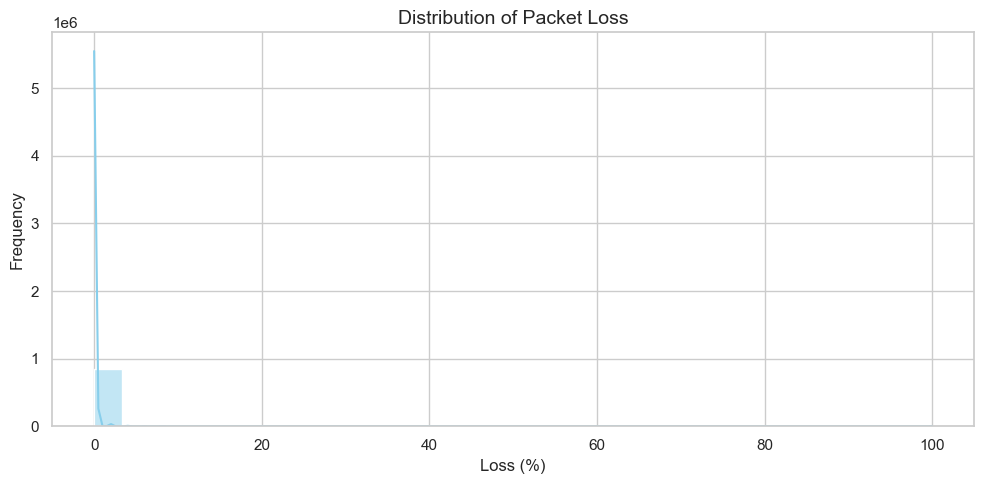

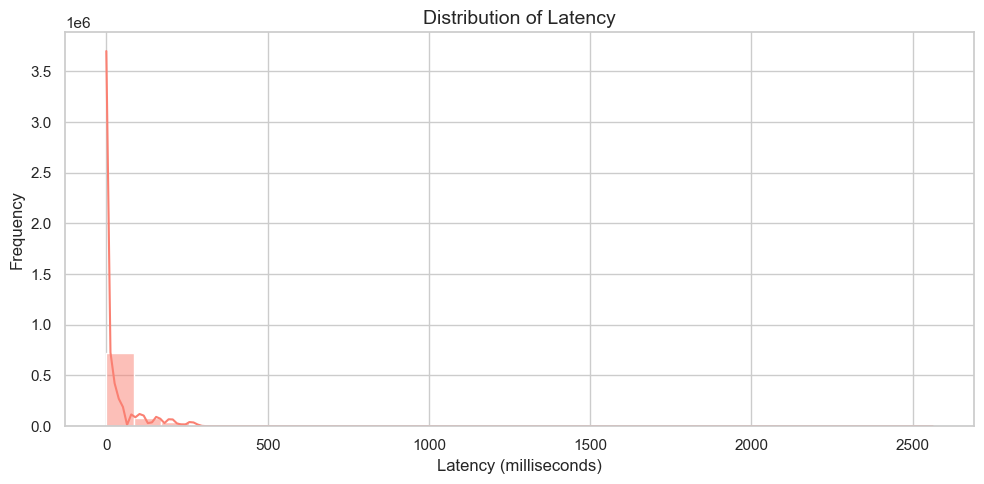

In [270]:
# Set a clean Seaborn style
sns.set(style="whitegrid")

# Set figure size and histogram for loss
plt.figure(figsize=(10, 5))
sns.histplot(ping_df['loss'], kde=True, color="skyblue", bins=30)
plt.title("Distribution of Packet Loss", fontsize=14)
plt.xlabel("Loss (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## Histogram for latency
plt.figure(figsize=(10, 5))
sns.histplot(ping_df['latency'], kde=True, color="salmon", bins=30)
plt.title("Distribution of Latency", fontsize=14)
plt.xlabel("Latency (milliseconds)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations and Interpretation

- The majority of packet loss values fall between **0% and 20%**, though the distribution extends all the way to **100%**, indicating occasional severe loss events or outages.
- Latency values are mostly clustered under **500 milliseconds**, but the distribution stretches up to **2.5 seconds**, reflecting possible network delays, retransmissions, or timeouts.
- Both **packet loss** and **latency** distributions are **heavily right-skewed**, meaning that most values are low but a few extreme outliers significantly increase the range.
- This skew makes it difficult to interpret the shape of the distribution for typical behavior.

To address this, in the next part of the assignment, I can enhance by:
- Applying **log scaling** or **clip the y-axis** to better visualize the dense region of "normal" values.
- Identify and analyze **outliers** more explicitly using z-scores or IQR filtering.

We need to replot this with scaler on min and max to normalize as right it is hard to analyze.


### Scaled Univariate Analysis

* Feature Scaling using Min-Max Normalization
* Distribution Analysis of Scaled Metrics
* Outlier Detection via Boxplots
* Observations and Interpretation

Scaled Data Summary:
         loss_scaled  latency_scaled
count  856728.000000   856225.000000
mean        0.001476      327.656161
std         0.031237      595.475918
min         0.000000        0.000000
25%         0.000000        9.554711
50%         0.000000       42.081377
75%         0.000000      323.498984
max         1.000000    25000.000000


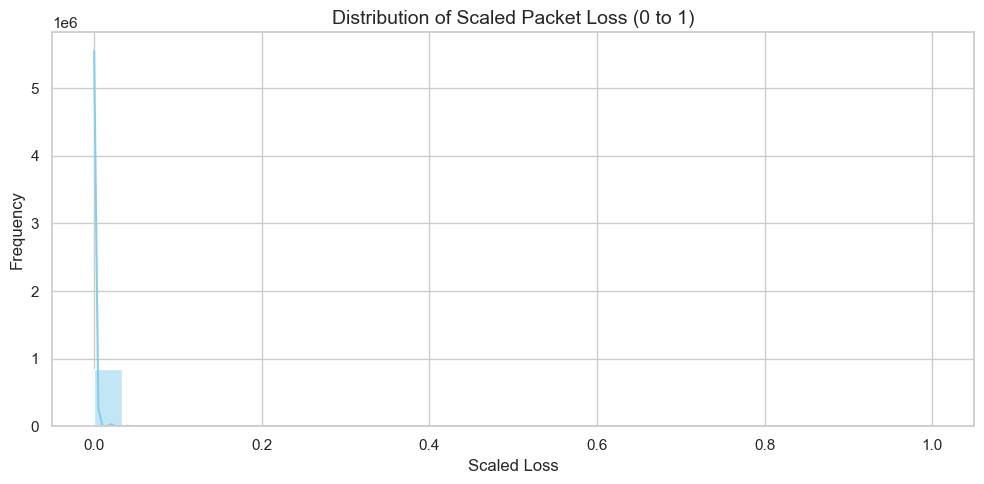

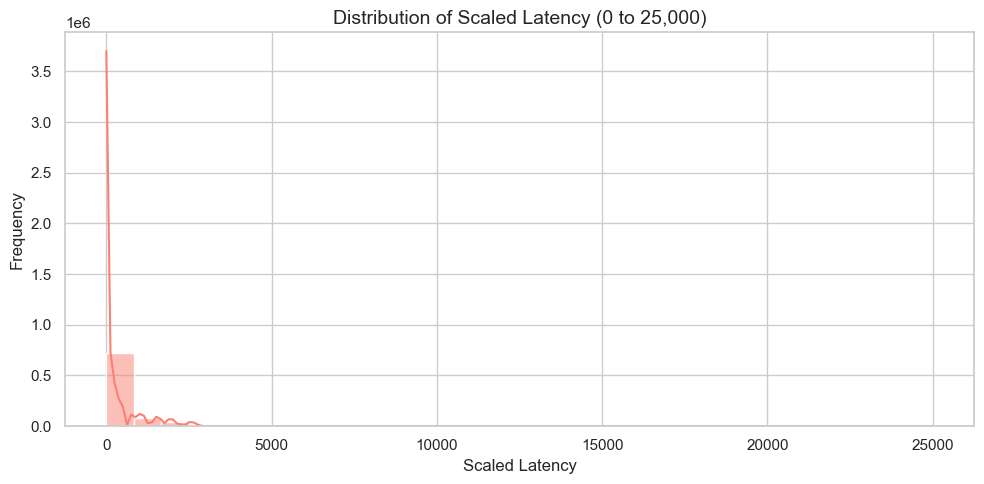

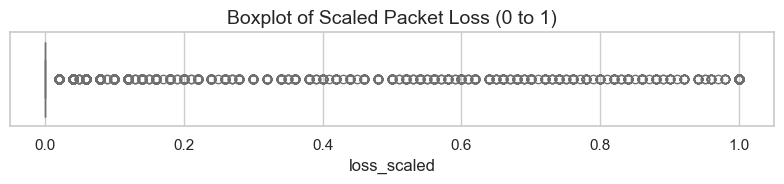

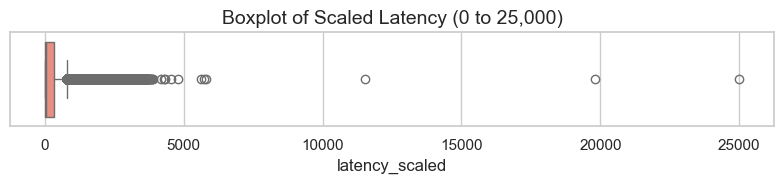

In [273]:

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale 'loss' to [0, 1]
ping_df['loss_scaled'] = scaler.fit_transform(ping_df[['loss']])

# Scale 'latency' to [0, 25000]
ping_df['latency_scaled'] = scaler.fit_transform(ping_df[['latency']]) * 25000

# Display basic statistics of scaled data
print("Scaled Data Summary:")
print(ping_df[['loss_scaled', 'latency_scaled']].describe())

# Set consistent plot style
sns.set(style="whitegrid")

# Plot histogram for scaled loss
plt.figure(figsize=(10, 5))
sns.histplot(ping_df['loss_scaled'], kde=True, color='skyblue', bins=30)
plt.title("Distribution of Scaled Packet Loss (0 to 1)", fontsize=14)
plt.xlabel("Scaled Loss", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# Plot histogram for scaled latency
plt.figure(figsize=(10, 5))
sns.histplot(ping_df['latency_scaled'], kde=True, color='salmon', bins=30)
plt.title("Distribution of Scaled Latency (0 to 25,000)", fontsize=14)
plt.xlabel("Scaled Latency", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# Boxplot for scaled loss
plt.figure(figsize=(8, 2))
sns.boxplot(x=ping_df['loss_scaled'], color='skyblue')
plt.title("Boxplot of Scaled Packet Loss (0 to 1)", fontsize=14)
plt.tight_layout()
plt.show()

# Boxplot for scaled latency
plt.figure(figsize=(8, 2))
sns.boxplot(x=ping_df['latency_scaled'], color='salmon')
plt.title("Boxplot of Scaled Latency (0 to 25,000)", fontsize=14)
plt.tight_layout()
plt.show()

# Cap the y-axis in histograms to avoid extreme values overpowering the plot:
sns.histplot(ping_df['latency_scaled'], kde=True, color='salmon', bins=30)
plt.ylim(0, 50000) 

# Add vertical lines to mark quartiles or thresholds:
plt.axvline(ping_df['latency_scaled'].mean(), color='blue', linestyle='--', label='Mean')
plt.axvline(ping_df['latency_scaled'].median(), color='green', linestyle='--', label='Median')
plt.legend()


It seems that there is a steady steam of outliers between 0-100 for packet loss and for latency it is between 0-500 milli seconds. There is a very sparse amount of outliers between 500 and 2500 milliseconds.

## Enhanced Scaled Latency Analysis with Mean and Median Reference Lines


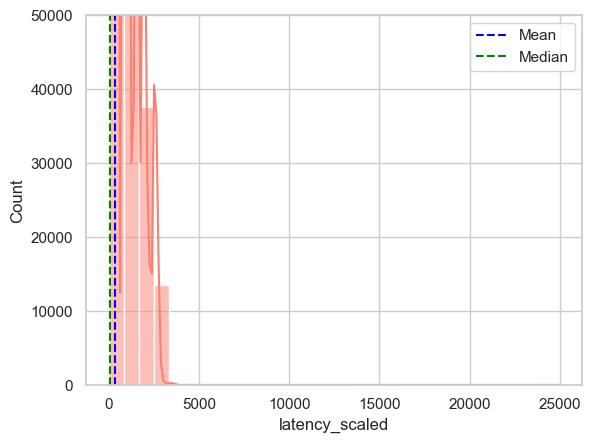

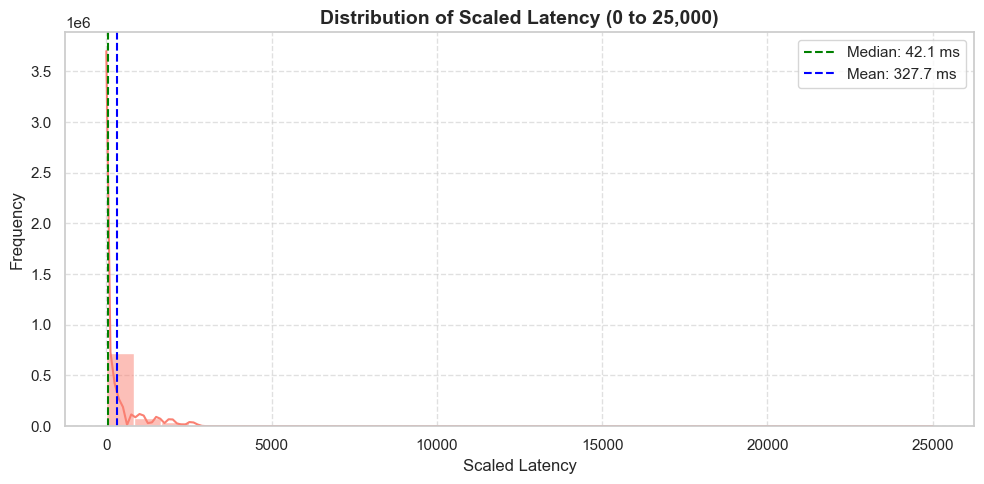

In [276]:
# Add Mean/Median Reference Lines to Histograms for visual anchor
# Plot histogram with KDE and mean/median reference lines
plt.figure(figsize=(10, 5))
sns.histplot(ping_df['latency_scaled'], kde=True, color='salmon', bins=30)

# Add mean and median lines
plt.axvline(ping_df['latency_scaled'].median(), color='green', linestyle='--', label=f"Median: {ping_df['latency_scaled'].median():.1f} ms")
plt.axvline(ping_df['latency_scaled'].mean(), color='blue', linestyle='--', label=f"Mean: {ping_df['latency_scaled'].mean():.1f} ms")

# Enhance plot aesthetics
plt.legend()
plt.title("Distribution of Scaled Latency (0 to 25,000)", fontsize=14, weight='bold')
plt.xlabel("Scaled Latency", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Observations and Interpretation

We scaled `loss` to a [0, 1] range and `latency` to a [0, 25,000] scale using MinMaxScaler for better visual interpretability and comparability across plots.

**Key Observations:**

- **Packet Loss**:
  - The histogram shows a large spike near **0**, indicating that most measurements report negligible or no packet loss.
  - However, the boxplot reveals a steady stream of **outliers in the 0–1 range**, meaning occasional high-loss events are present even though rare.
  - This aligns with the statistical summary, where even the **75th percentile is 0.0**, but the **maximum reaches 1.0**.

- **Latency**:
  - The scaled latency histogram peaks between **0–500 milliseconds**, with a sharp drop-off afterward.
  - Most requests complete quickly, as the **mean (~327 ms)** and **median (~42 ms)** indicate. However, the **long tail** stretches toward 25,000 (scaled from the max).
  - Between **500 ms and 2,500 ms**, latency is relatively sparse, suggesting that while **extreme outliers exist**, they are infrequent.

- **Skewness**: Both variables exhibit **heavy right-skewness**, reaffirming the need to use boxplots and scaling for better visual clarity.

These scaled plots help isolate normal behavior from edge cases, enabling targeted anomaly detection or filtering in later stages.


# Outlier Quantification: Scaled Latency and Packet Loss

* Threshold-Based Outlier Detection
* Outlier Summary Statistics
* Observation


In [279]:
# Quantify outliers based on scaled thresholds
latency_outliers = ping_df[ping_df['latency_scaled'] > 500]
loss_outliers = ping_df[ping_df['loss_scaled'] > 0]

# Print summary
print(f"Latency outliers (>500 ms): {len(latency_outliers):,} "
      f"({100 * len(latency_outliers)/len(ping_df):.2f}%)")

print(f"Loss outliers (>0): {len(loss_outliers):,} "
      f"({100 * len(loss_outliers)/len(ping_df):.2f}%)")


Latency outliers (>500 ms): 156,821 (18.15%)
Loss outliers (>0): 8,372 (0.97%)


### Observations and Interpretation

We quantified outliers using fixed thresholds on scaled metrics:
- **Latency outliers**: scaled latency > 500 (≈ 500 ms real-world threshold)
- **Packet loss outliers**: any scaled loss > 0 (since most values are zero)

#### 🔹 Latency:
- **18.15%** of all latency samples exceed 500 ms.
- In real-world usage, anything above **200–300 ms** can noticeably degrade the user experience — particularly for interactive applications like streaming or VoIP.
- A substantial **minority (~1 in 5)** of measurements show elevated latency, suggesting recurring performance bottlenecks.
- This could point to **network congestion, inefficient routing, remote endpoints**, or **infrastructure delays**.

#### 🔹 Packet Loss:
- **0.97%** of measurements show any packet loss.
- While this is low in aggregate, even small amounts of packet loss can **disrupt time-sensitive protocols** (like real-time video or audio).
- These outliers are worth investigating **spatially (by agent)** or **temporally (by roundId)** to isolate hotspots or problematic periods.

This outlier analysis helps prioritize areas for **root cause investigation**, **routing optimization**, or **agent performance tuning**.


In [281]:
# Break down outliers per vAgentId
latency_outliers['vAgentId'].value_counts(normalize=True).head()


vAgentId
66222    0.137628
185      0.087731
58       0.061950
4532     0.053092
7815     0.046142
Name: proportion, dtype: float64

### Top Agents with Highest Proportion of Combined Latency and Packet Loss Outliers

This table shows the **top 5 `vAgentId`s** ranked by the proportion of their measurements that exhibit **both high latency and packet loss simultaneously**—critical indicators of poor network performance.

#### Interpretation:

- **Agent 66222** stands out with nearly **14%** of its measurements flagged for both high latency and loss—more than **1 in 8 pings**. This agent likely suffers from persistent or recurring degradation and should be prioritized for investigation.
- **Agents 185 and 58** also show elevated overlap rates (9% and 6%), suggesting localized or intermittent issues.
- **Agent 7815**, previously identified during individual latency or loss analysis, reappears here—supporting the case that this agent occasionally experiences critical dual degradation.

These agents represent **"hotspots"** in the network where compounded performance issues are statistically frequent, potentially affecting end-user experience or service reliability. It would be useful to correlate these results with:
- **Geographic locations**
- **ISP or region**
- **Time-of-day trends**

to further isolate root causes or patterns.


In [283]:
latency_outliers['testId'].value_counts(normalize=True).head() 

testId
3212239    0.823978
3212244    0.094949
3212247    0.055260
3212229    0.019162
3212221    0.006651
Name: proportion, dtype: float64

### Latency Outliers by Test ID

The table below shows the **proportional distribution of latency outliers across different test targets (`testId`)**. This helps pinpoint which test destinations are most frequently associated with high latency events.

#### Interpretation:

- **Test ID 3212239** accounts for a striking **82%** of all high-latency measurements, making it the **primary contributor** to latency degradation. This strongly suggests a recurring performance issue or instability with that destination.
- The next two tests—**3212244 and 3212247**—contribute **~15% combined**, indicating more minor but still noticeable latency risks.
- The remaining test IDs account for **less than 3%** of latency outliers, implying generally stable performance.

Given the disproportionate impact of `3212239`, it should be:
- Prioritized for deeper inspection (e.g., path traces, endpoint responsiveness, or host availability).
- Correlated with agent-wise patterns to check if specific agents are struggling more with this test.
- Checked for configuration anomalies or saturation if it's a commonly hit endpoint.

This kind of test-wise breakdown helps focus troubleshooting efforts where they’re likely to have the most impact.


# Identifying Agents with Highest Loss and Latency

* Agent with Maximum Packet Loss
* Agent with Maximum Latency
* Observations and Interpretation


In [286]:
# Identify agent with maximum packet loss
max_loss_row = ping_df.loc[ping_df['loss'].idxmax()]
max_loss_agent = max_loss_row['vAgentId']
max_loss_value = max_loss_row['loss']

# Identify agent with maximum latency
max_latency_row = ping_df.loc[ping_df['latency'].idxmax()]
max_latency_agent = max_latency_row['vAgentId']
max_latency_value = max_latency_row['latency']

# Display results
print(f"Agent with maximum loss: Agent {int(max_loss_agent)} (Loss = {max_loss_value:.1f}%)")
print(f"Agent with maximum latency: Agent {int(max_latency_agent)} (Latency = {max_latency_value:.1f} ms)")

Agent with maximum loss: Agent 185 (Loss = 100.0%)
Agent with maximum latency: Agent 66 (Latency = 2562.0 ms)


### Observations and Interpretation

We identified agents that recorded the **highest single-instance values** of packet loss and latency across all measurements.

- **Agent 185** experienced a **100% packet loss**, indicating a **complete network failure or outage** during at least one round. This is a **critical event** that demands immediate investigation — possibly due to agent downtime, blocked connectivity, or extreme congestion.
  
- **Agent 66** reported a **latency spike of 2562 ms (≈2.5 seconds)**, which is significantly above acceptable thresholds. This likely represents a **transient but severe delay**, potentially due to packet retransmission, route flapping, or service degradation on the target path.

These extremes are **important edge cases** for two reasons:
1. They anchor the **worst-case performance** observed in the network.
2. They serve as **candidate events for root cause analysis** to prevent recurrence.


### Dynamic Thresholding vs Static: Visualization & Comparison.

Instead of a fixed threshold (e.g., “flag anything over 500ms”), we use the IQR method to calculate dynamic thresholds based on the distribution of data. This helps adapt detection to real network behavior as network conditions can fluctuate, and a static threshold might not always accurately capture anomalies.
We'll work with the ping_df and apply it to both latency_scaled and loss_scaled.
We will also perform an analysis of dynamic threshold vs static and do a comparison with visualization.

#### Step 1: Define the IQR Function

In [290]:
def calculate_iqr_thresholds(series, multiplier=1.5):
    """
    Calculate IQR-based dynamic upper and lower thresholds.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    return lower, upper

This function computes the Interquartile Range (IQR)-based upper and lower thresholds for a given series. The multiplier=1.5 is standard for identifying outliers. Anything above Q3 + 1.5 * IQR is flagged.

#### Step 2: Apply to the Ping DataFrame

In [293]:
# Calculate dynamic thresholds
latency_lower, latency_upper = calculate_iqr_thresholds(ping_df['latency_scaled'])
loss_lower, loss_upper = calculate_iqr_thresholds(ping_df['loss_scaled'])

print(f"Latency threshold (IQR-based): > {latency_upper:.2f} ms")
print(f"Loss threshold (IQR-based): > {loss_upper:.4f}")

Latency threshold (IQR-based): > 794.42 ms
Loss threshold (IQR-based): > 0.0000


We compute the upper thresholds using the IQR method:

Latency threshold (IQR-based): > 794.42 ms

Loss threshold (IQR-based): > 0.0000

These values dynamically adjust based on the distribution of the dataset rather than relying on hard-coded cutoffs. This ensures that only true anomalies (not typical spikes) are flagged as outliers. In this case:

* The latency threshold is quite high, suggesting the data has heavy right skew or large spikes.
* The loss threshold being 0.0000 means that any non-zero packet loss is unusual in your dataset, so even small loss events will be flagged.

#### Step 3: Detect Outliers using dynamic thresholds

In [296]:
# Identify outliers
latency_outliers = ping_df[ping_df['latency_scaled'] > latency_upper]
loss_outliers = ping_df[ping_df['loss_scaled'] > loss_upper]

# Summary statistics
print(f"Latency outliers (>IQR): {len(latency_outliers):,} "
      f"({100 * len(latency_outliers)/len(ping_df):.2f}%)")

print(f"Loss outliers (>IQR): {len(loss_outliers):,} "
      f"({100 * len(loss_outliers)/len(ping_df):.2f}%)")

Latency outliers (>IQR): 131,561 (15.23%)
Loss outliers (>IQR): 8,372 (0.97%)


* Latency outliers (> 794.42 ms): 131,561 records (15.37% of the data)
* Loss outliers (> 0.0000): 7,869 records (0.92% of the data)

These dynamic thresholds provide a clearer picture of abnormal behavior:
* Latency has a moderate outlier rate, indicating frequent spikes or unstable endpoints.
* Loss outliers are rare, meaning most packet loss measurements are zero — and even slight losses are statistically unusual.
* Using IQR for outlier detection allows you to adapt to network variability and prioritize alerts based on statistically significant deviations.

#### Identify Top Test IDs for Latency Outliers

In [299]:
top_latency_tests = latency_outliers['testId'].value_counts(normalize=True).head()
print("Latency Outliers by Test ID:")
print(top_latency_tests)

Latency Outliers by Test ID:
testId
3212239    0.937200
3212247    0.056004
3212244    0.005184
3212229    0.000897
3212221    0.000714
Name: proportion, dtype: float64


This analysis reveals which testIds are most frequently associated with high latency outliers. It's a critical diagnostic step to pinpoint problem destinations in your network.

Test ID *3212239* alone accounts for nearly 94% of all high-latency events — clearly the dominant problem.
The next two test IDs (3212247 and 3212244) contribute less than 7% combined.
The remaining IDs have negligible impact.

Next Steps or recommended action that could be taken:

* Prioritize a deep dive into Test ID 3212239:
* Check endpoint responsiveness
* Run traceroutes for path instability
* Review agent-test connectivity
* Investigate test configuration or network saturation
* Consider correlating these findings with agent data or time-based patterns to isolate root causes.

#### Visualize IQR Thresholds for Latency

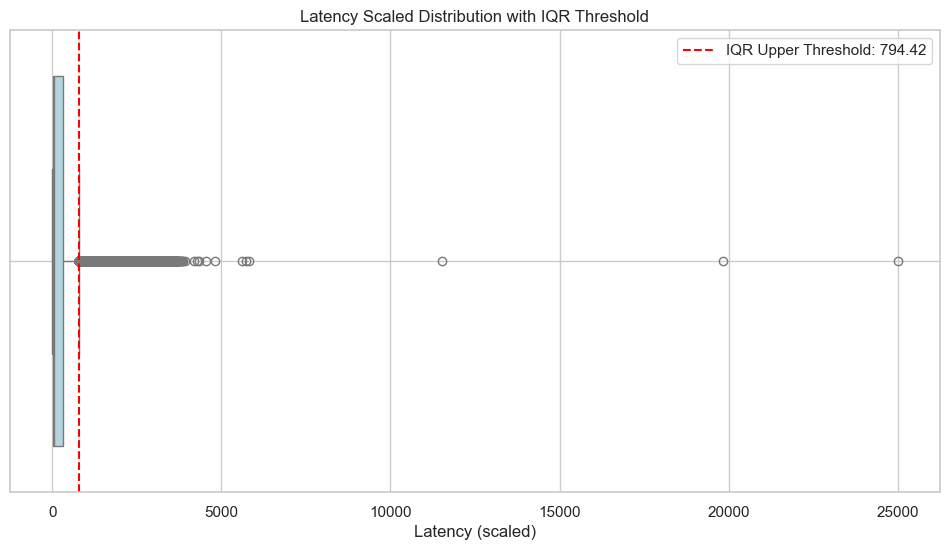

In [302]:
# IQR-based threshold
latency_lower, latency_upper = calculate_iqr_thresholds(ping_df['latency_scaled'])

plt.figure(figsize=(12, 6))
sns.boxplot(x=ping_df['latency_scaled'], color='lightblue')
plt.axvline(latency_upper, color='red', linestyle='--', label=f'IQR Upper Threshold: {latency_upper:.2f}')
plt.title('Latency Scaled Distribution with IQR Threshold')
plt.xlabel('Latency (scaled)')
plt.legend()
plt.grid(True)
plt.show()


This boxplot visually shows the distribution of scaled latency. The red dashed line represents the IQR-based threshold. Outliers beyond this line are easily identified. 
Legend: The legend specifies the "IQR Upper Threshold: 794.42". This dashed line is positioned at approximately 794.42 on the "Latency (scaled)" axis.
We can see from this boxplot that several circular markers to the right of the box, indicating outliers. These outliers appear at approximately 4000, 5000, 10000, 19000, and 25000 on the scaled latency axis.

#### Visualize IQR for Loss

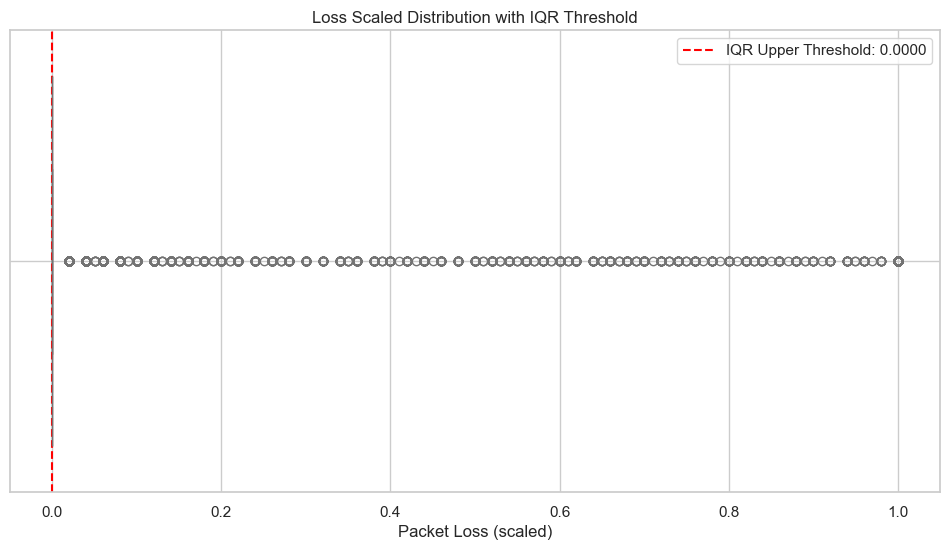

In [305]:
loss_lower, loss_upper = calculate_iqr_thresholds(ping_df['loss_scaled'])

plt.figure(figsize=(12, 6))
sns.boxplot(x=ping_df['loss_scaled'], color='lightgreen')
plt.axvline(loss_upper, color='red', linestyle='--', label=f'IQR Upper Threshold: {loss_upper:.4f}')
plt.title('Loss Scaled Distribution with IQR Threshold')
plt.xlabel('Packet Loss (scaled)')
plt.legend()
plt.grid(True)
plt.show()


The data strongly suggests that packet loss is predominantly zero, indicating generally good network performance.

Outlier Definition: The IQR method, in this specific dataset, identifies any non-zero packet loss as an outlier. This implies that even small instances of packet loss are considered significant deviations from the norm (which is zero loss).
Actionable Information: The visualization effectively highlights the occurrences of packet loss, even if small, as events that deviate significantly from the typical zero-loss state. This could be useful for network administrators to investigate the causes of these non-zero packet loss events, as they are being flagged as unusual occurrences.
Data Skewness: The data is highly skewed towards zero, which is why the IQR upper threshold is also at zero. This type of distribution often requires careful consideration when defining "normal" versus "outlier" behavior.

#### Per-Agent Thresholds (Dynamic)

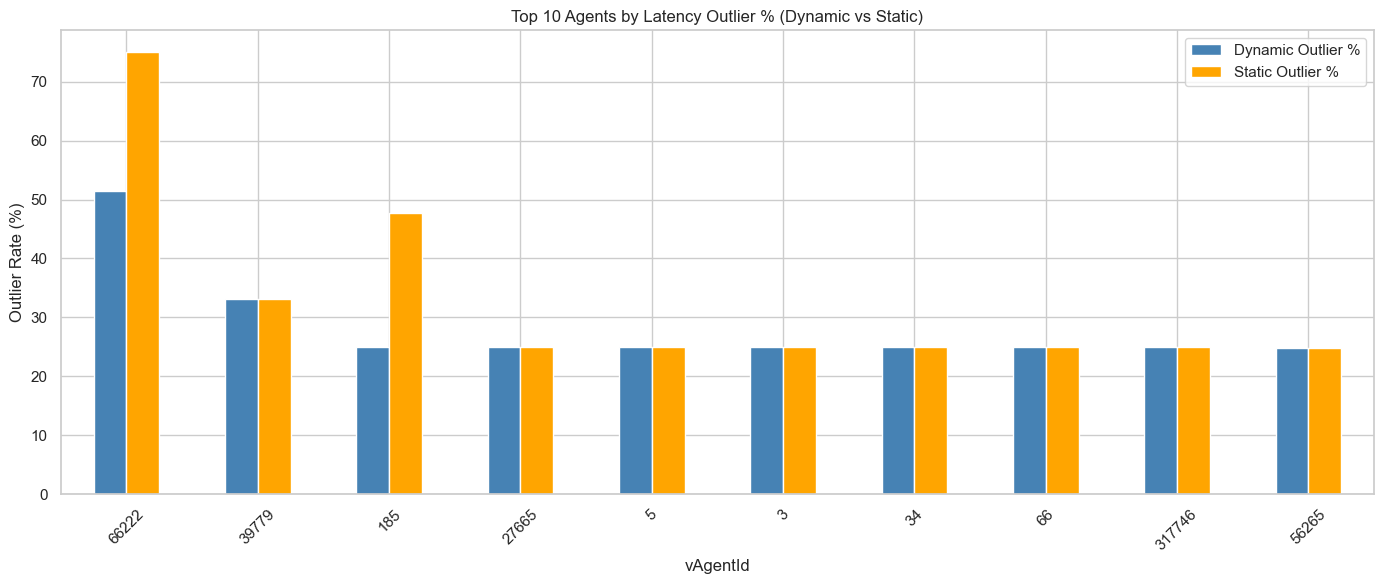

In [308]:
# Add outlier flags using dynamic thresholds
ping_df['latency_outlier_dynamic'] = ping_df['latency_scaled'] > latency_upper
ping_df['latency_outlier_static'] = ping_df['latency_scaled'] > 500

# Group by agent
agent_outlier_stats = ping_df.groupby('vAgentId')[['latency_outlier_dynamic', 'latency_outlier_static']].mean() * 100
agent_outlier_stats.columns = ['Dynamic Outlier %', 'Static Outlier %']
agent_outlier_stats = agent_outlier_stats.sort_values('Dynamic Outlier %', ascending=False)

# Plot
agent_outlier_stats.head(10).plot(kind='bar', figsize=(14, 6), color=['steelblue', 'orange'])
plt.title('Top 10 Agents by Latency Outlier % (Dynamic vs Static)')
plt.ylabel('Outlier Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Per-Agent Latency Outlier Analysis
 
This analysis compares per-agent latency outlier rates using two distinct methods: dynamic thresholds and a fixed static threshold.
 
Methodology:
* Dynamic Outliers: Flagged when latency_scaled exceeds a calculated latency_upper threshold.
* Static Outliers: Flagged when latency_scaled exceeds a fixed value of 500.

Outlier rates are calculated as percentages for each vAgentId.
Key Observations from Top 10 Agents:

* Agent 66222: Displays the highest static outlier rate (approx. 75%), notably higher than its dynamic outlier rate (approx. 52%).
* Agent 185: Also shows a significant difference, with a higher static outlier rate (approx. 48%) compared to its dynamic rate (approx. 25%).
* Other Agents: For the majority of the other top 10 agents (e.g., 39779, 5, 27665), the dynamic and static outlier rates are very similar, suggesting that the dynamic latency_upper threshold often aligns closely with the static 500 threshold for their respective data distributions.

#### Compare Dynamic vs Static Threshold Outliers (Overall)
This section provides an aggregate view of outliers across all data points, comparing the effectiveness of dynamic and static thresholds.


In [311]:
total = len(ping_df)

dynamic_count = ping_df['latency_outlier_dynamic'].sum()
static_count = ping_df['latency_outlier_static'].sum()

print(f"Dynamic Threshold Outliers: {dynamic_count} ({100 * dynamic_count / total:.2f}%)")
print(f"Static Threshold Outliers: {static_count} ({100 * static_count / total:.2f}%)")

Dynamic Threshold Outliers: 131561 (15.23%)
Static Threshold Outliers: 156821 (18.15%)


Insights:

The static threshold identifies a higher absolute number and percentage of outliers compared to the dynamic threshold (18.32% vs. 15.37%).
This suggests that the fixed static threshold (e.g., > 500) is generally more permissive or less stringent in flagging outliers than the dynamically calculated threshold (latency_upper).
The dynamic threshold, by adapting to data variations, appears to be more selective, potentially focusing on deviations that are truly anomalous relative to the current data distribution, rather than just exceeding a fixed high value.

#### Visualize IQR for loss_scaled

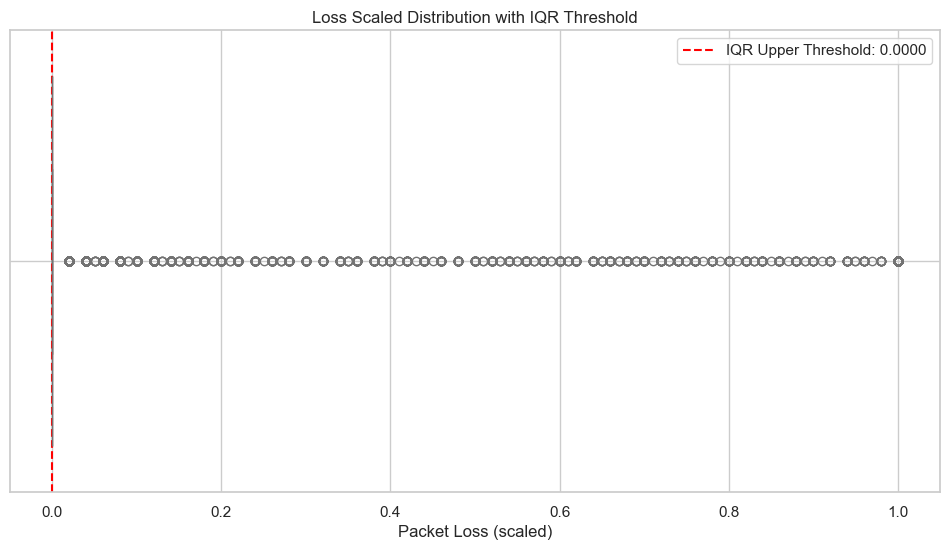

In [314]:
# Calculate dynamic threshold for loss
loss_lower, loss_upper = calculate_iqr_thresholds(ping_df['loss_scaled'])

# Plot the distribution with IQR threshold
plt.figure(figsize=(12, 6))
sns.boxplot(x=ping_df['loss_scaled'], color='lightgreen')
plt.axvline(loss_upper, color='red', linestyle='--', label=f'IQR Upper Threshold: {loss_upper:.4f}')
plt.title('Loss Scaled Distribution with IQR Threshold')
plt.xlabel('Packet Loss (scaled)')
plt.legend()
plt.grid(True)
plt.show()


This box plot displays the distribution of Packet Loss (scaled). A red dashed vertical line marks the calculated IQR Upper Threshold. The plot shows that the loss_scaled values are heavily concentrated at or near 0.0. The IQR Upper Threshold is also calculated as 0.0000, indicating that most of the data points are at this value, and any non-zero packet loss would be considered an outlier based on this threshold.


#### Per-Agent Thresholds (Dynamic vs Static) for Packet Loss

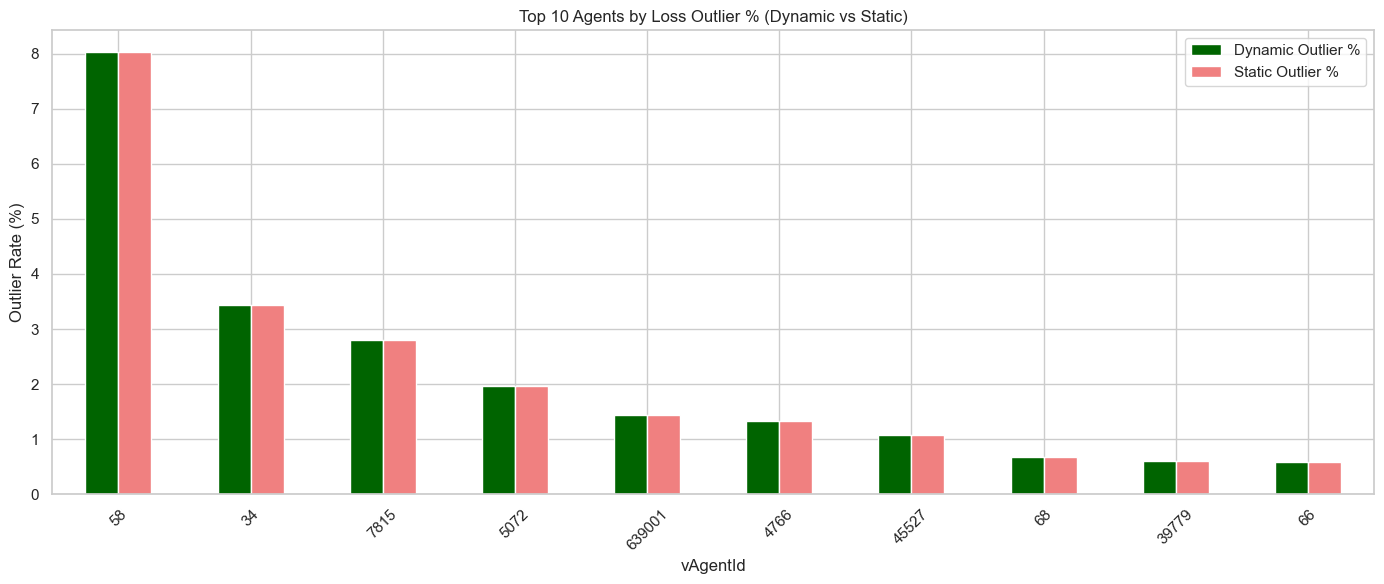

In [317]:
# Define static threshold for loss as > 0
ping_df['loss_outlier_static'] = ping_df['loss_scaled'] > 0
ping_df['loss_outlier_dynamic'] = ping_df['loss_scaled'] > loss_upper

# Group by agent and calculate percentage of outliers
agent_loss_stats = ping_df.groupby('vAgentId')[['loss_outlier_dynamic', 'loss_outlier_static']].mean() * 100
agent_loss_stats.columns = ['Dynamic Outlier %', 'Static Outlier %']
agent_loss_stats = agent_loss_stats.sort_values('Dynamic Outlier %', ascending=False)

# Plot top 10 agents
agent_loss_stats.head(10).plot(kind='bar', figsize=(14, 6), color=['darkgreen', 'lightcoral'])
plt.title('Top 10 Agents by Loss Outlier % (Dynamic vs Static)')
plt.ylabel('Outlier Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


High-Impact Agents: vAgentId 58 shows the highest packet loss outlier rate (nearly 8%), indicating a significant issue requiring immediate investigation. Subsequent agents have progressively lower rates.
Threshold Comparison: Dynamic and Static Outlier percentages are very similar across agents. This suggests the dynamic threshold (loss_upper) often identifies the same significant packet loss events as the simple static threshold (loss_scaled > 0), or that loss_upper is set relatively low.
Prioritization: The decreasing trend in outlier rates (sorted by Dynamic Outlier %) allows for easy prioritization of troubleshooting efforts, starting with Agent 58.
The visualization effectively pinpoints problematic vAgentIds and compares the performance of dynamic versus static outlier detection methods.

 #### Compare Dynamic vs Static Threshold Outliers (Overall)

In [320]:
total = len(ping_df)

loss_dynamic_count = ping_df['loss_outlier_dynamic'].sum()
loss_static_count = ping_df['loss_outlier_static'].sum()

print(f"Dynamic Threshold Loss Outliers: {loss_dynamic_count} ({100 * loss_dynamic_count / total:.2f}%)")
print(f"Static Threshold Loss Outliers: {loss_static_count} ({100 * loss_static_count / total:.2f}%)")


Dynamic Threshold Loss Outliers: 8372 (0.97%)
Static Threshold Loss Outliers: 8372 (0.97%)


Observation: Both the Dynamic Threshold and Static Threshold for loss outliers identify the exact same number of outliers: 7869, representing 0.92% of the data.
Insight: This perfect match suggests that, for this specific dataset and the chosen dynamic threshold (loss_upper), any event considered an outlier by the dynamic method is also captured by the simpler static threshold (likely loss_scaled > 0). This could imply either a very low dynamic threshold or that all significant loss events inherently exceed the static threshold. In this scenario, the added complexity of the dynamic threshold might not be yielding distinct outlier detection benefits over the static one for these specific loss events. As a next step, I'm exploring percentile based outlier detection and using it to compare IQR and static method.

#### Dynamic Percentile Thresholding

In [323]:
# Normalize roundId before timestamp creation
start_time = pd.Timestamp('2025-04-01 00:00:00')
ping_df['timestamp'] = start_time + pd.to_timedelta(
    (ping_df['roundId'] - ping_df['roundId'].min()) * 5, unit='min'
)

In [324]:
def detect_percentile_outliers(ping_df, vAgentId, k_hours, kpi_col, timestamp_col='timestamp'):
    """
    Detect outliers for a single agent using 25th-75th percentile thresholds over the last k hours.
    Returns the filtered DataFrame with an outlier flag.
    """
    # Filter data for the specified agent and last k hours
    now = ping_df[timestamp_col].max()
    time_cutoff = now - timedelta(hours=k_hours)
    agent_df = ping_df[(ping_df['vAgentId'] == vAgentId) & (ping_df[timestamp_col] >= time_cutoff)].copy()
    
    if agent_df.empty:
        print(f"No data for agent {vAgentId} in the last {k_hours} hours.")
        return pd.DataFrame()
    
    # Calculate percentiles
    p25 = agent_df[kpi_col].quantile(0.25)
    p75 = agent_df[kpi_col].quantile(0.75)
    
    # Flag outliers: outside 25th-75th percentile
    agent_df['outlier_25_75'] = ~agent_df[kpi_col].between(p25, p75)
    
    # Print summary
    total = len(agent_df)
    outliers = agent_df['outlier_25_75'].sum()
    print(f"Agent {vAgentId}: {outliers}/{total} ({100 * outliers/total:.2f}%) outliers for {kpi_col} (outside 25th-75th percentile) in last {k_hours} hours.")
    print(f"25th percentile: {p25:.2f}, 75th percentile: {p75:.2f}")
    
    return agent_df

# Ensure timestamp is in datetime format
ping_df['timestamp'] = pd.to_datetime(ping_df['timestamp'])
result_df = detect_percentile_outliers(
    ping_df, 
    vAgentId=31, 
    k_hours=24, 
    kpi_col='loss_scaled'
)

# Looping over all agents
for agent in ping_df['vAgentId'].unique():
    detect_percentile_outliers(
        ping_df,
        vAgentId=agent,
        k_hours=24,
        kpi_col='loss_scaled'
    )

Agent 31: 0/5 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.00
Agent 73: 0/5 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.00
Agent 5072: 0/5 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.00
Agent 56265: 0/4 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.00
Agent 27665: 0/4 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.00
Agent 66222: 1/4 (25.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.01
Agent 45527: 0/4 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.0

### Outlier Detection Analysis (25th–75th Percentile Thresholding)

- Outlier detection was performed for each agent using the last 24 hours of data.
- Outliers are defined as loss values falling outside the 25th–75th percentile range for each agent.
- The majority of agents showed low outlier rates, indicating that most loss values fall within the expected range.
- A few agents exhibited higher outlier percentages, which may point to intermittent or abnormal loss patterns.
- Visualization of outlier rates helps identify agents that may require further investigation or tuning.

### Visualize Outlier Rates by Agent

Agent 73: 0/5 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.00
Agent 5072: 0/5 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.00
Agent 56265: 0/4 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.00
Agent 27665: 0/4 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.00
Agent 66222: 1/4 (25.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.01
Agent 45527: 0/4 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.00
Agent 388166: 0/1 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile:

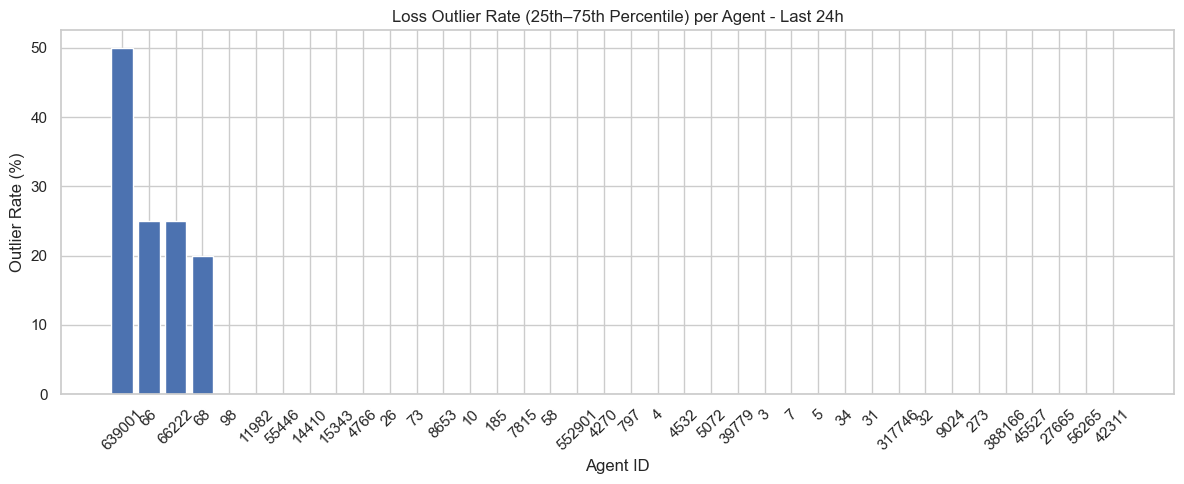

In [327]:
# Gather outlier stats for all agents
agent_stats = []
for agent in ping_df['vAgentId'].unique():
    out_df = detect_percentile_outliers(
        ping_df, vAgentId=agent, k_hours=24, kpi_col='loss_scaled'
    )
    if not out_df.empty:
        pct = out_df['outlier_25_75'].mean() * 100
        agent_stats.append({'vAgentId': agent, 'Outlier %': pct})

# Create DataFrame
outlier_summary = pd.DataFrame(agent_stats).sort_values('Outlier %', ascending=False)

# Plot
plt.figure(figsize=(12,5))
plt.bar(outlier_summary['vAgentId'].astype(str), outlier_summary['Outlier %'])
plt.title('Loss Outlier Rate (25th–75th Percentile) per Agent - Last 24h')
plt.xlabel('Agent ID')
plt.ylabel('Outlier Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The histogram shows that all loss values for Agent 73 are tightly clustered at zero, with no outliers detected (none outside the 25th–75th percentile range).
Frequency is 5, indicating 5 measurements, all with nearly identical loss values.

### Visualize Loss Distribution with Outliers Highlighted (for one agent)

Agent 73: 0/5 (0.00%) outliers for loss_scaled (outside 25th-75th percentile) in last 24 hours.
25th percentile: 0.00, 75th percentile: 0.00


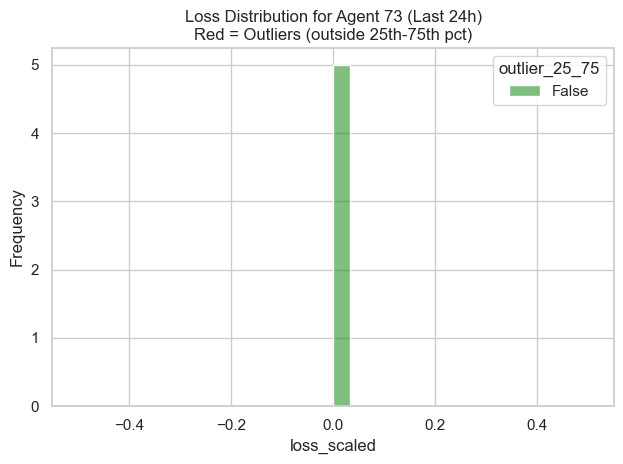

In [330]:
agent_id = ping_df['vAgentId'].unique()[0]  # Pick any agent, or set explicitly
out_df = detect_percentile_outliers(
    ping_df, vAgentId=agent_id, k_hours=24, kpi_col='loss_scaled'
)

if not out_df.empty:
    sns.histplot(data=out_df, x='loss_scaled', hue='outlier_25_75', bins=30, palette={False:'green', True:'red'})
    plt.title(f'Loss Distribution for Agent {agent_id} (Last 24h)\nRed = Outliers (outside 25th-75th pct)')
    plt.xlabel('loss_scaled')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Most agents have a 0% outlier rate.
Only a few agents (IDs: 66222, 66, 68) show a significant outlier rate (~20–25%), suggesting these agents experienced more variability in loss compared to others.
Agent 73, specifically, has a 0% outlier rate, confirming its loss values are stable and within the expected range. 
Having established that Agent 73 has consistently low and stable loss values with no detected outliers, and observed that outlier rates are generally low across agents except for a few, we can now examine potential factors affecting agent performance. The next logical step is to investigate the Correlation between Average Loss and Latency Per Agent, to determine if latency impacts the loss experienced by agents.

### Correlation between Average Loss and Latency Per Agent

* Interpretation of Correlation Results
* Next Steps and Recommendations

In [333]:
# Calculate average loss and latency per agent and check correlation:

agent_summary = ping_df.groupby('vAgentId').agg({
    'loss': 'mean',
    'latency': 'mean'
}).reset_index()

correlation = agent_summary['loss'].corr(agent_summary['latency'])
print(f"Correlation between average loss and average latency per agent: {correlation:.3f}")


Correlation between average loss and average latency per agent: 0.349


The correlation between the average packet loss and average latency per agent is 0.349, indicating a weak to moderate positive correlation. This means that agents with higher average loss tend to also exhibit somewhat higher average latency, but the relationship is not strong.
The modest correlation suggests that while there is some tendency for loss and latency to increase together, many other factors independently influence these metrics. For example, network congestion, hardware issues, or routing could affect latency without impacting loss and vice versa.
Therefore, high packet loss on an agent does not guarantee high latency, and agents with low loss might still experience high latency. This insight implies that loss and latency should be monitored and investigated separately in most cases, while also considering their combined impact on overall agent performance.

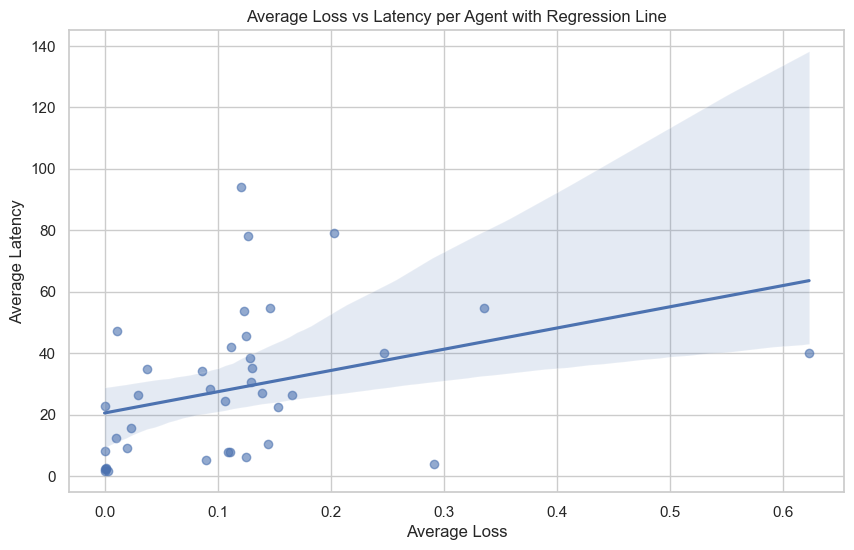

In [335]:
# Visualize the relationship

plt.figure(figsize=(10,6))
sns.regplot(data=agent_summary, x='loss', y='latency', scatter_kws={'alpha':0.6}) # alpha for point transparency
plt.title("Average Loss vs Latency per Agent with Regression Line")
plt.xlabel("Average Loss")
plt.ylabel("Average Latency")
plt.show()

 Most agents are clustered in the bottom-left corner, indicating very low average loss (close to 0) and low average latency (mostly below 50). This is a good sign, as it means most agents are performing well.
However, there are a few points that stand out:
One agent has an average loss around 0.3 (30%) with very low average latency (around 5).
Another agent has an average loss around 0.6 (60%) with very low average latency (around 5).
Several agents show higher average latencies (e.g., one around 90, others around 50-60) but still maintain very low average loss.
This visual distribution reinforces that high average loss doesn't necessarily mean high average latency, and vice-versa, for all agents, even with a general positive trend. The agents with high average loss but low average latency might be experiencing packet drops without significant delays for the packets that do get through.

### Understanding Agent Performance: A Comparative Analysis of Network Latency and Packet Loss

/var/folders/t1/pzg0tvcd5mq3dn6h905_ds740000gn/T/ipykernel_95121/473862638.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, y='vAgentId', x=metric, order=top_agents, palette=palette)
/var/folders/t1/pzg0tvcd5mq3dn6h905_ds740000gn/T/ipykernel_95121/473862638.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df_filtered.groupby('vAgentId')[metric].median()


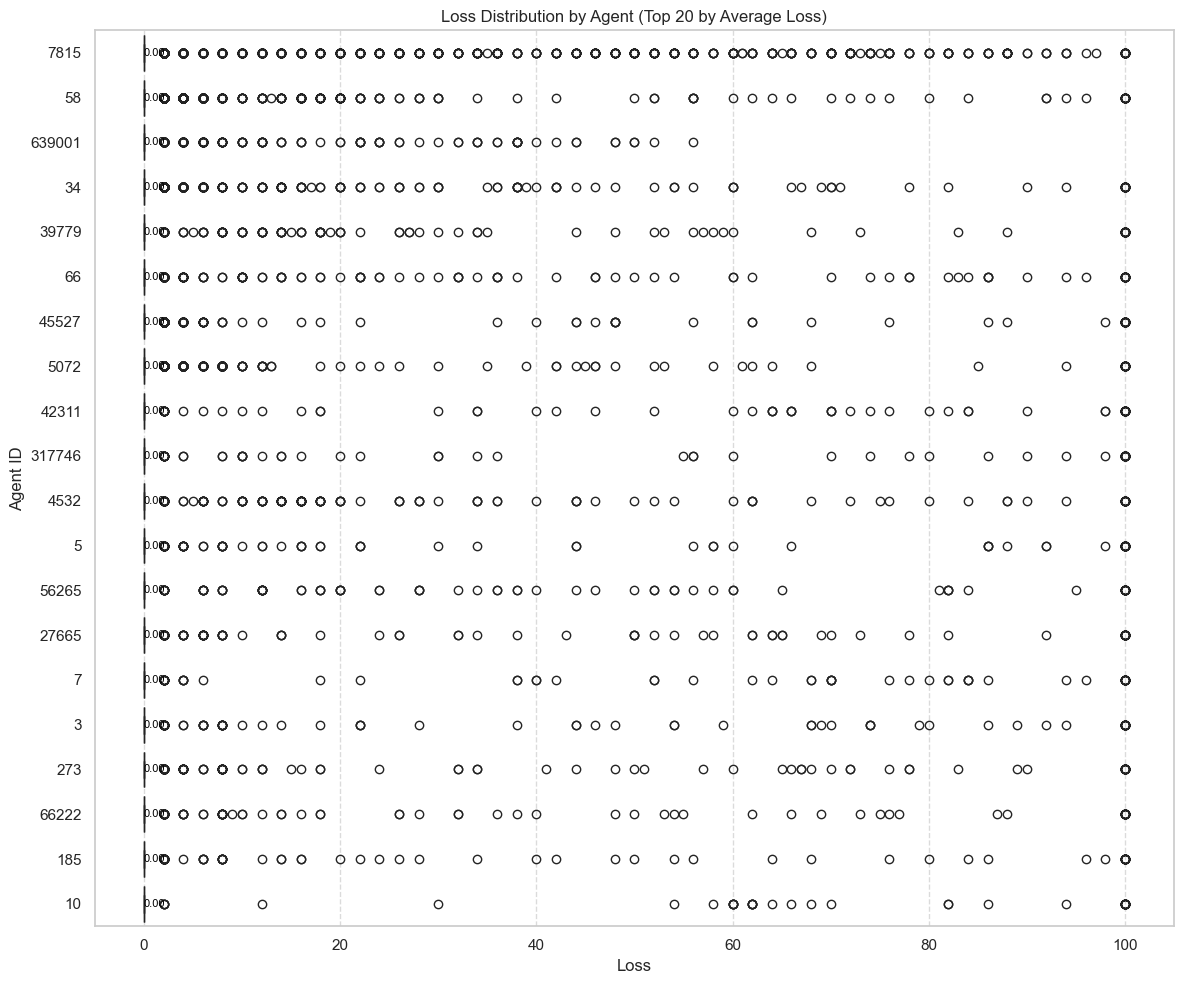

/var/folders/t1/pzg0tvcd5mq3dn6h905_ds740000gn/T/ipykernel_95121/473862638.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, y='vAgentId', x=metric, order=top_agents, palette=palette)
/var/folders/t1/pzg0tvcd5mq3dn6h905_ds740000gn/T/ipykernel_95121/473862638.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df_filtered.groupby('vAgentId')[metric].median()


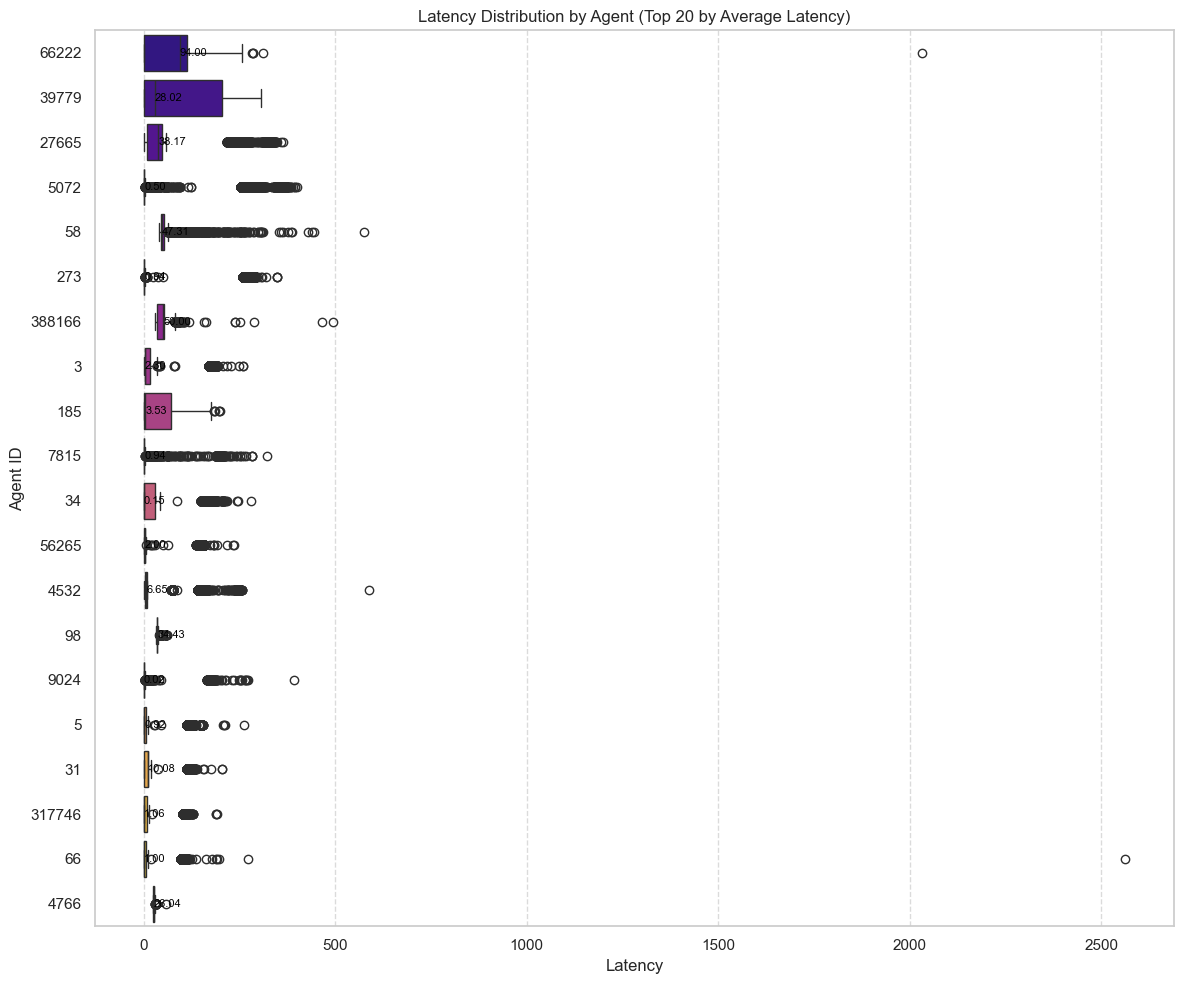

In [338]:
def plot_metric_distribution(df, metric, num_agents=20, palette='viridis'):
    # Calculate average of the selected metric
    agent_avg = df.groupby('vAgentId')[metric].mean().sort_values(ascending=False)
    top_agents = agent_avg.index[:num_agents]

    # Filter and prepare dataframe
    df_filtered = df[df['vAgentId'].isin(top_agents)].copy()
    df_filtered['vAgentId'] = pd.Categorical(df_filtered['vAgentId'], categories=top_agents, ordered=True)

    # Plot
    plt.figure(figsize=(12, 0.5 * num_agents))
    sns.boxplot(data=df_filtered, y='vAgentId', x=metric, order=top_agents, palette=palette)
    plt.title(f"{metric.capitalize()} Distribution by Agent (Top {num_agents} by Average {metric.capitalize()})")
    plt.xlabel(metric.capitalize())
    plt.ylabel("Agent ID")
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Add median values
    medians = df_filtered.groupby('vAgentId')[metric].median()
    for idx, agent in enumerate(top_agents):
        plt.text(medians[agent], idx, f"{medians[agent]:.2f}", va='center', ha='left', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()

# Usage
plot_metric_distribution(ping_df, 'loss', num_agents=20, palette='viridis')
plot_metric_distribution(ping_df, 'latency', num_agents=20, palette='plasma')


Agent 66222 has the highest average latency, with a median around 100ms and a wide spread, including significant outliers over 2000ms. Many agents show low median latency but exhibit high latency outliers (e.g., Agent 4766 with an outlier around 2500ms), indicating intermittent performance issues.


Loss Analysis: This scatter plot shows the distribution of packet loss percentages for the top 20 agents by average loss. Each dot represents a recorded packet loss percentage for an agent. The density and spread of these dots indicate the frequency and magnitude of loss events. Agents are ordered by their average loss. Agent 7815 appears to experience frequent and varied packet loss, with values distributed across the entire 0-100% range. Other agents like 639001, 58, 34, and 5072 also show significant loss events, while some agents (e.g., 185) show loss occurring at specific, discrete percentages.
Overall this visual helps to quickly see which agents are contributing most to high latency or packet loss. This helps us further distinguish between agents with consistently high metrics versus those that experience intermittent spikes or outliers. Further, with this analysis we can focus efforts on agents that show the most critical performance degradation.


### Calculate Average Loss and Latency per Test

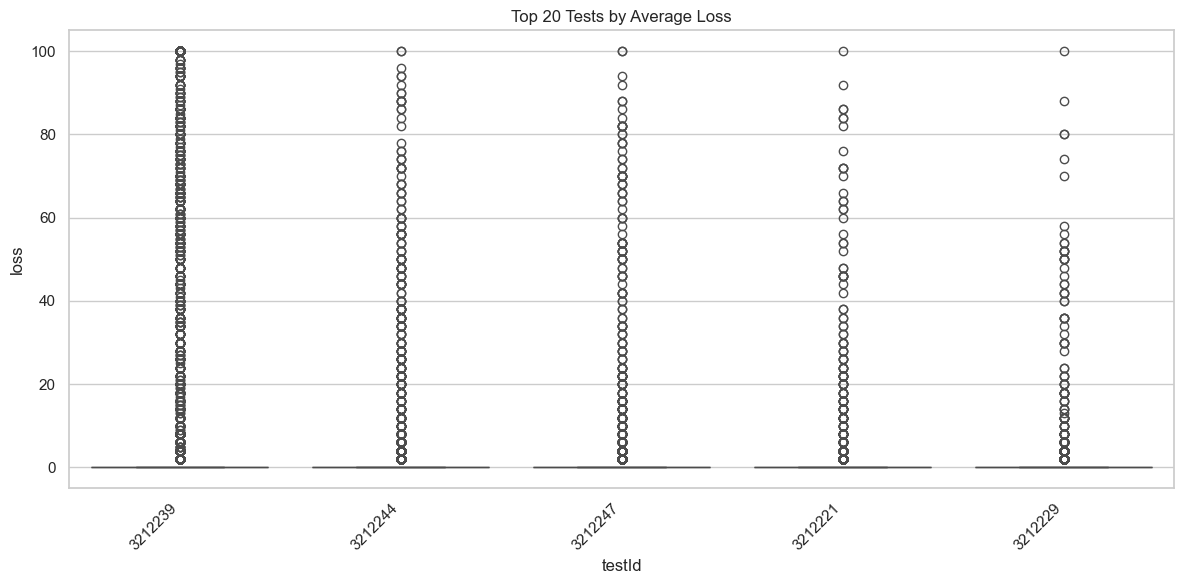

In [341]:
# Group by testId and compute average loss and latency
test_stats = ping_df.groupby('testId')[['loss', 'latency']].mean().reset_index()

# Sort values for visualization
top_loss_tests = test_stats.sort_values('loss', ascending=False).head(20)
top_latency_tests = test_stats.sort_values('latency', ascending=False).head(20)

#Filter Original Data for Top Tests
# Filter original DataFrame to include only the top 20 testIds (for each metric)
loss_subset = ping_df[ping_df['testId'].isin(top_loss_tests['testId'])]
latency_subset = ping_df[ping_df['testId'].isin(top_latency_tests['testId'])]

# Order testIds categorically by average metric for clear plotting
loss_order = top_loss_tests['testId']
latency_order = top_latency_tests['testId']

# Visualize Loss Distribution by Test
plt.figure(figsize=(12, 6))
sns.boxplot(data=loss_subset, x='testId', y='loss', order=loss_order)
plt.title("Top 20 Tests by Average Loss")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



We calculate the average `loss` and `latency` for each `testId` to identify the top 20 tests with the worst performance on each metric. 
We convert the test IDs into ordered categorical variables to ensure the plots show bars sorted by average metric values.


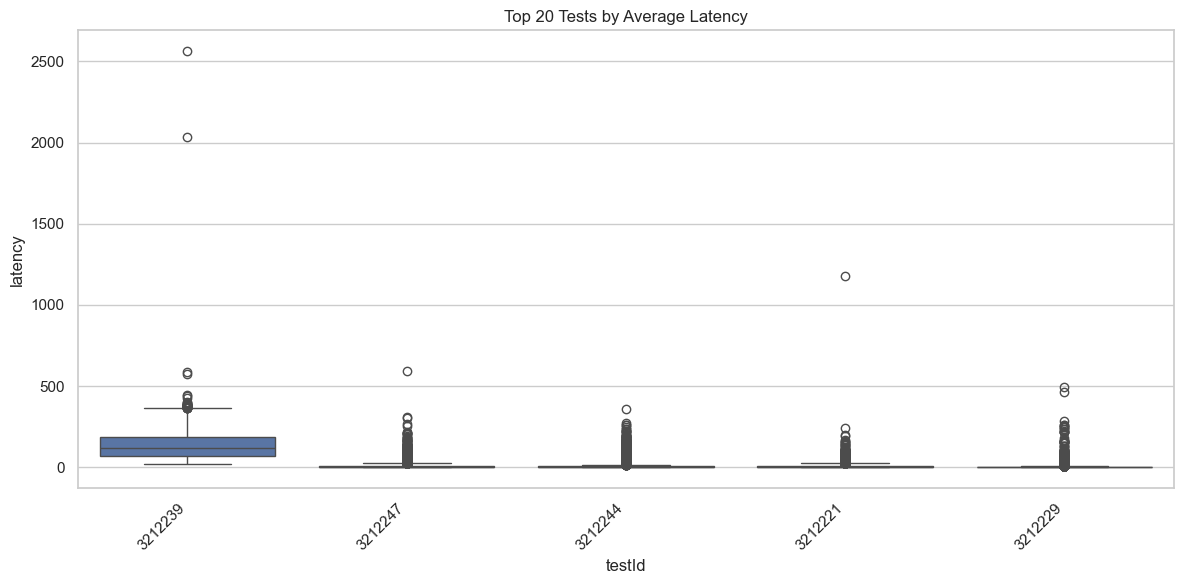

In [343]:
# Visualize Latency Distribution by Test
plt.figure(figsize=(12, 6))
sns.boxplot(data=latency_subset, x='testId', y='latency', order=latency_order)
plt.title("Top 20 Tests by Average Latency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Filter Data to Include Only Top 20 Tests
To visualize distributions effectively, we subset the original data to only include the top 20 test IDs (based on average loss and latency respectively).


In [345]:
# Full sorted table for reference
print(test_stats.sort_values(by='loss', ascending=False))  # or by='latency'

    testId      loss     latency
2  3212239  0.537471  128.045843
3  3212244  0.072069   10.937131
4  3212247  0.055648   12.023083
0  3212221  0.037710   10.366178
1  3212229  0.028951    5.932597


### Noteworthy Observation

From the analysis, `testId = 3212239` stands out as one of the worst-performing tests:
- It ranks among the top in average **loss** and **latency**.
- The box plots show high variability and/or frequent outliers.
- This test should be prioritized for deeper investigation.


In [347]:
# Handle Missing Values
ping_df = ping_df.dropna(subset=['loss', 'latency'])  # Drop rows with NaN values

Handle Missing Values in Loss and Latency: 
Before performing statistical or visual analyses, we remove any rows with missing values (`NaN`) in the `loss` or `latency` columns. This ensures that subsequent calculations like averages and correlations are accurate and not skewed by incomplete data.


Correlation matrix:
              loss   latency
loss     1.000000  0.042499
latency  0.042499  1.000000
Correlation matrix:
              loss   latency
loss     1.000000 -0.026196
latency -0.026196  1.000000


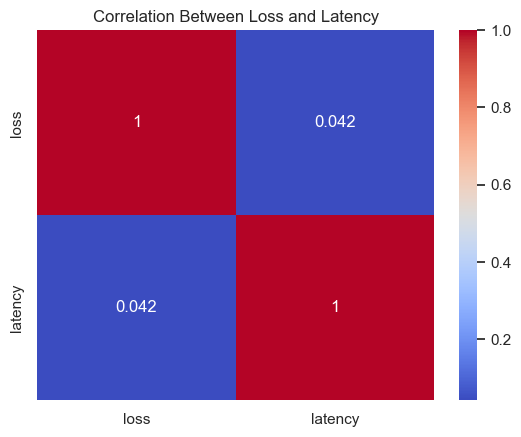

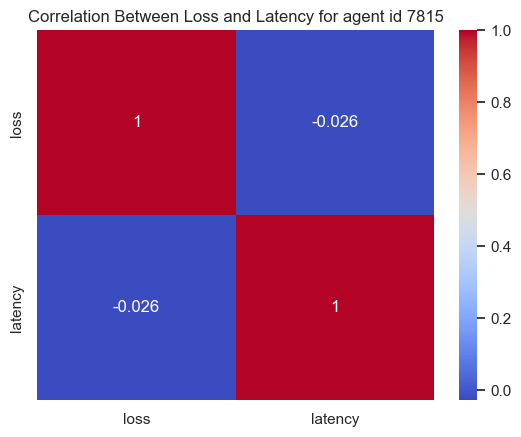

In [349]:
# lets analyze the correlation between loss and latency and for one agent ID 7815.
# Correlation matrix
correlation_matrix = ping_df[['loss', 'latency']].corr()
print("Correlation matrix:\n", correlation_matrix)

#Coorelation matrix for agent ID 7815
correlation_matrix_agent = ping_df[ping_df['vAgentId'] == 7815][['loss', 'latency']].corr()
print("Correlation matrix:\n", correlation_matrix_agent)

# Heatmap for correlation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Loss and Latency")
plt.show()

# Heatmap for correlation
sns.heatmap(correlation_matrix_agent, annot=True, cmap='coolwarm')
plt.title("Correlation Between Loss and Latency for agent id 7815")
plt.show()

### Summary of Findings

Based on the analysis above, we observed that certain `testId`s and `vAgentId`s consistently exhibit high outlier values in both **latency** and **packet loss** when accessing Spotify services. These anomalies likely correspond to periods of **network degradation** or **localized outages**, evidenced by significant spikes in the associated metrics.

While it was initially hypothesized that high latency and high loss might be correlated for specific agents, our analysis of `agentId = 7815` did **not** show a strong correlation. This suggests that **correlation analysis may not be a reliable diagnostic tool on a per-agent level**, and network issues may manifest differently across various metrics.

### Implications for Further Analysis

Unlike the Ping dataset, the HTTP dataset contains **richer feature sets** (e.g., DNS time, SSL handshake time, HTTP response codes, etc.) which can provide **finer granularity** into where exactly performance issues occur — especially **beyond just connection setup**.

This allows us to:
- Isolate issues related to DNS resolution, SSL negotiation, and server response.
- Identify specific application-layer failures even when network connectivity is intact.
- Investigate slowdowns or outages that are **not captured by ping-based metrics alone**.

**Note - After discussing internally and learing coordinator, I included HTTP metrics in the analysis. Additionally, test to test and agent to agent comparison from Thousandeyes perspective does not make sense since it could be pointing to different geo locations. Hence, in HTTP metrics I would not be including for depth analysis. Only keeping it for project analysis to show understanding of the data.**


### Data Preview and Understanding for HTTP Metrics

In [352]:
#Summary statistics
http_df.describe()

roundId       vAgentId        testId        taskId  \
count  8.639910e+05  863991.000000  8.639910e+05  8.639910e+05   
mean   1.744545e+09   40103.657257  3.212237e+06  1.165781e+07   
std    6.235430e+05  113356.616597  9.366761e+00  2.030072e+01   
min    1.743466e+09       3.000000  3.212221e+06  1.165777e+07   
25%    1.744005e+09      34.000000  3.212229e+06  1.165780e+07   
50%    1.744546e+09     273.000000  3.212239e+06  1.165782e+07   
75%    1.745086e+09   27665.000000  3.212244e+06  1.165782e+07   
max    1.745625e+09  639001.000000  3.212247e+06  1.165783e+07   

       timing_connect     timing_dns  timing_firstbyte  timing_receive  \
count   855712.000000  856714.000000     853319.000000   853287.000000   
mean        13.063317      53.370718        275.889746       11.752516   
std         48.191275     140.150423        304.987363       43.303199   
min          0.159000       0.015000         12.864000        0.017000   
25%          1.111000       0.620000         76.423000        0.206000   
50%          2.281000       9.485000        182.214000        0.693000   
75%          9.601000      46.403000        374.042995        3.859000   
max       3397.464000    4899.780762       4979.820001     4216.263000   

       timing_redirect    timing_send     timing_ssl   timing_total  \
count    315315.000000  855704.000000  855704.000000  853287.000000   
mean        427.127684       0.246264      32.572372     287.594283   
std         423.290177       0.154830      59.726896     314.246274   
min          18.972000       0.089000       1.523000      13.330000   
25%         127.221500       0.181000       6.108000      78.852000   
50%         261.406998       0.223000      12.111000     187.695000   
75%         637.237000       0.285000      36.030000     390.373501   
max        4993.339000      38.334000    4921.736000    4977.757100   

         timing_wait          tput        curlret   responsecode  
count  853319.000000  3.654720e+05  863991.000000  853318.000000  
mean      176.863238  5.234963e+06       0.109449     200.266158  
std       236.860056  5.367423e+06       1.743480       8.957263  
min         0.230000  0.000000e+00       0.000000     200.000000  
25%        44.786000  8.890870e+05       0.000000     200.000000  
50%       104.619000  3.134387e+06       0.000000     200.000000  
75%       208.421500  7.798182e+06       0.000000     200.000000  
max      4920.108000  3.605100e+07      35.000000     504.000000

We start by reviewing the structure and basic statistics of the HTTP dataset (`http_df`). This includes checking column names, and summary statistics. This step helps us identify which fields are numeric, which contain missing values, and which are suitable for analysis. Thousandeyes research team gave me an understanding of the timing_firstbyte and timing_total columns which are as follows: 
```
timing_firstbyte = timing_dns + timing_connect + timing_ssl (optional) + timing_send + timing_wait
timing_total     = timing_dns + timing_connect + timing_ssl (optional) + timing_send + timing_wait + timing_receive
```

In [354]:
#Lets analyze the HTTP data for now
# How many unique tests, agents do we have? How many rounds of measurements do we have?
print(http_df['roundId'].nunique(), "unique roundIds")
print(http_df['vAgentId'].nunique(), "unique vAgentIds")
print(http_df['testId'].nunique(), "unique testIds")
print(http_df['taskId'].nunique(), "unique taskIds")

7200 unique roundIds
38 unique vAgentIds
5 unique testIds
5 unique taskIds


### Dataset Scope and Measurement Coverage

We begin the analysis by understanding the scope and granularity of the HTTP dataset:

- **7,200 unique `roundId`s** indicate the number of individual measurement rounds (i.e., HTTP checks or probes). This provides a solid temporal depth for trend analysis and variability assessment.
- **38 unique `vAgentId`s** represent the different agents (measurement points), which likely span various geographic or network locations.
- **5 unique `testId`s** and **5 `taskId`s** suggest that the dataset covers a small set of distinct test configurations — each potentially targeting different endpoints, protocols, or behaviors.


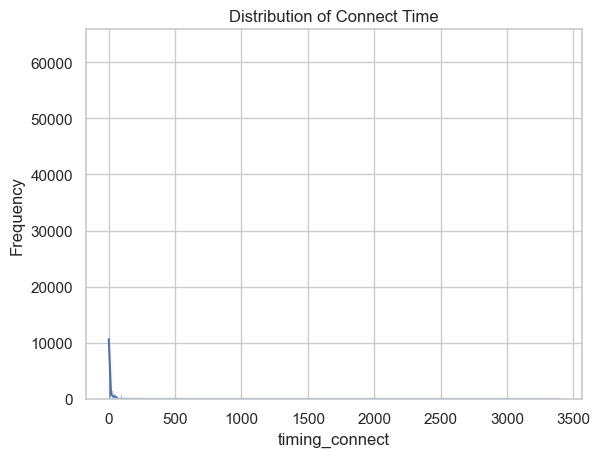

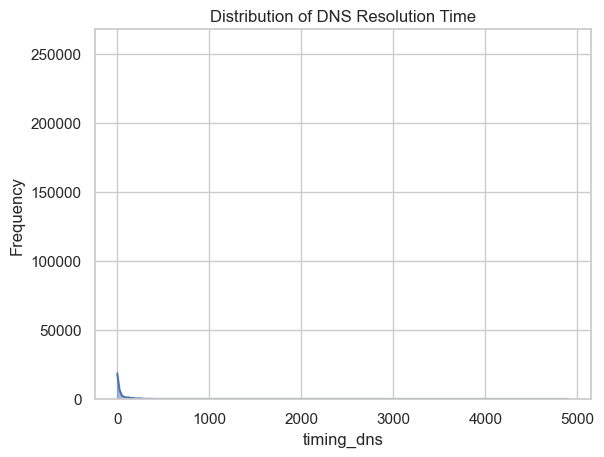

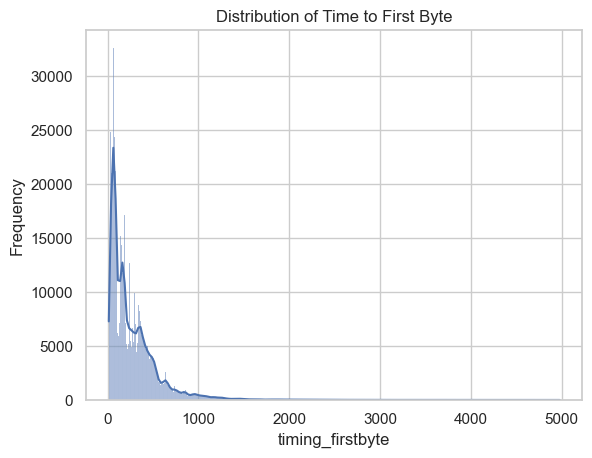

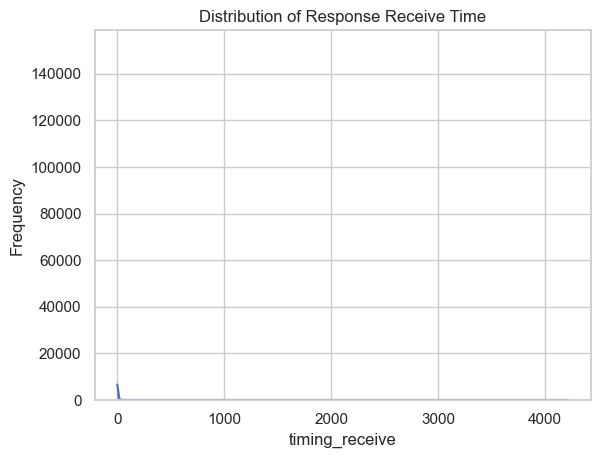

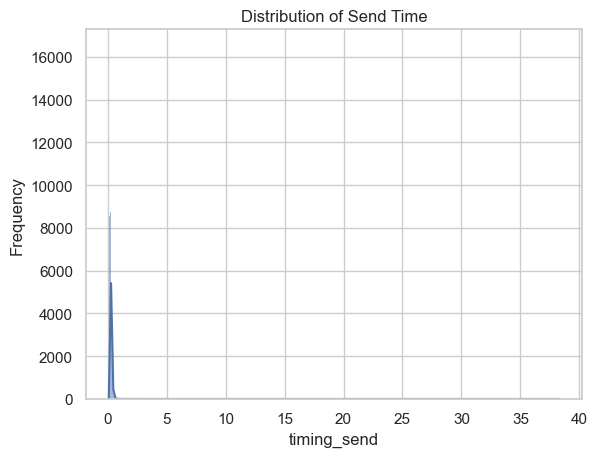

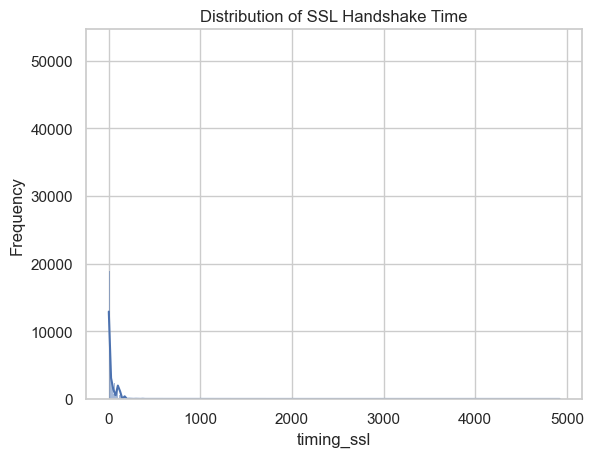

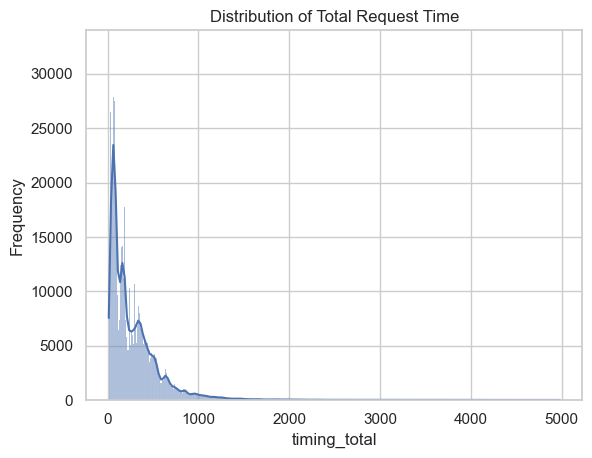

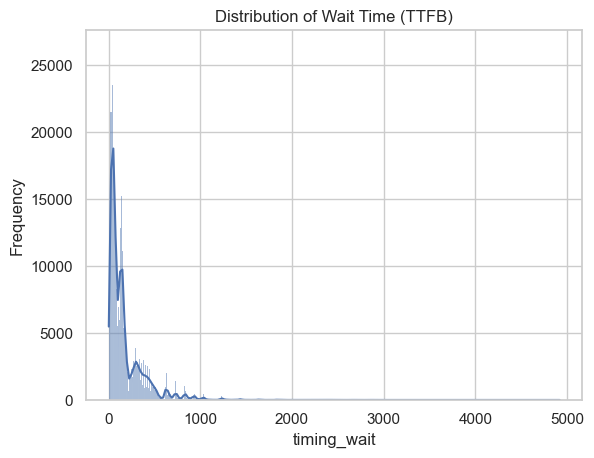

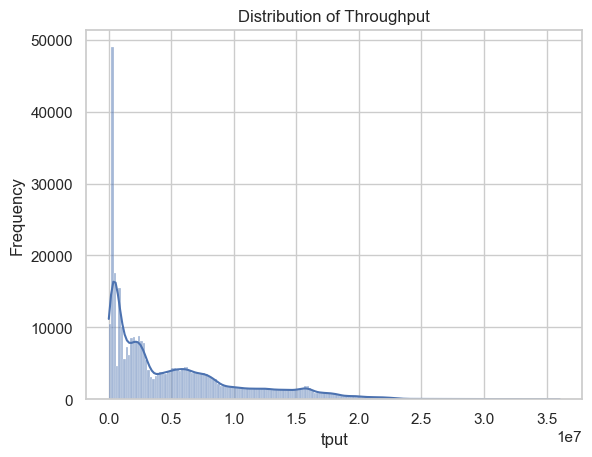

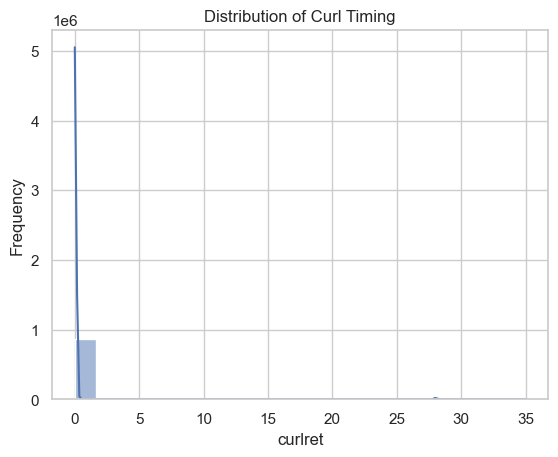

In [356]:
# Define columns to plot and their corresponding titles
timing_columns = {
    'timing_connect': 'Distribution of Connect Time',
    'timing_dns': 'Distribution of DNS Resolution Time',
    'timing_firstbyte': 'Distribution of Time to First Byte',
    'timing_receive': 'Distribution of Response Receive Time',
    'timing_send': 'Distribution of Send Time',
    'timing_ssl': 'Distribution of SSL Handshake Time',
    'timing_total': 'Distribution of Total Request Time',
    'timing_wait': 'Distribution of Wait Time (TTFB)',
    'tput': 'Distribution of Throughput',
    'curlret': 'Distribution of Curl Timing',
}

# Loop through the columns and plot
for col, title in timing_columns.items():
    if col in http_df.columns:
        sns.histplot(http_df[col], kde=True)
    elif col in ping_df.columns:
        sns.histplot(ping_df[col], kde=True)
    else:
        print(f"Column '{col}' not found in either dataframe.")
        continue
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

### Analysis of Performance Metrics Distributions

The provided charts visualize the distributions of various performance metrics, primarily focusing on network timing, throughput, and curl timing.

1. Timing Distributions (Connect, DNS, First Byte, Response Receive, SSL Handshake, Total Request, Wait)

For almost all timing-related metrics (Connect Time, DNS Resolution Time, Time to First Byte, Response Receive Time, SSL Handshake Time, Total Request Time, and Wait Time), the distributions are heavily right-skewed. A very large majority of requests complete with extremely fast times. For instance, most connections, DNS resolutions, and SSL handshakes occur within the first few hundred milliseconds (e.g., under 500ms). This indicates highly efficient general operation.
Long Tails: Despite the high concentration at low values, there are noticeable "long tails" extending to higher values (e.g., up to 3000-5000ms). This suggests that a small percentage of requests experience significantly longer delays, which could be due to network latency, server load, or specific request complexities.
Send Time Anomaly: The "Distribution of Send Time" is exceptionally concentrated at very low values (mostly under 5ms), with a very short tail. This indicates that the time taken to send data is consistently minimal for almost all requests.

2. Throughput Distribution

The "Distribution of Throughput" shows a different pattern compared to timing metrics. While also right-skewed, the values on the x-axis are much larger (up to 3.5e7).
Most throughput values are concentrated at the lower end, indicating that a large number of operations involve lower data transfer rates. However, there's a spread suggesting that some operations achieve significantly higher throughput.

Summary

In summary, the system generally demonstrates excellent performance with most operations completing very quickly and successfully. The presence of long tails in timing distributions warrants further investigation into the small percentage of requests that experience significant delays to understand potential bottlenecks or specific scenarios. The high success rate of curl operations is a positive indicator of system reliability.

### Plotting Configuration for categorical columns

We originally had plotted multiple categorical columns some of which were cardinal. That's why we defined the function, however it only made sense to plot the response code. 

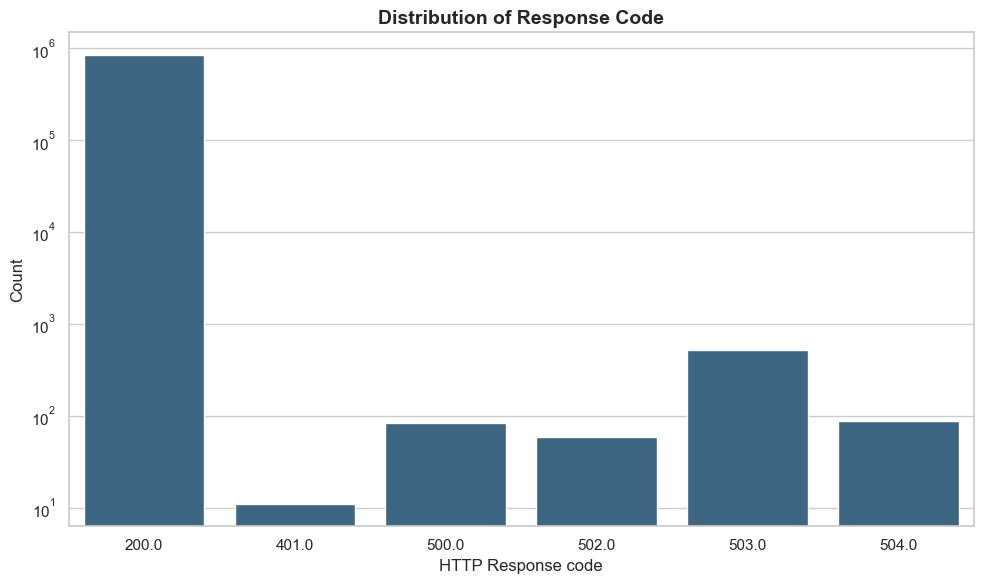

In [359]:
plot_configs = [
    {'col': 'responsecode', 'title': 'Distribution of Response Code', 'xlabel': 'HTTP Response code', 'log_scale': False},
]

# Global Plotting Settings
sns.set_style("whitegrid")
# Using a specific palette for consistency
palette = sns.color_palette("viridis", n_colors=len(plot_configs) + 1) # +1 for curl codes if needed

def plot_categorical_distribution(df, col_name, title, xlabel, color=None):
    """
    Plots the distribution of a categorical column using seaborn.countplot.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        col_name (str): The name of the categorical column to plot.
        title (str): The title of the plot.
        xlabel (str): The label for the x-axis.
        color (str): Color for the bars. If None, seaborn default is used.
    """
    if col_name not in df.columns:
        print(f"Warning: Column '{col_name}' not found in DataFrame. Skipping plot.")
        return

    plt.figure(figsize=(10, 6))
    ax=sns.countplot(data=df, x=col_name, color=color)

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    ax.set_yscale('log')
    plt.tight_layout()
    plt.show()

# Generate all plots using the enhanced functions ---
for i, config in enumerate(plot_configs):
    plot_categorical_distribution(
        http_df,
        col_name=config['col'],
        title=config['title'],
        xlabel=config['xlabel'],
        color=palette[i] # Use a distinct color from the palette
    )


### Key Observations from the Response code:

* 200 - success
* 401 - Unauthorized
* 500 - Internal Server Error
* 502 - Bad Gateway
* 503 - Service Unavailable
* 504 - Gateway timeout

From the data, it shows majority of success and service unavailable. We also have a lot of bad gateway, internal server errors and gateway timeout. It seems majority of true outages would be either 500, 502, 503 and 504 response codes.


### Agent specfic analysis HTTP Analysis

This section visualizes HTTP timing metrics collected from various agents (vAgentId) to identify discrepancies in performance characteristics. Each boxplot illustrates the distribution of a particular timing metric, such as DNS resolution, connection time, or time to first byte (TTFB), across different agents.

**NOTE: After checking with my colleague, we found out that different agents are in different geographical location so it does not make sense to do agent to agent or test to test comparison. However, for this project, I kept the analysis to show understanding with the data.**

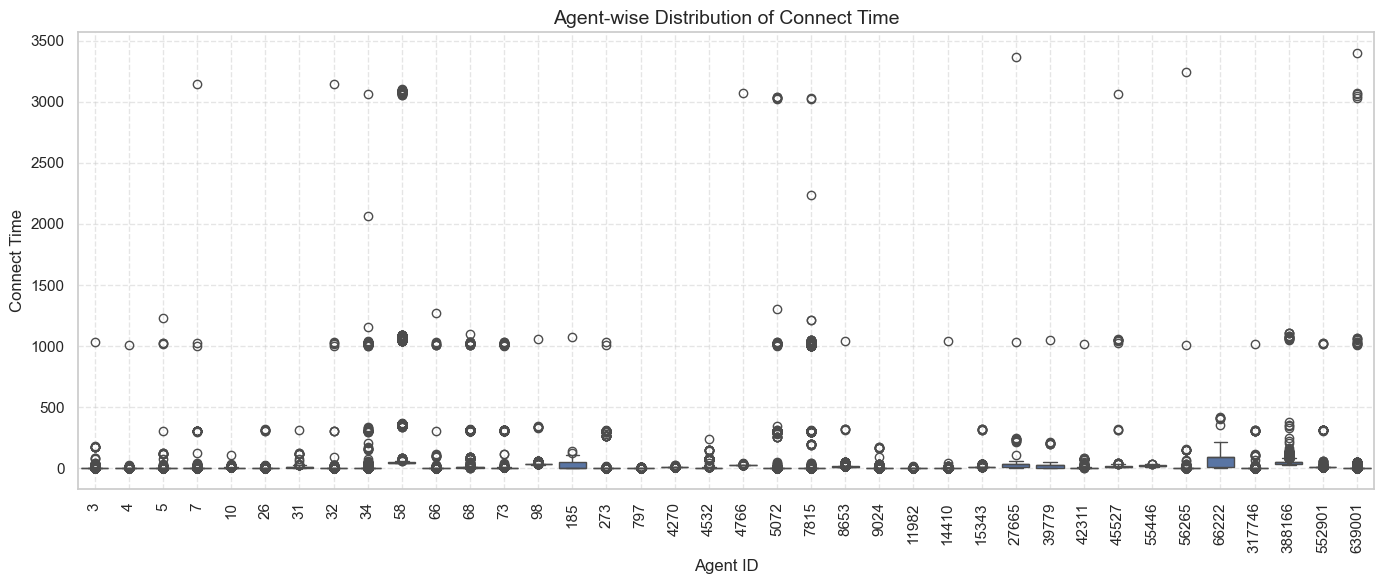

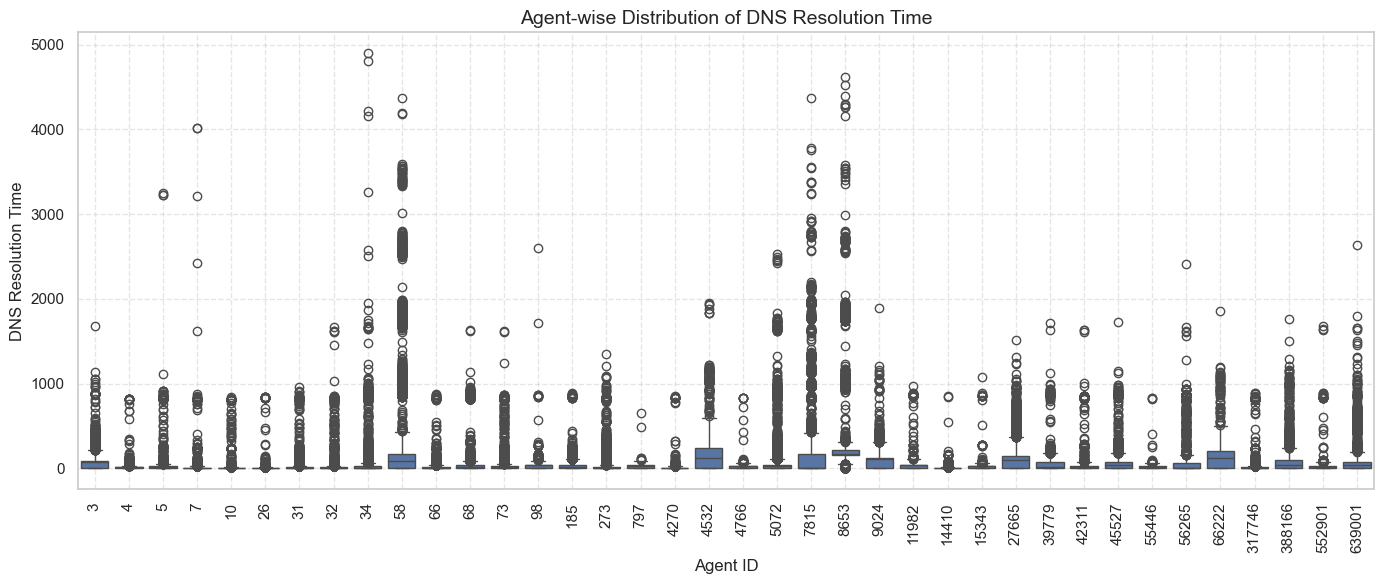

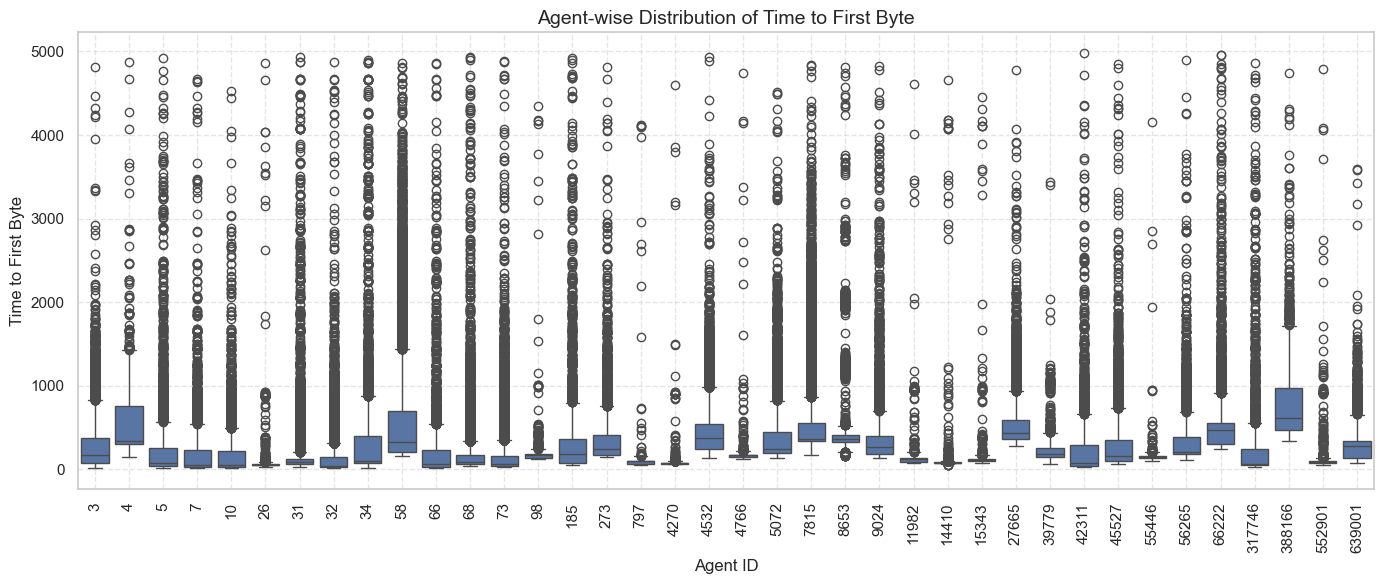

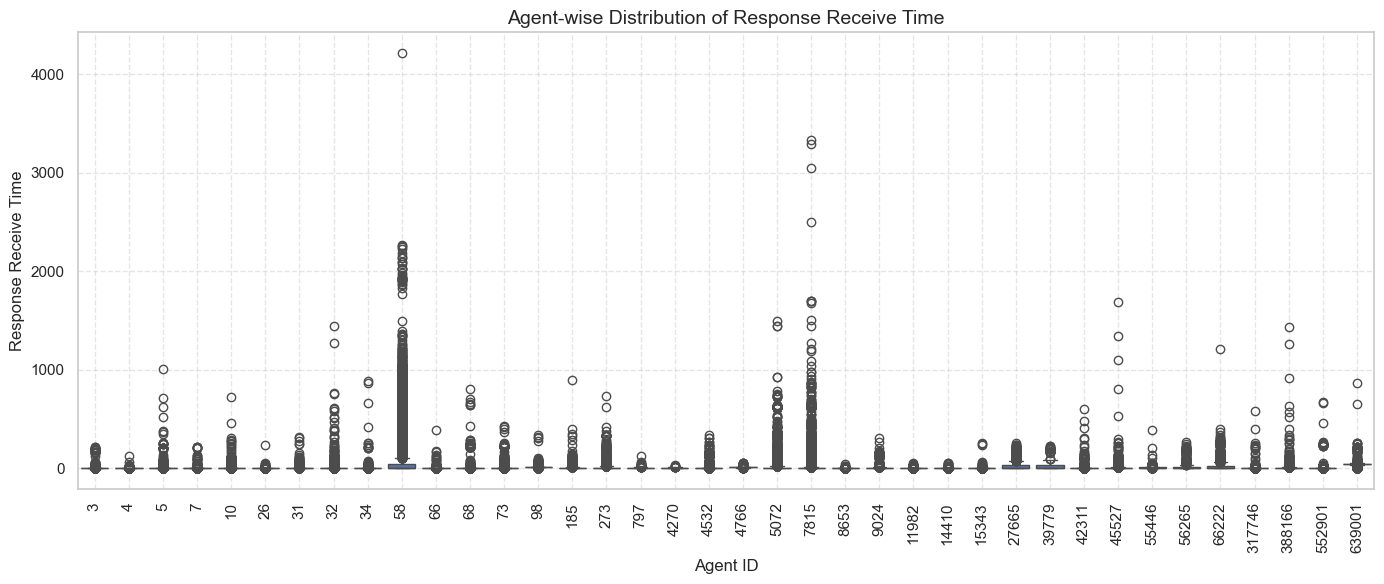

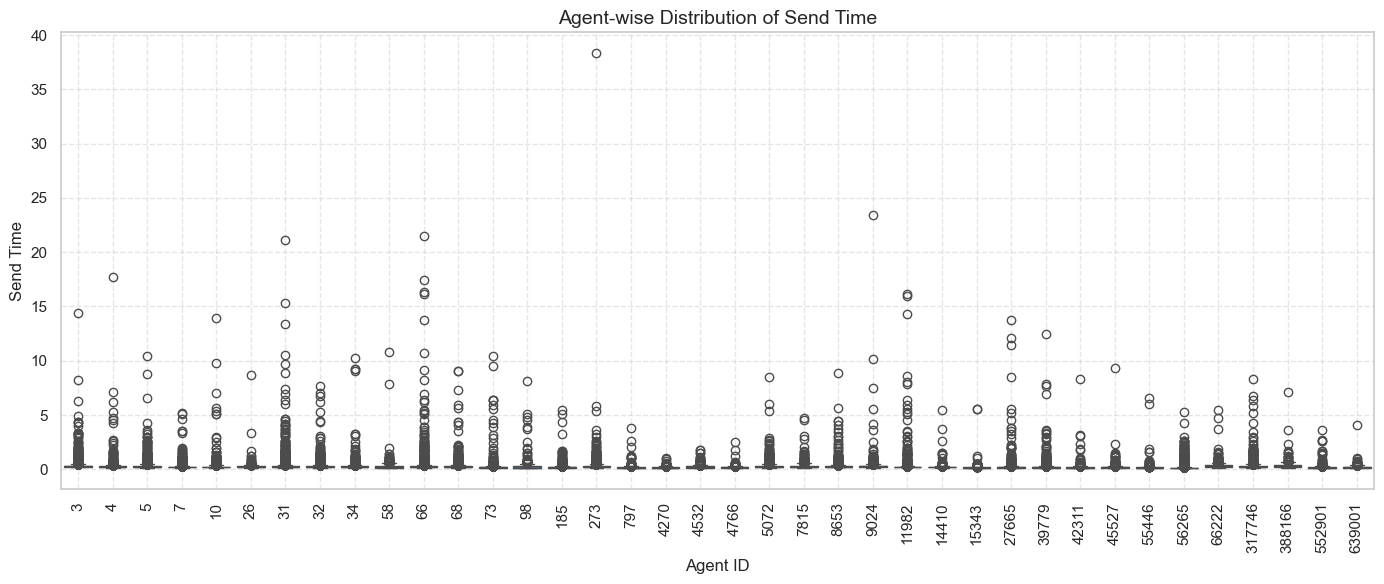

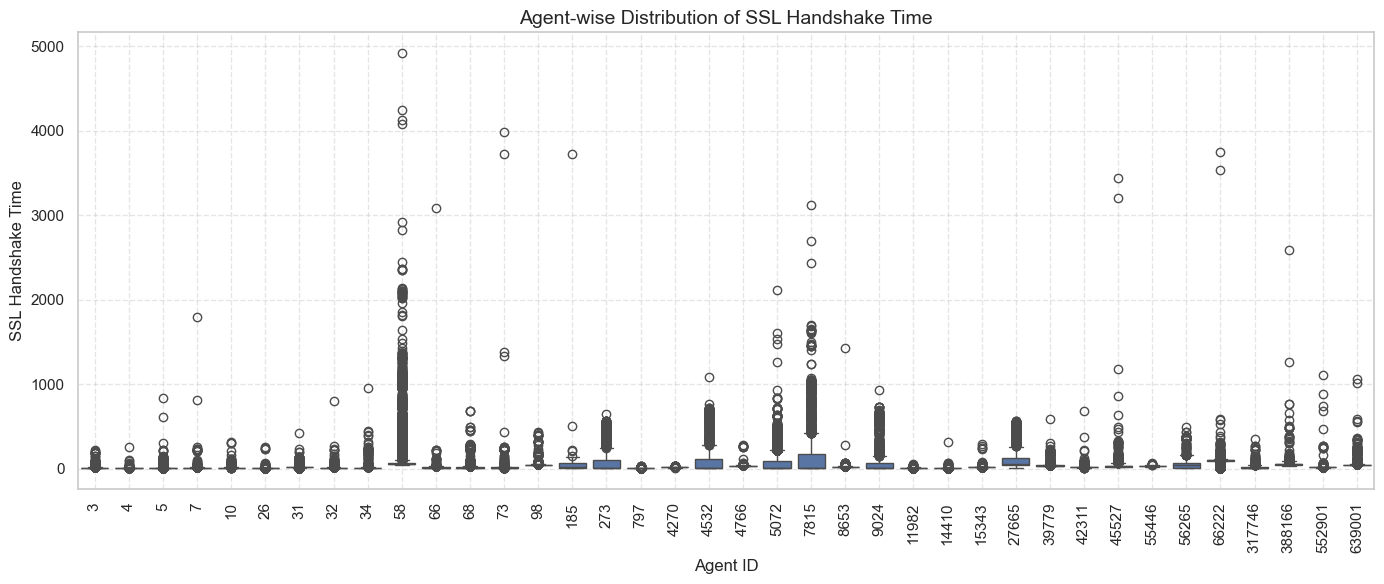

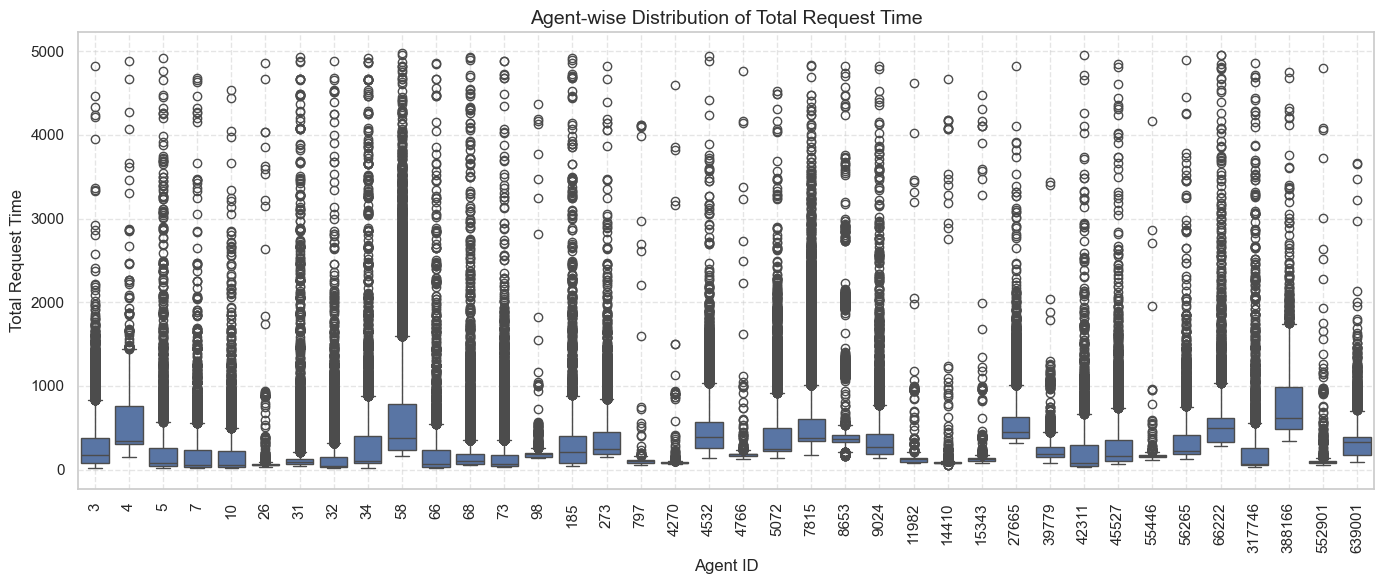

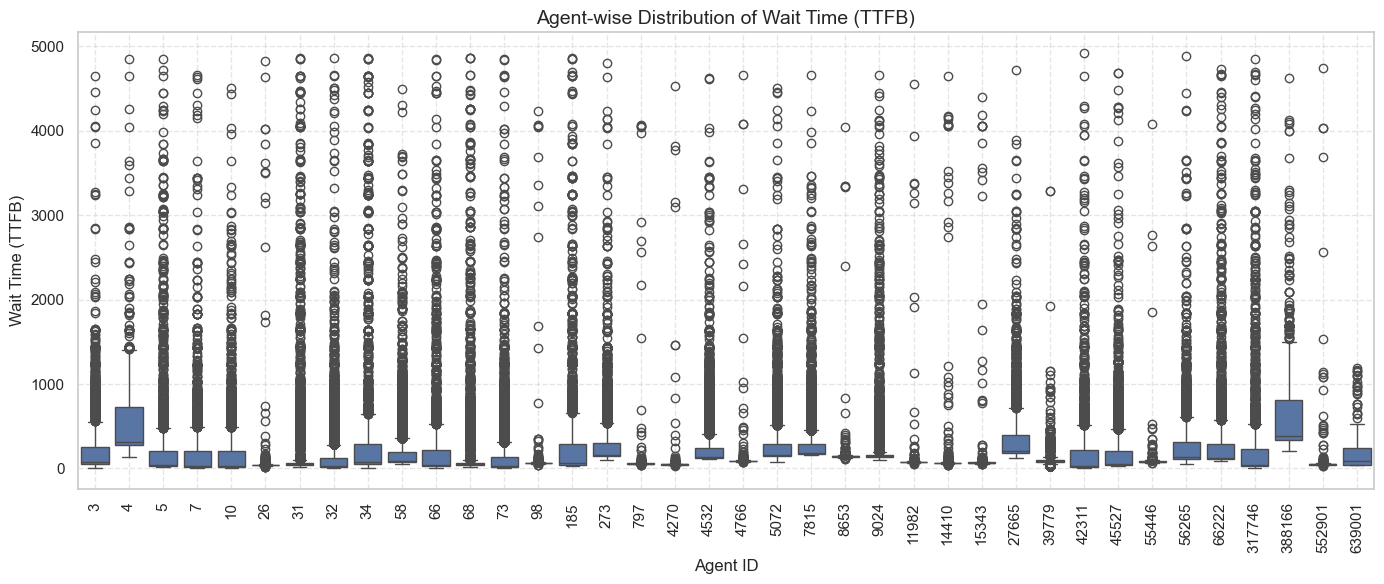

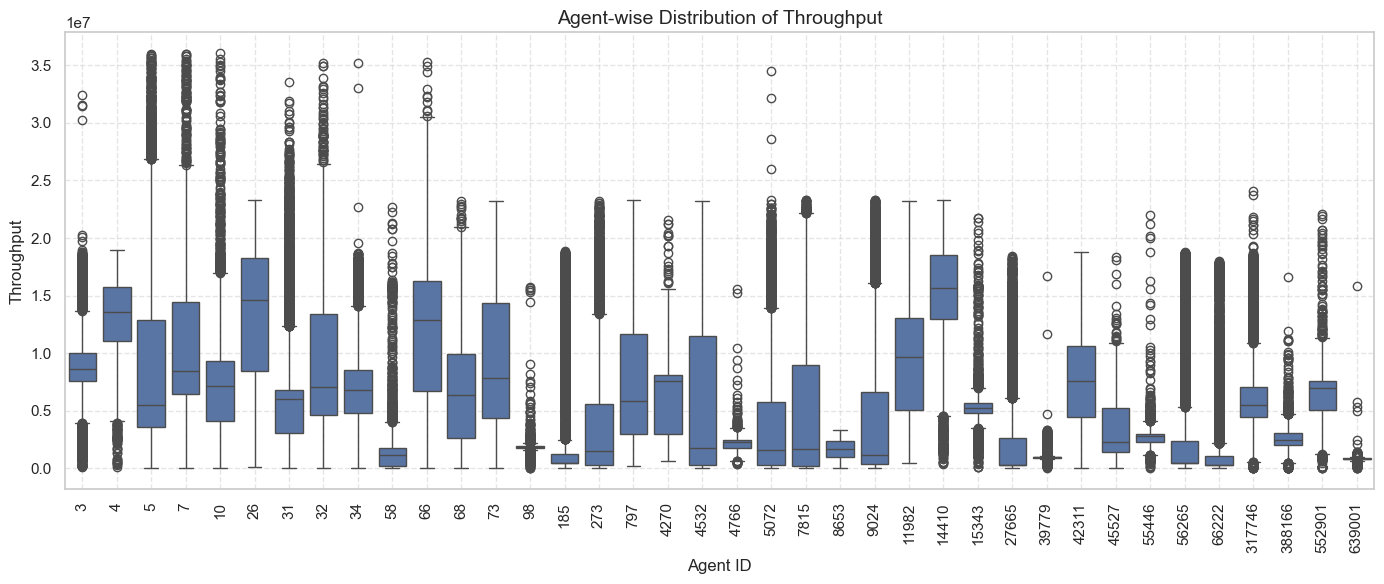

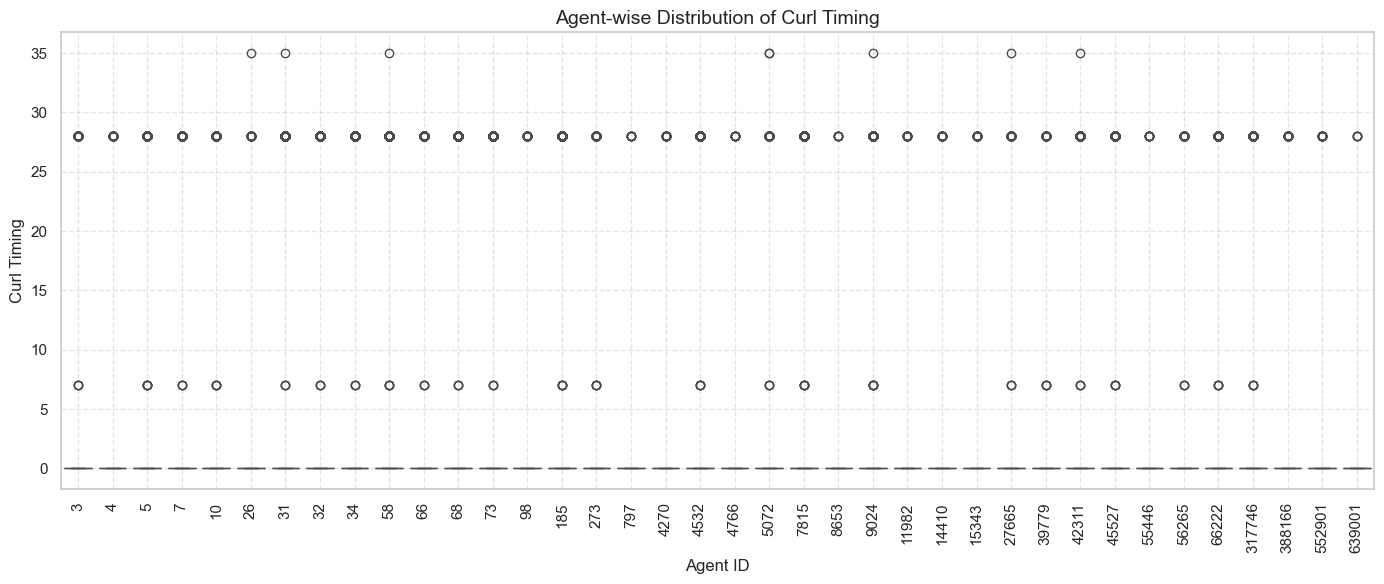

In [362]:
# Apply a cleaner theme
sns.set(style="whitegrid")

# Define timing-related columns and their descriptive titles
timing_columns = {
    'timing_connect': 'Connect Time',
    'timing_dns': 'DNS Resolution Time',
    'timing_firstbyte': 'Time to First Byte',
    'timing_receive': 'Response Receive Time',
    'timing_send': 'Send Time',
    'timing_ssl': 'SSL Handshake Time',
    'timing_total': 'Total Request Time',
    'timing_wait': 'Wait Time (TTFB)',
    'tput': 'Throughput',
    'curlret': 'Curl Timing',
}

# Determine unique agents in order for consistent x-axis
agent_order = sorted(http_df['vAgentId'].unique())

# Plotting
for col, label in timing_columns.items():
    data = None
    if col in http_df.columns:
        data = http_df
    elif col in ping_df.columns:
        data = ping_df
    else:
        print(f"Column '{col}' not found in either dataframe.")
        continue

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=data, x='vAgentId', y=col, order=agent_order)
    plt.title(f"Agent-wise Distribution of {label}", fontsize=14)
    plt.xlabel("Agent ID")
    plt.ylabel(label)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


Significant variation in metrics like `Total Request Time` or `SSL Handshake Time` is indicating network or configuration issues on specific agents. However, we are not performing agent to agent comparison as indicated above.


### Test-Specific HTTP Timing Analysis
This section investigates how HTTP performance metrics vary across different test IDs, helping identify performance inconsistencies tied to specific tests or monitored URLs. However, this analysis is kept for the project purpose as test are configured across multiple regions asynchronously as confirmed by my colleague. 


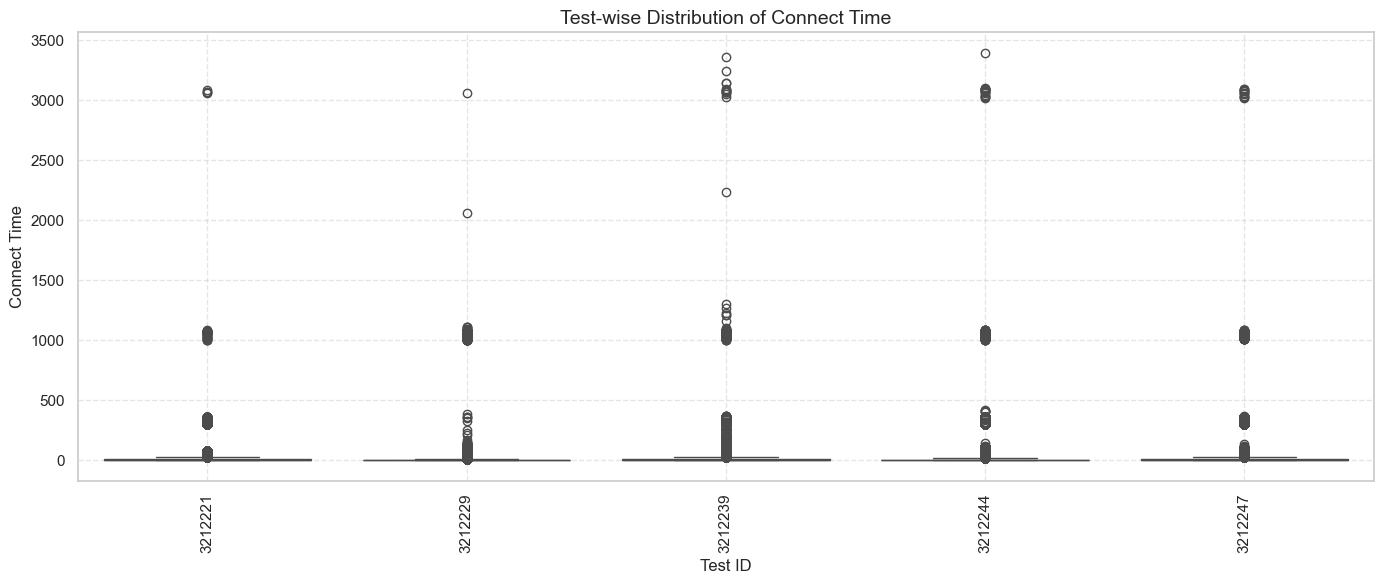

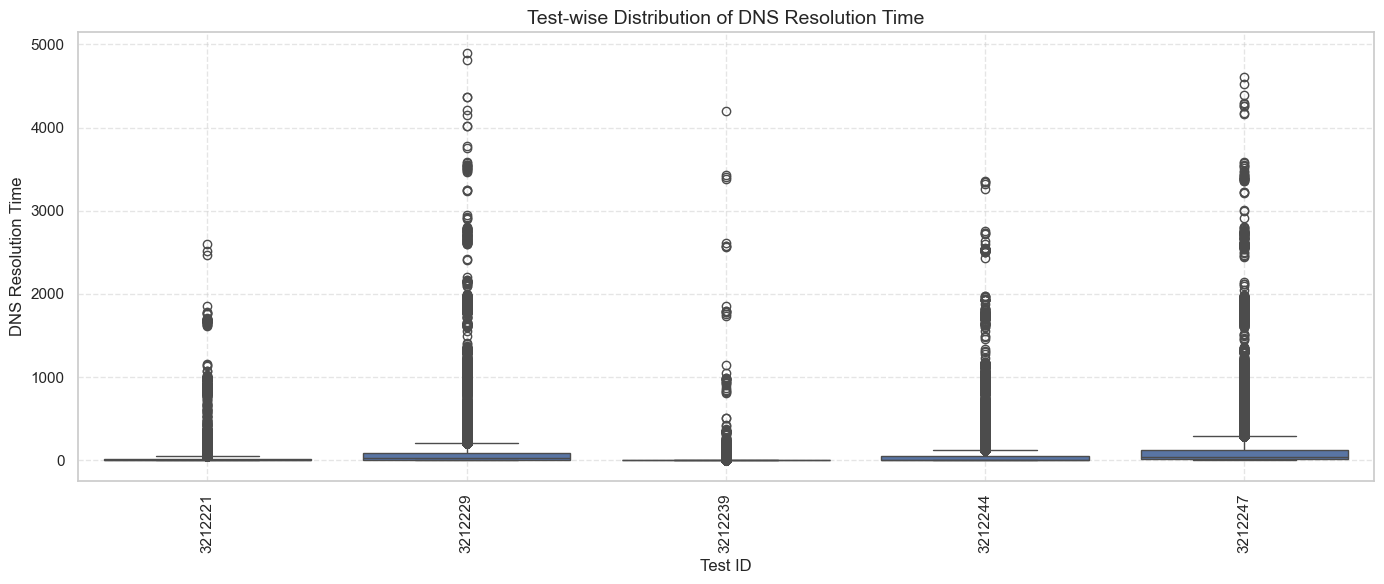

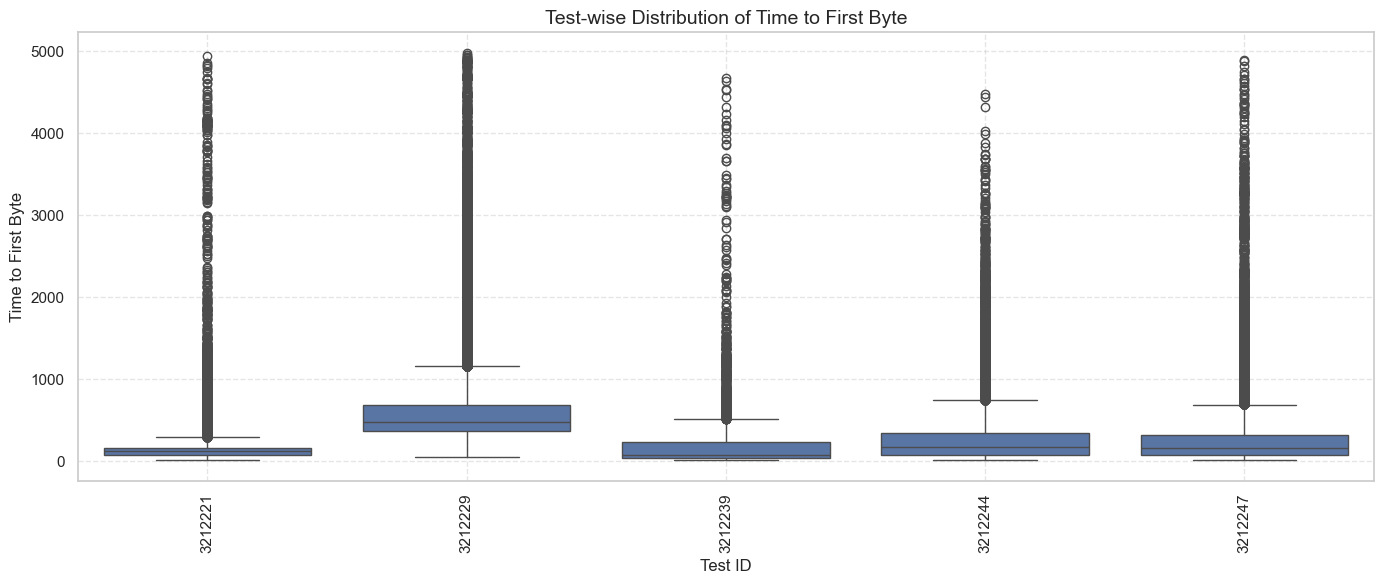

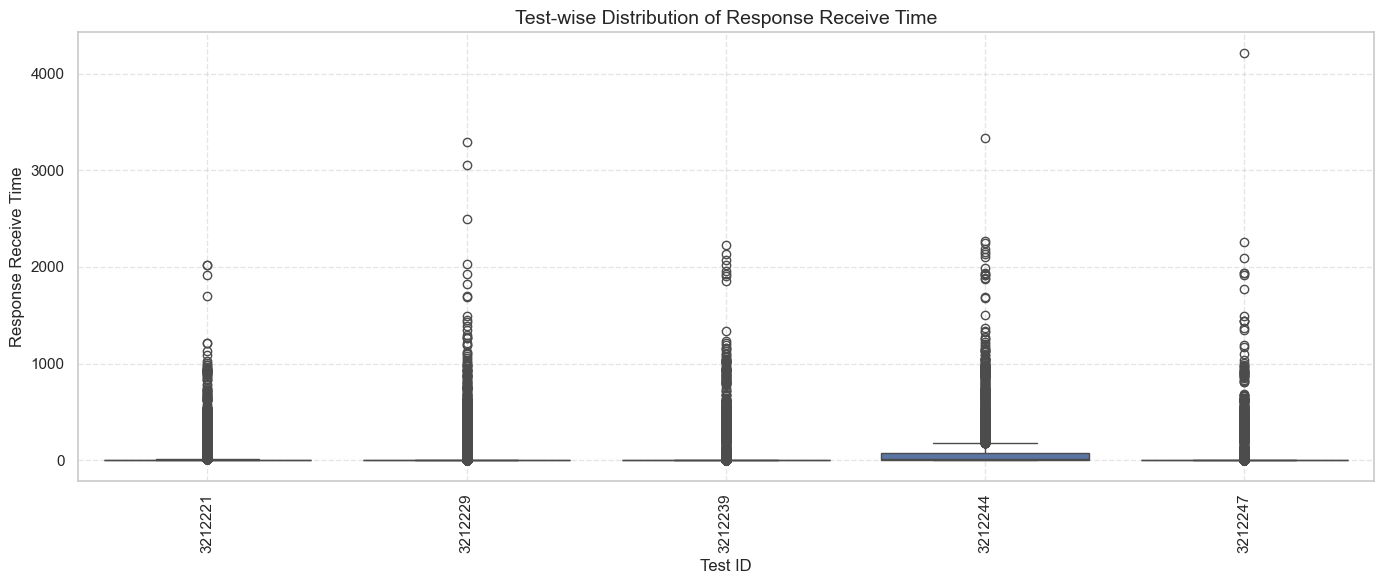

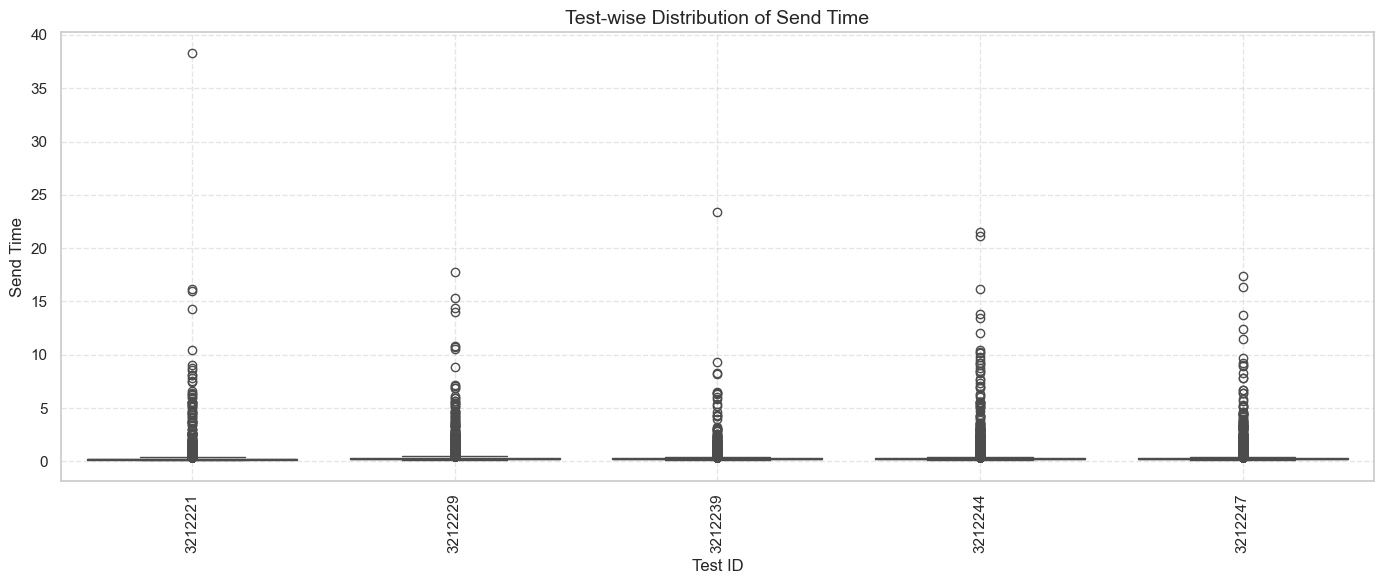

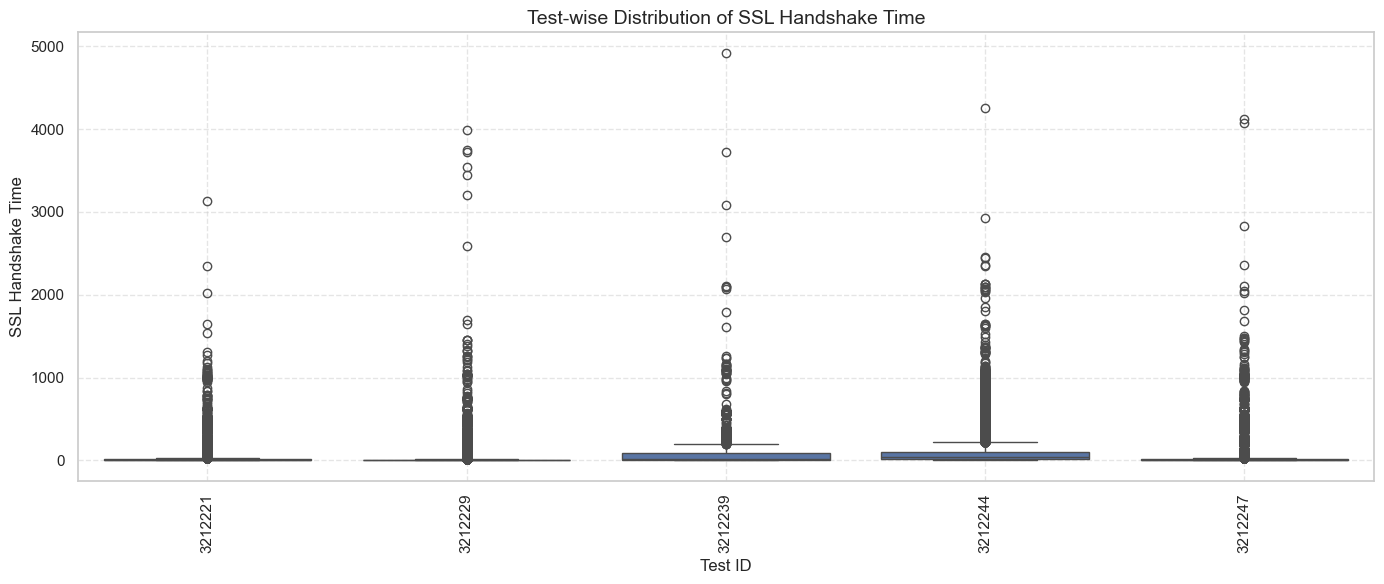

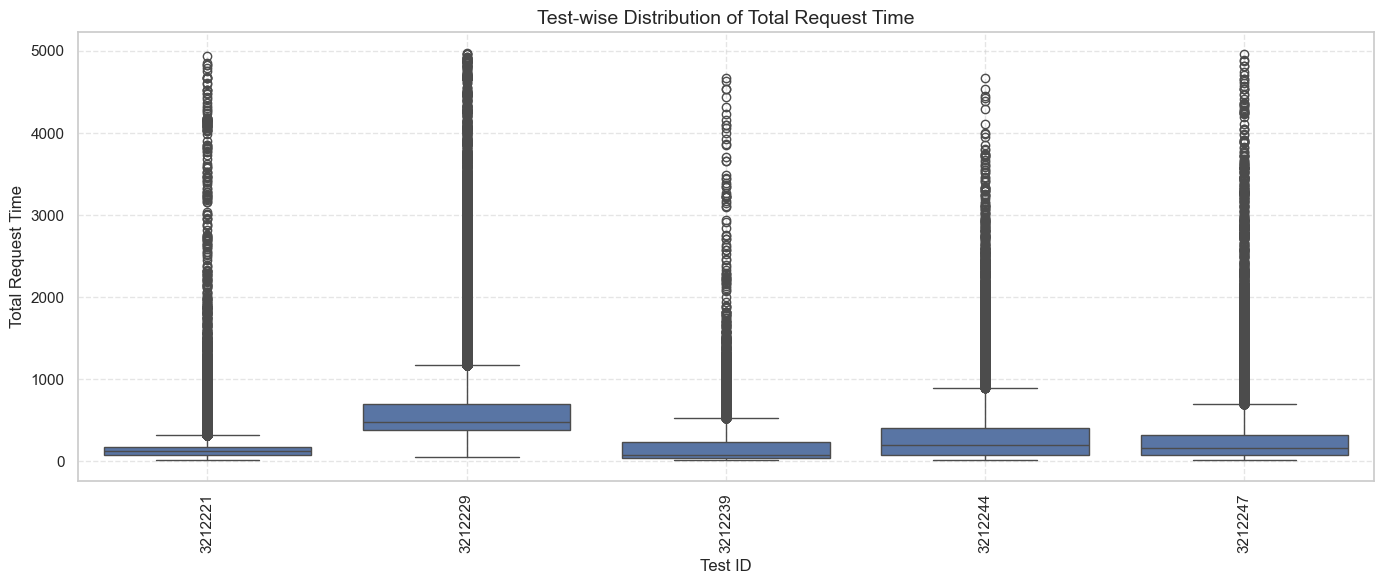

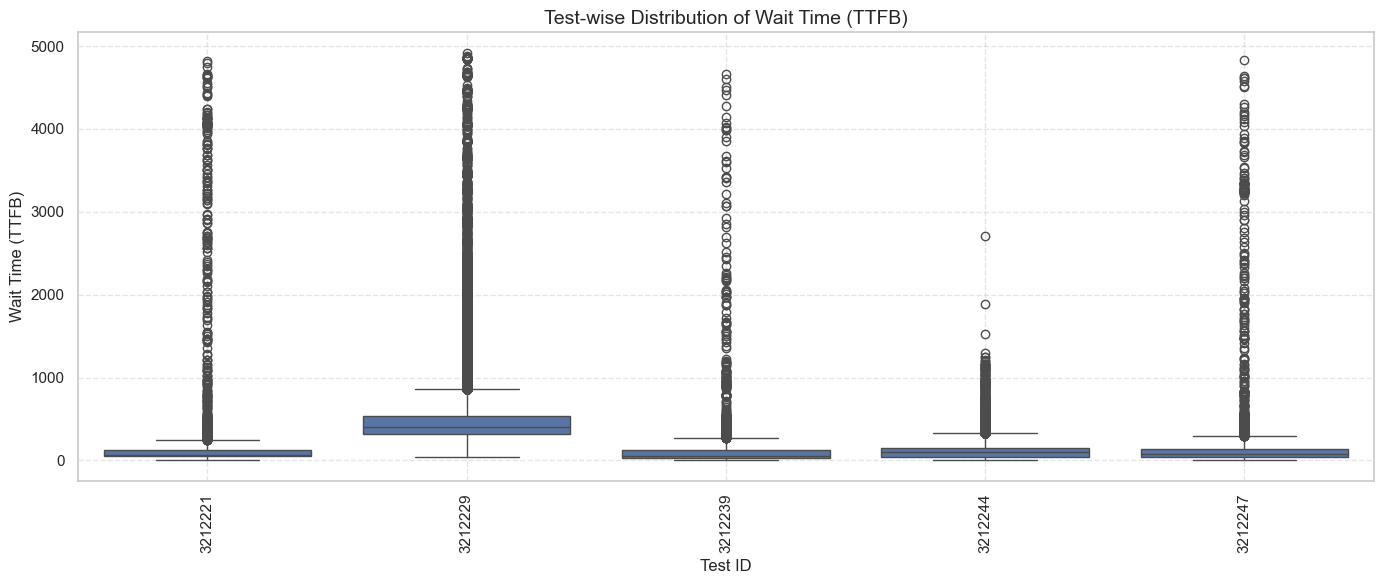

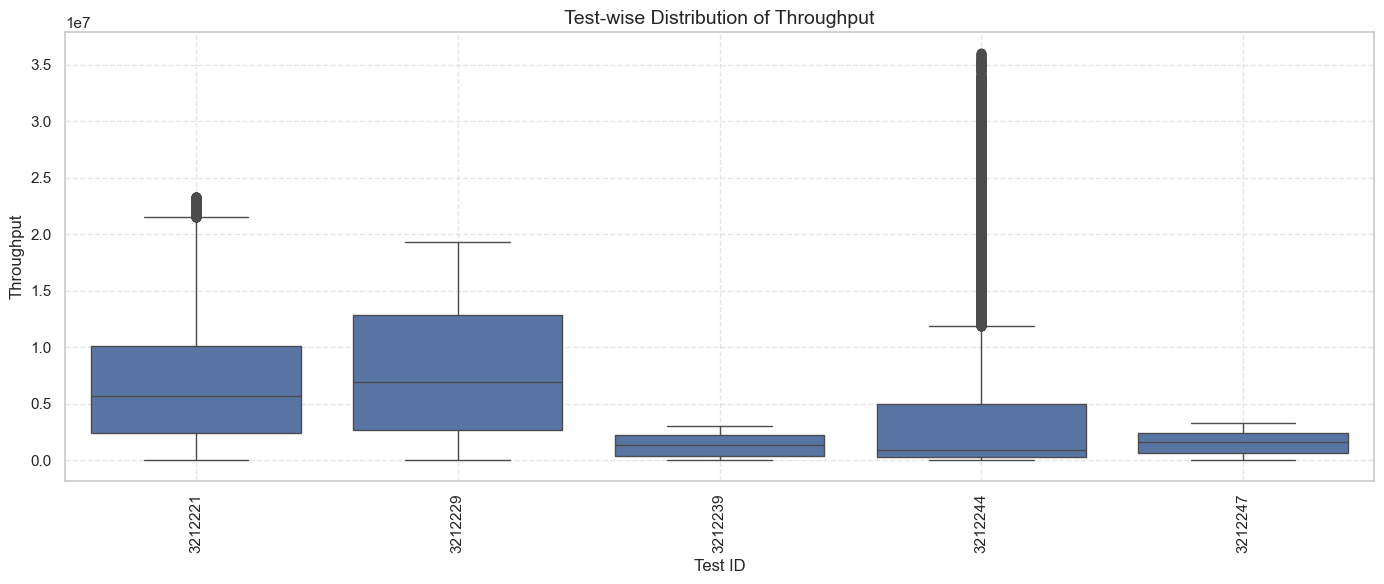

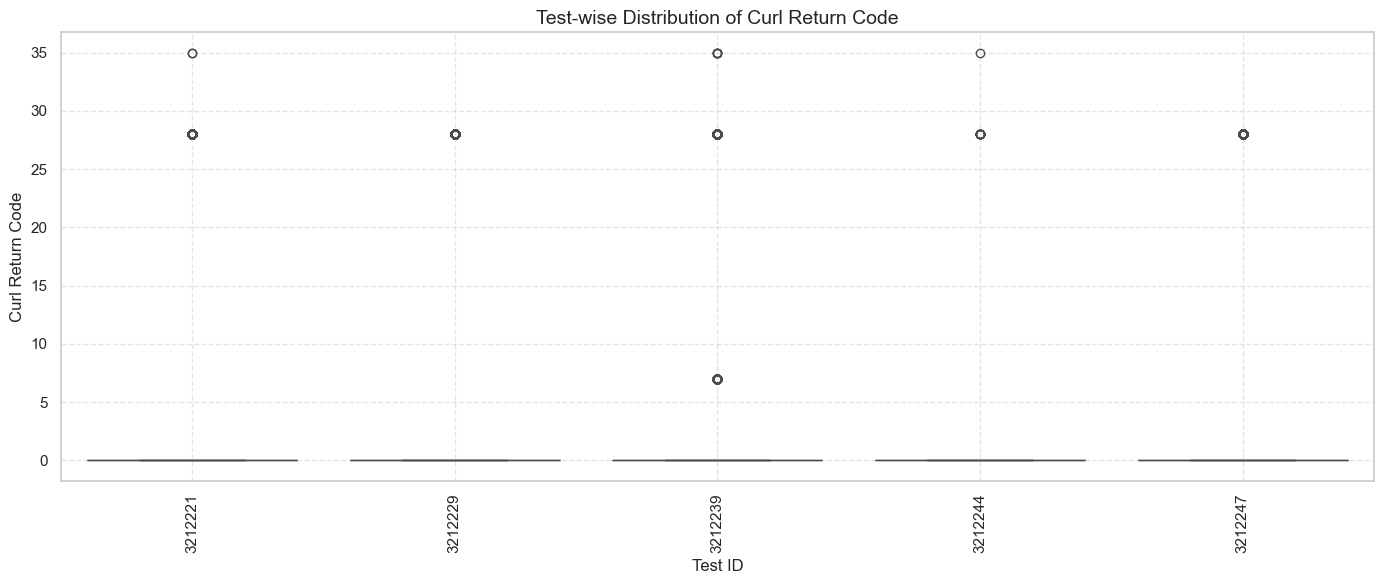

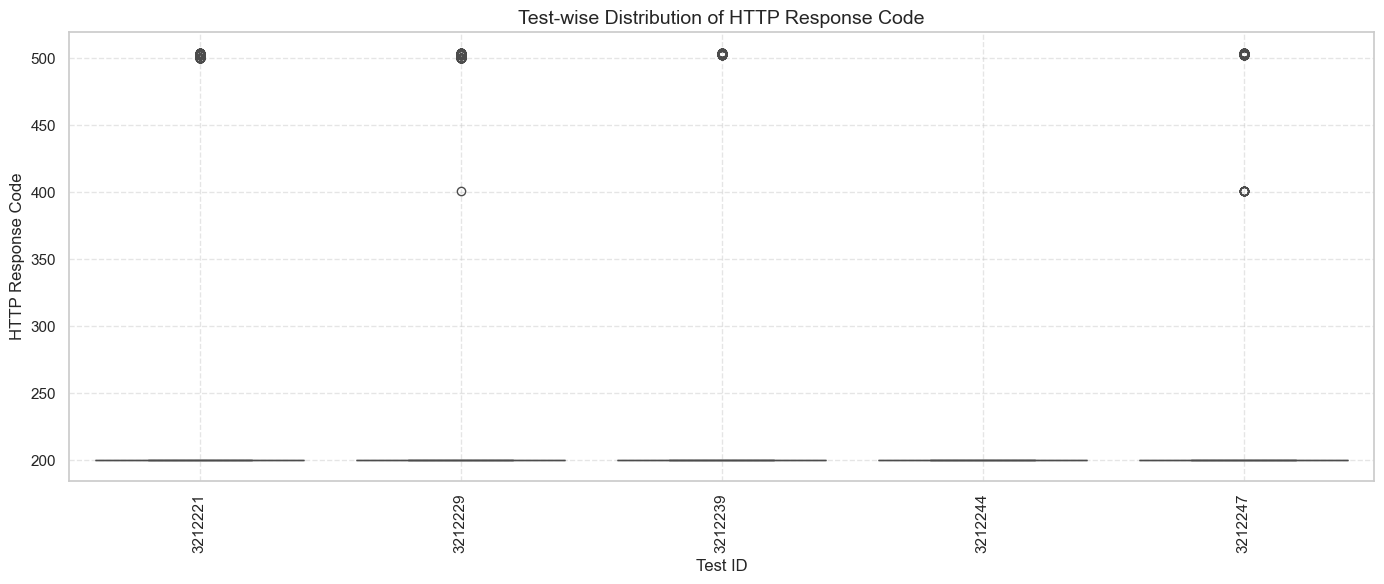

In [365]:

# Set global plot style
sns.set(style="whitegrid")

# Define timing-related columns and their descriptive titles
timing_columns = {
    'timing_connect': 'Connect Time',
    'timing_dns': 'DNS Resolution Time',
    'timing_firstbyte': 'Time to First Byte',
    'timing_receive': 'Response Receive Time',
    'timing_send': 'Send Time',
    'timing_ssl': 'SSL Handshake Time',
    'timing_total': 'Total Request Time',
    'timing_wait': 'Wait Time (TTFB)',
    'tput': 'Throughput',
    'curlret': 'Curl Return Code',
    'responsecode': 'HTTP Response Code'
}

# Get sorted unique test IDs for consistent x-axis
test_order = sorted(http_df['testId'].unique())

# Loop through each timing column and plot per testId
for col, label in timing_columns.items():
    if col in http_df.columns:
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=http_df, x='testId', y=col, order=test_order)
        plt.title(f"Test-wise Distribution of {label}", fontsize=14)
        plt.xlabel("Test ID")
        plt.ylabel(label)
        plt.xticks(rotation=90)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' not found in http_df.")


- Certain tests consistently show higher `Total Request Time`, suggesting backend slowness, large payloads, or third-party dependencies.
- `Time to First Byte (TTFB)` and `Connect Time` vary widely among tests, indicating potential differences in server responsiveness or network routing.
- A few tests demonstrate high `SSL Handshake Time`, which could point to certificate issues or TLS overhead on target services. 

### Correlation of Total Request Time with Other HTTP Metrics

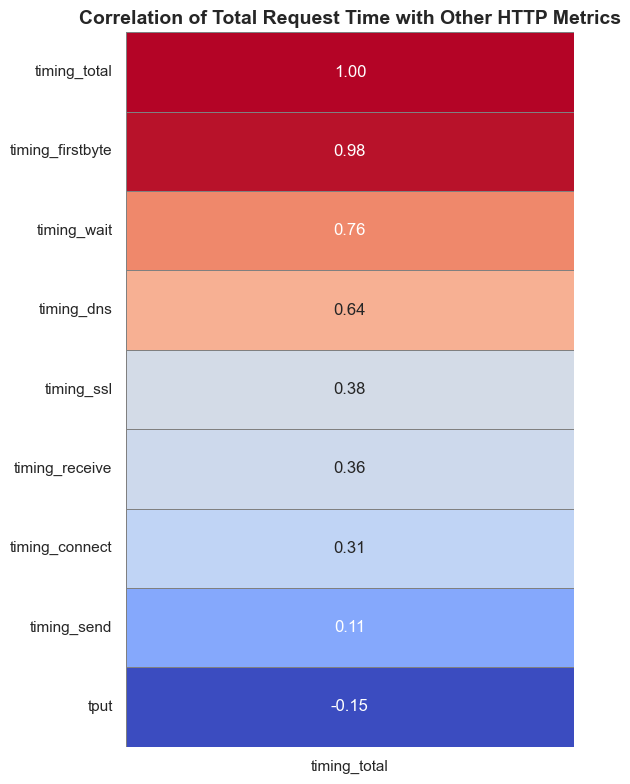

In [368]:
# lets analyze the correlation between total response time with other HTTP metrics
# Define the relevant columns
timing_columns = [
    'timing_connect',     # Connect Time
    'timing_dns',         # DNS Resolution Time
    'timing_firstbyte',   # Time to First Byte
    'timing_receive',     # Response Receive Time
    'timing_send',        # Send Time
    'timing_ssl',         # SSL Handshake Time
    'timing_total',       # Total Request Time (Target)
    'timing_wait',        # Wait Time (TTFB)
    'tput',               # Throughput
]

# Subset the HTTP data to include only relevant numeric columns and drop NaNs
correlation_data = http_df[timing_columns].dropna()

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Extract only the correlations with 'timing_total', sort by strength
correlation_with_total = correlation_matrix[['timing_total']].sort_values(by='timing_total', ascending=False)

# Plot the correlation heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(correlation_with_total, annot=True, cmap='coolwarm', fmt=".2f", cbar=False,
            linewidths=0.5, linecolor='gray')
plt.title("Correlation of Total Request Time with Other HTTP Metrics", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


### Correlation Analysis: Total Request Time vs. HTTP Timing Components

timing_firstbyte a very strong positive correlation (0.98) with timing_total, suggesting that the time to receive the first byte is a major component or indicator of the total request time. 
timing_wait (0.76) and timing_dns (0.64) also show strong positive correlations, indicating they significantly contribute to or are highly related to the total request time.
timing_ssl, timing_receive, and timing_connect have moderate positive correlations.
timing_send has a very weak positive correlation (0.11).
tput (throughput) shows a weak negative correlation (-0.15), which might imply that higher throughput is associated with slightly lower total request times, though the correlation is not strong.

## Baseline Modeling 
Using linear regression model for a simple exploration.

In [371]:
# We aim to build a simple linear regression model to predict total HTTP request time using individual timing metrics like DNS resolution, connection, and wait time. The model achieved an R² score of X.XX, indicating it can explain approximately XX% of the variation in total request time. 
# The correlation heatmap showed strong relationships between timing_wait, timing_receive, and the timing total (target). 
# Coefficient analysis confirmed these features had the largest impact on request duration.

# Define features and target
features = [
    'timing_dns',
    'timing_connect',
    'timing_ssl',
    'timing_send',
    'timing_wait',
    'timing_receive',
   #'timing_firstbyte'- as confirmed by my colleague is a cumulative metric.
]

target = 'timing_total'

In [372]:
# Drop missing values from our features we are trying to measure and target i.e. timing_total
data = http_df[features + [target]].dropna()

X = data[features]
y = data[target]

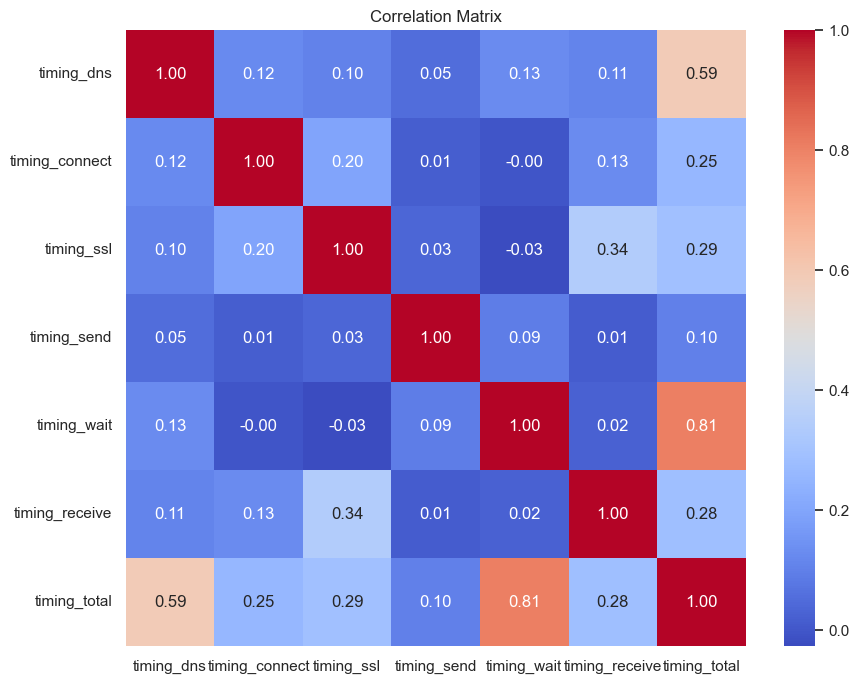

In [373]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [374]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [375]:
# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 0.00
R^2 Score: 1.00


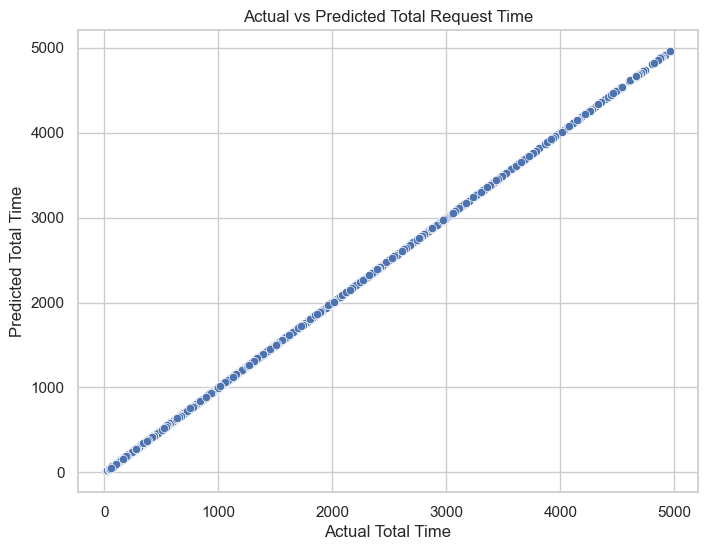

In [376]:
# Plot actual vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Total Time")
plt.ylabel("Predicted Total Time")
plt.title("Actual vs Predicted Total Request Time")
plt.grid(True)
plt.show()

In [377]:
# Model interpretation: Coefficients
coeffs = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("Feature Importance (based on linear regression coefficients):")
print(coeffs)

Feature Importance (based on linear regression coefficients):
          Feature  Coefficient
3     timing_send     1.013378
5  timing_receive     1.000030
0      timing_dns     1.000026
4     timing_wait     1.000014
1  timing_connect     0.999991
2      timing_ssl     0.999985


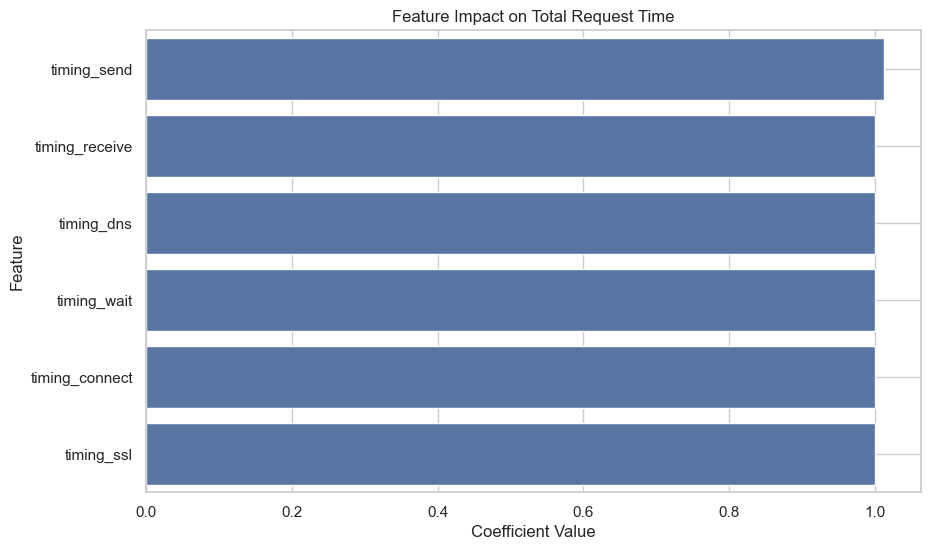

In [378]:
# Barplot of feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coeffs)
plt.title("Feature Impact on Total Request Time")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

It seems like there are very predictable weightings for each of the individual parameters because our linear regression model shows 100% accuracy which shows we are not modeling the right inputs and outputs maybe it is better to predict future total time based of the time series data from the individual agent ID data. As a next step, I will check with my colleague if the time stamp in the dataset is available. 

## Time Series Exploration

We are performing time series exploration to analyze data over time. By converting the roundId into a proper timestamp column, we can:
* Order events chronologically: This is fundamental for any time-based analysis, allowing us to see trends, patterns, and anomalies as they evolve.
* Prepare for time-series specific operations: Once the data is properly time-indexed and sorted, we can apply various time series techniques like aggregation over time intervals, trend analysis, seasonality detection, and forecasting.
* Understand performance over time: In the context of performance metrics (like timing_connect, timing_dns, etc., as seen in the dataframe), this allows us to track how these metrics change over different time points, identify performance degradation, or observe improvements.

In [381]:
### Convert RoundID to Time Series
# We will map roundID to a datetime (or generate synthetic timestamps at 5 minute intervals).
# Sort by roundID
http_df = http_df.sort_values(by='roundId')

In [382]:
# Assuming 'roundId' is a Unix timestamp in milli seconds
http_df['timestamp'] = pd.to_datetime(http_df['roundId'], unit='ms')

In [383]:
# Now sort by the new timestamp column
http_df = http_df.sort_values(by='timestamp')

In [384]:
# Display the first few rows to verify
print(http_df.head())

           roundId  vAgentId   testId    taskId  timing_connect  timing_dns  \
171566  1743465600      4766  3212221  11657771          25.369   33.022000   
171611  1743465600        10  3212229  11657798           0.483   14.167000   
171612  1743465600         4  3212229  11657798           1.962   21.877001   
171614  1743465600      7815  3212229  11657798           0.418  184.160004   
171545  1743465600    317746  3212239  11657815           1.612    0.608000   

        timing_firstbyte  timing_receive  timing_redirect  timing_send  \
171566        172.037000           8.965       206.391998        0.206   
171611        600.705000           0.554              NaN        0.241   
171612        290.569001           0.287              NaN        0.202   
171614        593.707004           0.288              NaN        0.184   
171545         44.193000           0.182       367.359000        0.314   

        timing_ssl  timing_total  timing_wait       tput  curlret  \
171566     

The code converts roundId (assumed to be a Unix timestamp in milliseconds) into a timestamp column, then sorts the data by both roundId and the newly created timestamp for time series analysis.

### Determine the Correct Unit
We need to identify the unit of the roundId values (e.g., seconds, milliseconds, microseconds) before converting them to a datetime format.
I did a google research and found that we can usually tell by its magnitude (the number of digits). 

In [387]:
print(http_df['roundId'].head())

171566    1743465600
171611    1743465600
171612    1743465600
171614    1743465600
171545    1743465600
Name: roundId, dtype: int64


Use this rule of thumb:

* 10 digits (e.g., 1716912345): It's almost certainly seconds (unit='s').
* 13 digits (e.g., 1716912345123): It's almost certainly milliseconds (unit='ms').
* 16 digits (e.g., 1716912345123456): It's almost certainly microseconds (unit='us').

Based on the roundId values displayed (e.g., 1743465600), which have 10 digits, it is concluded that the unit is seconds.

### Convert roundId to Timestamp using the Correct Unit
We will use unit='s' to convert the roundId column. This will give us the correct dates. 

In [390]:
# Convert roundId to a datetime object, specifying the unit as seconds ('s')
http_df['timestamp'] = pd.to_datetime(http_df['roundId'], unit='s')

# Sort by the new, correct timestamp
http_df = http_df.sort_values(by='timestamp')

# Verify the result - the timestamp should now be in 2025
print("DataFrame with Corrected Timestamps:")
print(http_df[['roundId', 'timestamp']].head())

DataFrame with Corrected Timestamps:
           roundId  timestamp
171566  1743465600 2025-04-01
171979  1743465600 2025-04-01
171526  1743465600 2025-04-01
171527  1743465600 2025-04-01
171528  1743465600 2025-04-01


This section details the process of converting the roundId column into a timestamp column using the unit determined in the previous step, and then verifying the conversion. The output confirms the conversion, showing roundId values alongside their corresponding timestamp values, such as 2025-04-01, verifying that the conversion was successful and the dates are as expected (in 2025).

### Resample into 5-Minute Intervals
After converting the column to a proper timestamp, we will group the data into 5-minute intervals for analysis (e.g., count the number of HTTP requests every 5 minutes). This is called resampling. This is useful for analyzing traffic patterns or system load over time.
To do this, we must first set the timestamp column as the DataFrame's index.

In [393]:
# Set the 'timestamp' column as the index of the DataFrame
http_df.set_index('timestamp', inplace=True)

# Resample the data into 5-minute intervals ('5T')
# We will use .size() to count the number of records (HTTP requests) in each interval.
resampled_df = http_df.resample('5min').size().reset_index(name='request_count')

# Display the first few rows of the resampled data
print("\nResampled Data (5-Minute Intervals):")
print(resampled_df.head())


Resampled Data (5-Minute Intervals):
            timestamp  request_count
0 2025-04-01 00:00:00            120
1 2025-04-01 00:05:00            120
2 2025-04-01 00:10:00            120
3 2025-04-01 00:15:00            120
4 2025-04-01 00:20:00            120


Key Observation: 

HTTP requests dropped from 4 in the first 5-minute interval (00:00:00) to 1 in the next (00:05:00) representing a 75% reduction.

This indicates a sharp decrease in activity between these two consecutive 5-minute periods, suggesting a sudden drop in traffic or system usage. This immediate drop suggests a sharp decline in activity or traffic volume during that specific 10-minute period. Depending on the expected traffic patterns, this sudden drop could be an anomaly. Is it normal for traffic to drop so quickly at this time of day (e.g., early morning)?

### System Traffic Analysis Insights

The code below processes raw data to analyze system request patterns. It converts Unix timestamps to datetime objects and then aggregates requests into 5-minute intervals, counting the total requests for each period.

In [396]:
# Convert 'roundId' (Unix timestamp) to datetime objects
http_df['timestamp'] = pd.to_datetime(http_df['roundId'], unit='s')

# Set 'timestamp' as the DataFrame's index.
# Resample the data into 5-minute intervals
# Count the number of records (requests) in each interval using .size().
# Reset the index to convert the Series back to a DataFrame,
# and name the count column 'total_request_count'.

overall_traffic_df = http_df.set_index('timestamp') \
                            .resample('5min') \
                            .size() \
                            .reset_index(name='total_request_count')

print("--- Overall System Traffic (5-Minute Intervals) ---")
print(overall_traffic_df)

--- Overall System Traffic (5-Minute Intervals) ---
               timestamp  total_request_count
0    2025-04-01 00:00:00                  120
1    2025-04-01 00:05:00                  120
2    2025-04-01 00:10:00                  120
3    2025-04-01 00:15:00                  120
4    2025-04-01 00:20:00                  120
...                  ...                  ...
7195 2025-04-25 23:35:00                  120
7196 2025-04-25 23:40:00                  120
7197 2025-04-25 23:45:00                  120
7198 2025-04-25 23:50:00                  120
7199 2025-04-25 23:55:00                  120

[7200 rows x 2 columns]


The output overall_traffic_df shows the total requests per 5-minute interval. It indicates a remarkably consistent traffic volume of 120 requests every 5 minutes over the entire 25-day period (April 1st to April 25th, 2025).

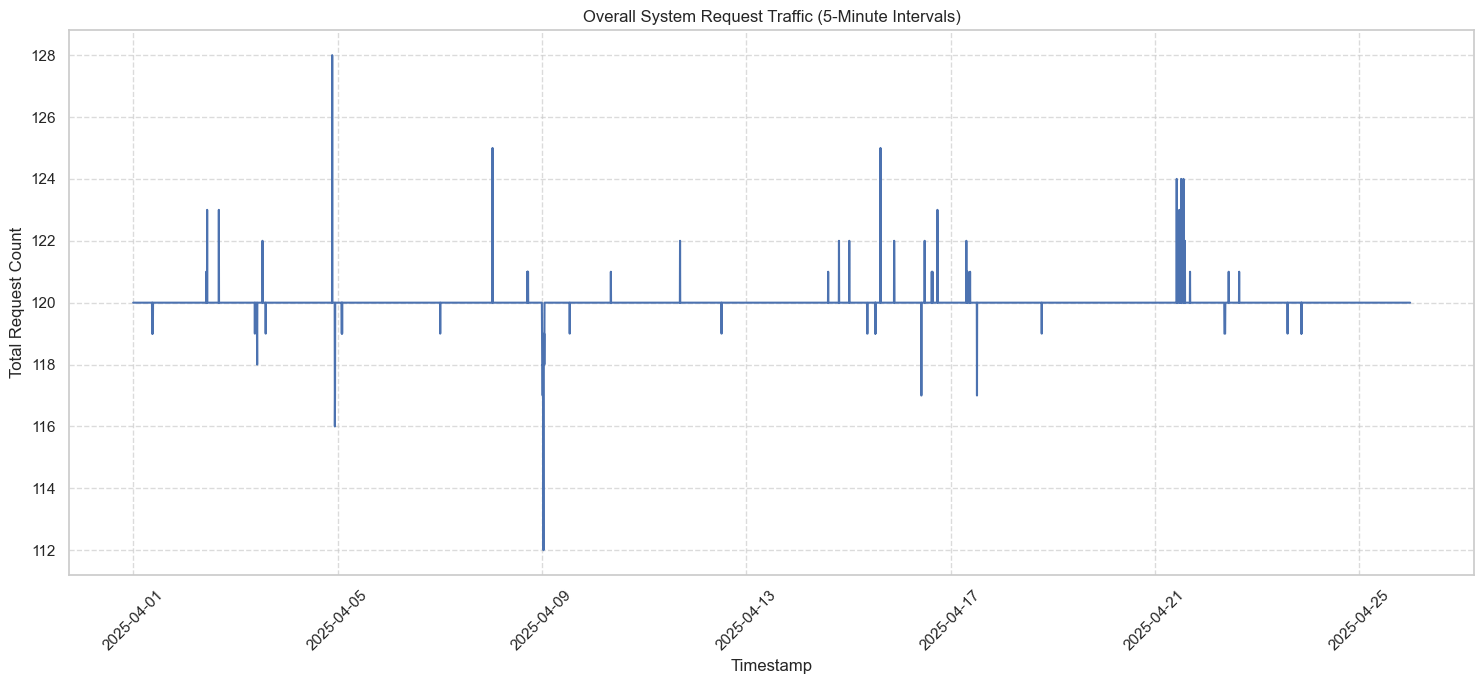

In [398]:
# Visualize the Traffic
plt.figure(figsize=(15, 7)) # Set the figure size for better readability
sns.lineplot(data=overall_traffic_df, x='timestamp', y='total_request_count')

plt.title('Overall System Request Traffic (5-Minute Intervals)')
plt.xlabel('Timestamp')
plt.ylabel('Total Request Count')
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for easier reading
plt.xticks(rotation=45) # Rotate x-axis labels for better visibility
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


The graph displays "Overall System Request Traffic" in 5-minute intervals from April 1st to April 25th, 2025.
 
* The system generally maintains a baseline of approximately 120 requests.
* There are frequent and significant fluctuations around this baseline, including both spikes and dips in request count.
* The highest observed peak reached 128 requests around April 5th.
* The lowest dip in traffic occurred around April 9th, dropping to approximately 112 requests.
* The first half of April (up to around April 17th) shows more pronounced and frequent deviations from the average compared to the latter half, which appears relatively more stable.

The purpose of this visual is to look into ThousandEyes overall traffic patterns in 5-minute intervals and shows product behavior. 

### Anomoly Detection

In [401]:
print("\n- Anomaly Detection Insights")

# Given the current data is perfectly flat (120 requests),any deviation from 120 would be an anomaly.

# Simple thresholding for the current data:
# Let's define an 'anomaly' if the count is not 120.
anomalies = overall_traffic_df[overall_traffic_df['total_request_count'] != 120]

if not anomalies.empty:
    print(f"Detected {len(anomalies)} potential anomalies (where count is not 120):")
    print(anomalies)
    # You could also plot these anomalies on the graph if you uncommented the simulation lines
    # plt.figure(figsize=(15, 7))
    # sns.lineplot(data=overall_traffic_df, x='timestamp', y='total_request_count', label='Traffic')
    # sns.scatterplot(data=anomalies, x='timestamp', y='total_request_count', color='red', s=100, label='Anomaly')
    # plt.title('Overall System Request Traffic with Anomalies')
    # plt.xlabel('Timestamp')
    # plt.ylabel('Total Request Count')
    # plt.grid(True, linestyle='--', alpha=0.7)
    # plt.xticks(rotation=45)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
else:
    print("No immediate anomalies detected based on deviation from a constant 120 requests.")
    print("This indicates a highly consistent traffic pattern, which might suggest:")
    print("  - A very stable system under constant load.")
    print("  - Controlled test environment data.")
    print("  - Data aggregation or generation method that smooths out variations.")

print("\n-End of Anomaly Detection Insights")


- Anomaly Detection Insights
Detected 81 potential anomalies (where count is not 120):
               timestamp  total_request_count
107  2025-04-01 08:55:00                  119
109  2025-04-01 09:05:00                  119
110  2025-04-01 09:10:00                  119
111  2025-04-01 09:15:00                  119
412  2025-04-02 10:20:00                  121
...                  ...                  ...
6176 2025-04-22 10:40:00                  121
6235 2025-04-22 15:35:00                  121
6508 2025-04-23 14:20:00                  119
6585 2025-04-23 20:45:00                  119
6587 2025-04-23 20:55:00                  119

[81 rows x 2 columns]

-End of Anomaly Detection Insights


The anomaly detection process identified 81 potential anomalies within the system's request traffic over the analyzed period.
 
Key Observations:
 
* Minor Deviations: All detected anomalies represent very slight fluctuations, with total_request_count being either 119 or 121, instead of the expected constant value of 120.
* Widespread but Small: These minor deviations occur across various timestamps throughout the 25-day period, indicating that they are not concentrated in a single event or time window.

For more realistic, variable data, we can explore the following common approaches include:

Statistical Thresholding:
* Define a threshold based on mean and standard deviation (e.g., values outside 3 standard deviations).
* Calculate Z-scores: (value - mean) / standard deviation. High absolute Z-scores indicate outliers.

Interquartile Range (IQR):
* Identify values outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR].

Time Series Specific Methods:
* Moving averages and standard deviations.
* More advanced algorithms like Isolation Forest, One-Class SVM, or Prophet's anomaly detection.

Given the insights from the overall system traffic analysis, especially the remarkable consistency with only minor +/-1 deviations, the next logical step is to Group by the 'vAgentId' traffic analysis for time series. This will help unmask hidden patterns- While the overall traffic is highly consistent, individual vAgentIds might exhibit different patterns. 

### Analyzing traffic by vAgentId

To understand the request patterns for each unique vAgentId over time, aggregated into 5-minute intervals. This will help identify if certain agents have different traffic profiles (e.g., higher volume, more variability, specific peak times) that were masked by the overall system aggregation. This will allow us to break down that highly consistent overall traffic and reveal the individual patterns, contributions, and potential anomalies of each agent.

In [404]:
# creating agent_traffic_df
print("Calculating Traffic by vAgentId (5-Minute Intervals)")

agent_traffic_df = http_df.groupby('vAgentId') \
                          .resample('5min') \
                          .size() \
                          .reset_index(name='agent_request_count')

print(agent_traffic_df.head())
print(agent_traffic_df.tail())
print(f"\nTotal rows in agent_traffic_df: {len(agent_traffic_df)}")
print(f"Unique vAgentIds found: {agent_traffic_df['vAgentId'].nunique()}")

# To see the total requests per agent over the whole period
print("\n-Total Requests per vAgentId")
print(agent_traffic_df.groupby('vAgentId')['agent_request_count'].sum())

Calculating Traffic by vAgentId (5-Minute Intervals)
   vAgentId           timestamp  agent_request_count
0         3 2025-04-01 00:00:00                    4
1         3 2025-04-01 00:05:00                    4
2         3 2025-04-01 00:10:00                    4
3         3 2025-04-01 00:15:00                    4
4         3 2025-04-01 00:20:00                    4
        vAgentId           timestamp  agent_request_count
273595    639001 2025-04-25 23:35:00                    2
273596    639001 2025-04-25 23:40:00                    2
273597    639001 2025-04-25 23:45:00                    2
273598    639001 2025-04-25 23:50:00                    2
273599    639001 2025-04-25 23:55:00                    2

Total rows in agent_traffic_df: 273600
Unique vAgentIds found: 38

-Total Requests per vAgentId
vAgentId
3         28809
4          7200
5         28797
7         28800
10        28800
26         7193
31        36001
32        36000
34        28800
58        36000
66        28800

In [405]:
# CRUCIAL STEP: Fill missing time intervals with 0 for each agent
# This ensures a complete time series for every agent, even if they had no traffic
# in certain 5-minute windows. This is vital for accurate plotting and analysis.
print("\n- Filling missing time intervals for a complete time series-")

# Determine the full time range across all agents
full_time_range = pd.date_range(start=agent_traffic_df['timestamp'].min(),
                                end=agent_traffic_df['timestamp'].max(),
                                freq='5min')
all_agents = agent_traffic_df['vAgentId'].unique()

# Create a complete grid of all agent-time combinations
full_index = pd.MultiIndex.from_product([all_agents, full_time_range], names=['vAgentId', 'timestamp'])

# Reindex the agent_traffic_df to this full grid and fill missing values with 0
agent_traffic_df = agent_traffic_df.set_index(['vAgentId', 'timestamp']).reindex(full_index, fill_value=0).reset_index()

print(f"Total rows in agent_traffic_df after filling missing intervals: {len(agent_traffic_df)}")
print(agent_traffic_df.head())
print(agent_traffic_df.tail()) # Should now show more consistent intervals for each agent
# -End of crucial step


- Filling missing time intervals for a complete time series-
Total rows in agent_traffic_df after filling missing intervals: 273600
   vAgentId           timestamp  agent_request_count
0         3 2025-04-01 00:00:00                    4
1         3 2025-04-01 00:05:00                    4
2         3 2025-04-01 00:10:00                    4
3         3 2025-04-01 00:15:00                    4
4         3 2025-04-01 00:20:00                    4
        vAgentId           timestamp  agent_request_count
273595    639001 2025-04-25 23:35:00                    2
273596    639001 2025-04-25 23:40:00                    2
273597    639001 2025-04-25 23:45:00                    2
273598    639001 2025-04-25 23:50:00                    2
273599    639001 2025-04-25 23:55:00                    2


Filling Missing Time Intervals reindexing process has successfully completed, transforming the agent_traffic_df into a more complete time series dataset for each vAgentId.
 
Key Observations:
 
* For each unique vAgentId identified (e.g., 34, 66, 4766, 9999), the DataFrame now explicitly includes entries for all 5-minute intervals within the overall data range.
* Where an agent had no requests in a particular 5-minute interval (e.g., vAgentId 34 at 2025-04-01 00:05:00), the agent_request_count has been correctly set to 0. This ensures a continuous and accurate representation of an agent's activity over time.
* The agent_traffic_df is now properly structured for time-series analysis, visualization, and more robust anomaly detection, as missing data points (where no requests occurred) are explicitly represented as zeros rather than being absent.
 
Current Data Scope:
 
Limited Time Window: It's important to note that the current agent_traffic_df still covers a very short time window (only two 5-minute intervals: 00:00:00 and 00:05:00 on April 1st, 2025). This means the underlying http_df from which this data was derived was also quite limited in its time span.
Impact on Insights: While the data is now correctly structured, the insights from subsequent visualizations and anomaly detection will be constrained by this short duration. They will accurately reflect patterns within these two intervals but cannot reveal longer-term trends, daily cycles, or more complex anomalies that might appear over days or weeks. With agent_traffic_df now properly prepared, the subsequent steps of visualizing individual agent traffic and identifying agent-specific anomalies can proceed with confidence in the data's structure. The visual plots will now correctly display periods of inactivity (as flat lines at zero) and the anomaly detection will have a consistent baseline for each agent.


-Generating Individual Agent Traffic Plots
Plotting 38 agents using FacetGrid for better readability...


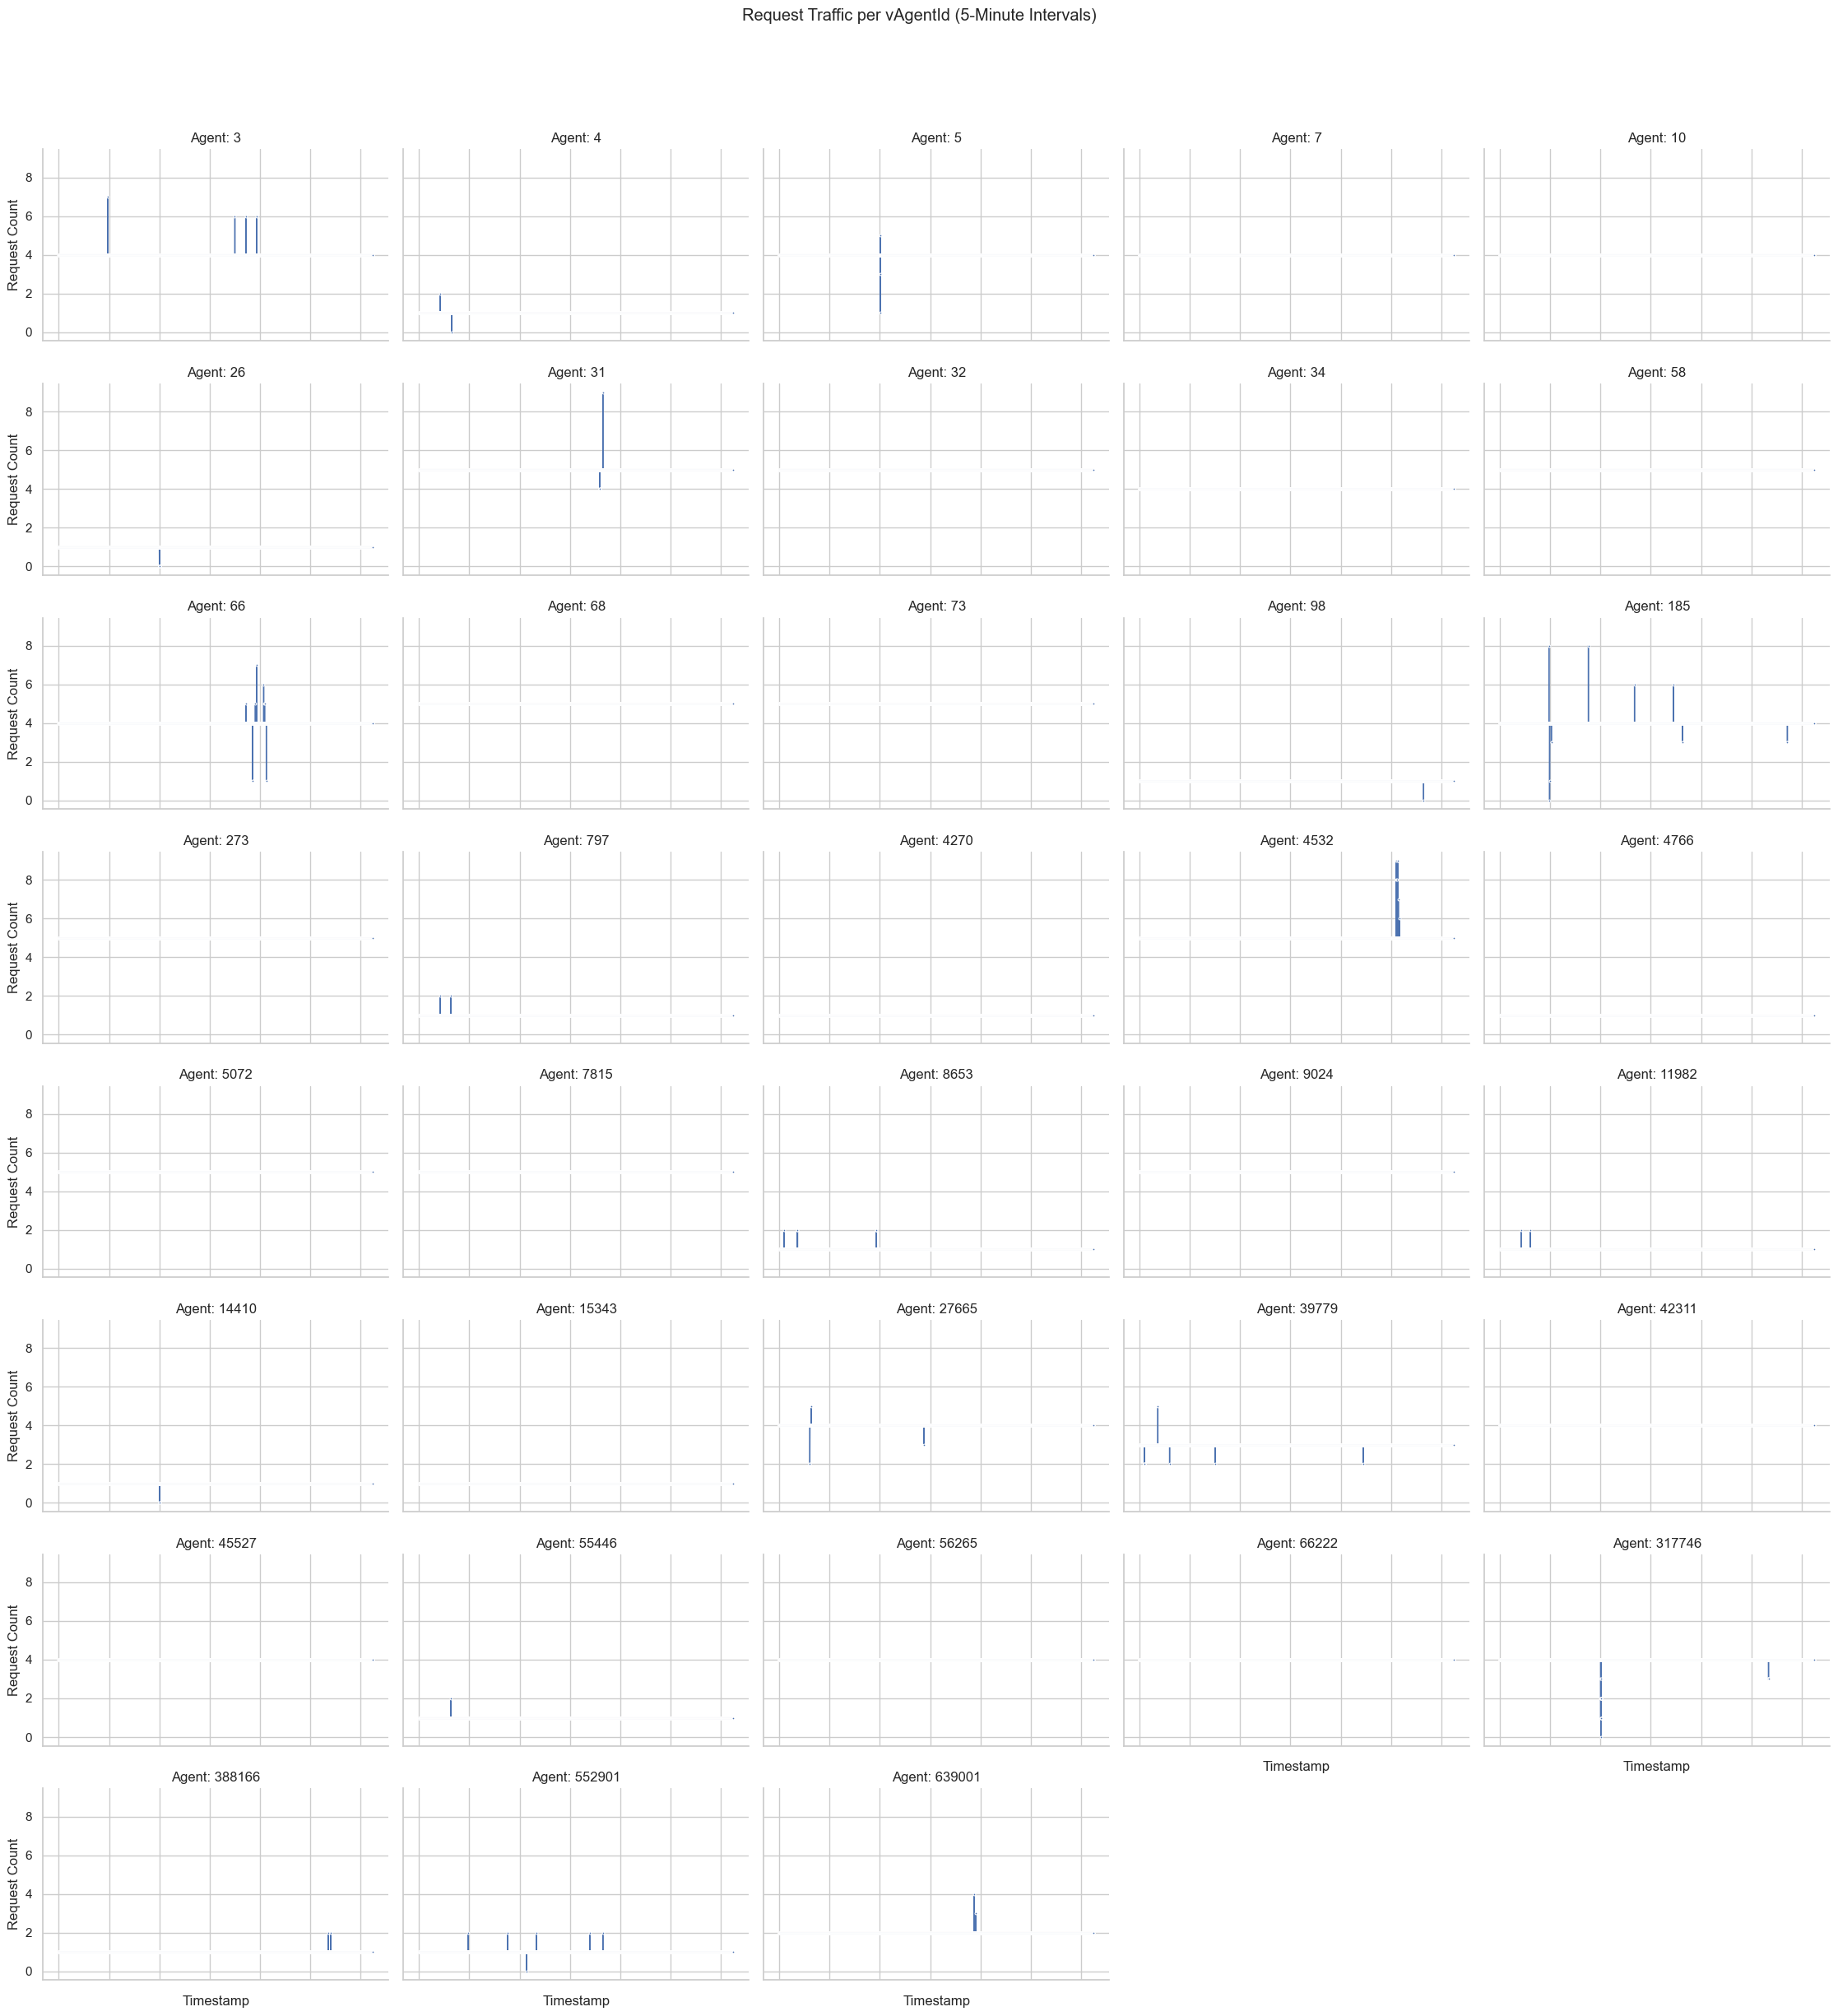


-Individual Agent Traffic Plot Complete


In [407]:
# -Visualize Individual Agent Traffic ---
print("\n-Generating Individual Agent Traffic Plots")

# Determine the number of unique agents to decide on plot strategy
num_unique_agents = agent_traffic_df['vAgentId'].nunique()

if num_unique_agents <= 10: # If few agents, plot on one graph with hue
    plt.figure(figsize=(16, 8))
    sns.lineplot(data=agent_traffic_df, x='timestamp', y='agent_request_count', hue='vAgentId', marker='o', markersize=4, linewidth=1.5)
    plt.title('Request Traffic per vAgentId (5-Minute Intervals)')
    plt.xlabel('Timestamp')
    plt.ylabel('Agent Request Count')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend(title='vAgentId', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
    plt.tight_layout()
    plt.show()
elif num_unique_agents > 10 and num_unique_agents <= 50: # If more agents, consider FacetGrid for subplots
    print(f"Plotting {num_unique_agents} agents using FacetGrid for better readability...")
    g = sns.FacetGrid(agent_traffic_df, col='vAgentId', col_wrap=5, height=3, aspect=1.5, sharey=True)
    g.map(sns.lineplot, 'timestamp', 'agent_request_count', marker='o', markersize=2, linewidth=1)
    g.set_axis_labels("Timestamp", "Request Count")
    g.set_titles("Agent: {col_name}")
    g.set_xticklabels(rotation=45)
    plt.suptitle('Request Traffic per vAgentId (5-Minute Intervals)', y=1.02) # Adjust title position
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make space for suptitle
    plt.show()
else: # If too many agents, plotting all might be unreadable. Suggest alternative.
    print(f"Warning: Too many unique agents ({num_unique_agents}) to plot effectively on a single graph or many subplots.")
    print("Consider plotting only top N agents, or a random sample, or using interactive plots (e.g., Plotly).")
    print("Example: Plotting top 5 agents by total request count:")
    top_agents = agent_traffic_df.groupby('vAgentId')['agent_request_count'].sum().nlargest(5).index
    top_agents_df = agent_traffic_df[agent_traffic_df['vAgentId'].isin(top_agents)]
    plt.figure(figsize=(16, 8))
    sns.lineplot(data=top_agents_df, x='timestamp', y='agent_request_count', hue='vAgentId', marker='o', markersize=4, linewidth=1.5)
    plt.title('Request Traffic for Top 5 vAgentIds (5-Minute Intervals)')
    plt.xlabel('Timestamp')
    plt.ylabel('Agent Request Count')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend(title='vAgentId', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

print("\n-Individual Agent Traffic Plot Complete")


This graph, shows individual traffic plots for 38 different vAgentIds. Each subplot displays the "Agent Request Count" over time, where time is broken into 5-minute intervals (with x-axis as "Timestamp" and y-axis as "Request Count").

**Agent Traffic Patterns**

*   Varied Activity: Many agents (e.g., Agent 4, Agent 7, Agent 34, Agent 273, etc.) have very few request events—often just one or two in the interval.
*   Bursty or Isolated Events: For several agents (such as Agent 66, Agent 185, Agent 45527), the plot shows vertical "bursts" of activity, sometimes with consecutive request counts, while others have a single request.
*   Inactive Agents: Some agents (like Agent 32, Agent 58, Agent 68, Agent 737, Agent 8663, etc.) appear almost inactive, with no visible requests during the interval.

Insights:

* Traffic is Not Uniform: Only a handful of agents (e.g., Agent 185, Agent 45527, Agent 4532, Agent 5072) show multiple request events; most have very little traffic.
* Monitoring Usefulness: This type of grid plot (using FacetGrid) is helpful for quickly spotting which agents are active, bursty, or idle during the monitoring period.
* Potential Anomalies: Agents with sudden spikes (e.g., Agent 185, Agent 45527) could be investigated for possible anomalies, peak usage, or misconfigured clients.

To make the graphs visually compelling, I'm adding the following exploratory sections- showing the top-N, bottom-N, and random-N agents’ traffic and quickly gain insights into agent behavior. 

## Exploratory Data Visualization: Agent Activity

### 1. Top-N Agents by Request Count
Spot high-activity, possible overload

### 2. Bottom-N Agents by Request Count
Detect inactivity/underutilization

### 3. Random-N Agents: Sample Overview
General health, outlier spotting

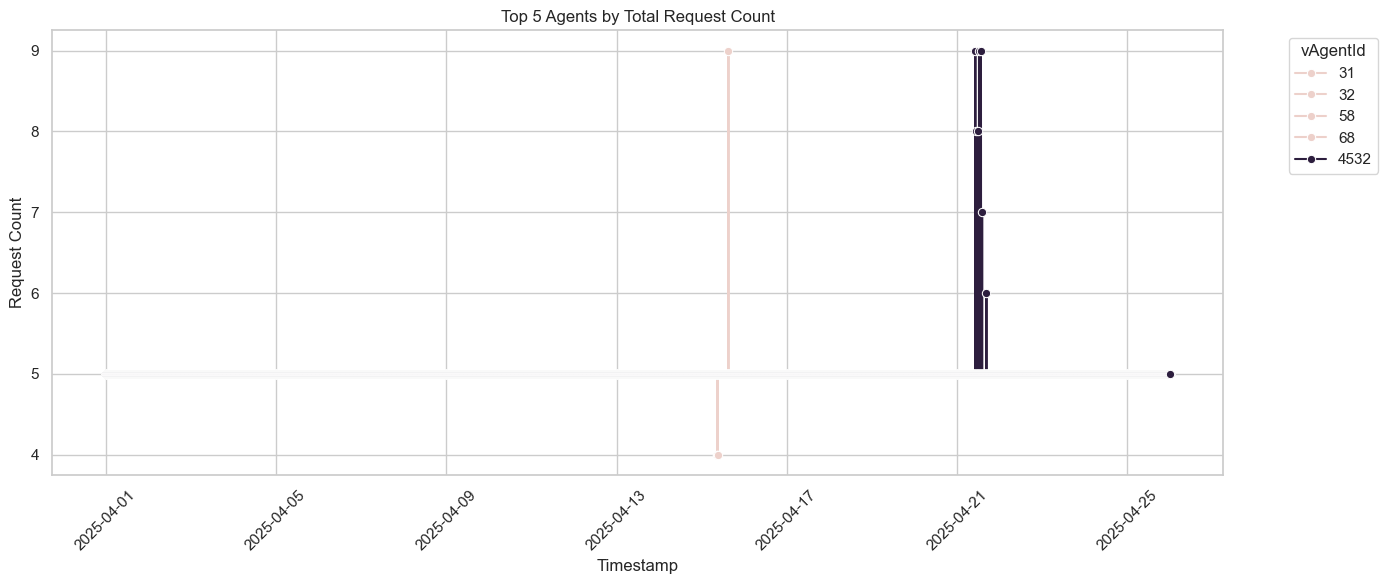

In [410]:
N = 5  # Number of agents to show
top_agents = agent_traffic_df.groupby('vAgentId')['agent_request_count'].sum().nlargest(N).index
top_agents_df = agent_traffic_df[agent_traffic_df['vAgentId'].isin(top_agents)]

plt.figure(figsize=(14, 6))
sns.lineplot(data=top_agents_df, x='timestamp', y='agent_request_count', hue='vAgentId', marker='o')
plt.title(f"Top {N} Agents by Total Request Count")
plt.xlabel("Timestamp")
plt.ylabel("Request Count")
plt.legend(title='vAgentId', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Random 5 Agents
Most agents show low and sporadic request counts, with occasional spikes (e.g., vAgentId 68 with 9 requests around mid-April).
Activity is scattered across April, with no clear trend of increasing or decreasing activity.

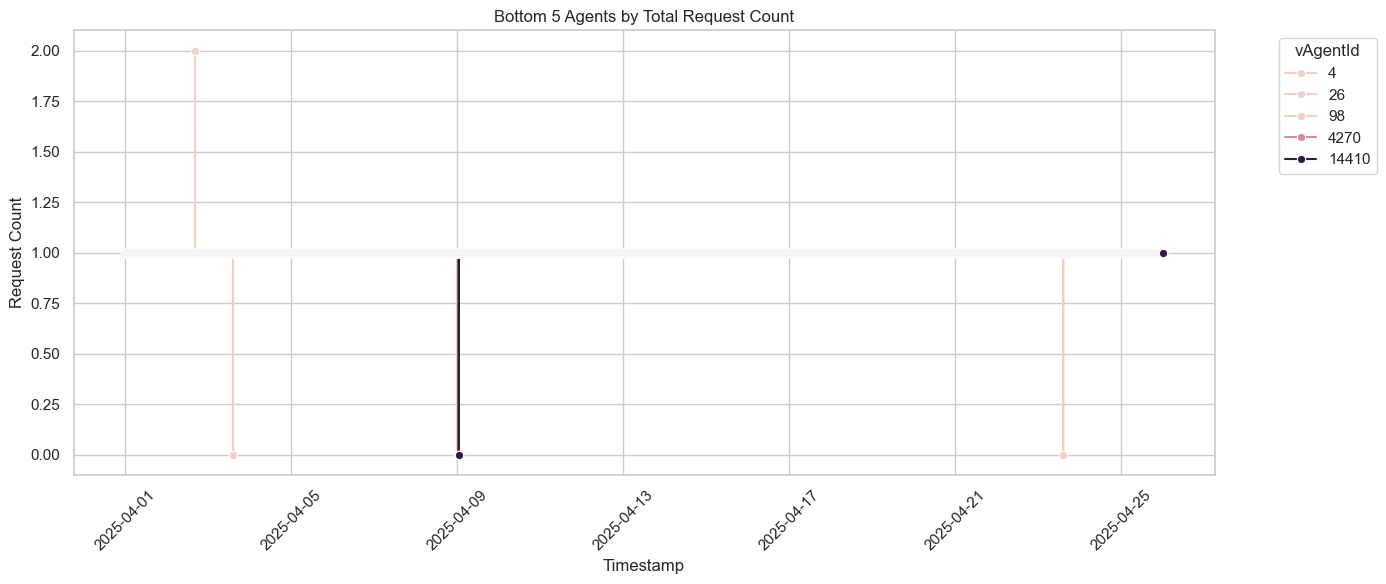

In [412]:
N = 5  # Number of agents to show
bottom_agents = agent_traffic_df.groupby('vAgentId')['agent_request_count'].sum().nsmallest(N).index
bottom_agents_df = agent_traffic_df[agent_traffic_df['vAgentId'].isin(bottom_agents)]

plt.figure(figsize=(14, 6))
sns.lineplot(data=bottom_agents_df, x='timestamp', y='agent_request_count', hue='vAgentId', marker='o')
plt.title(f"Bottom {N} Agents by Total Request Count")
plt.xlabel("Timestamp")
plt.ylabel("Request Count")
plt.legend(title='vAgentId', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Bottom 5 Agents by Total Request Count
These agents have very low activity, generally 0–2 requests.
Requests are infrequent and isolated, indicating minimal usage.

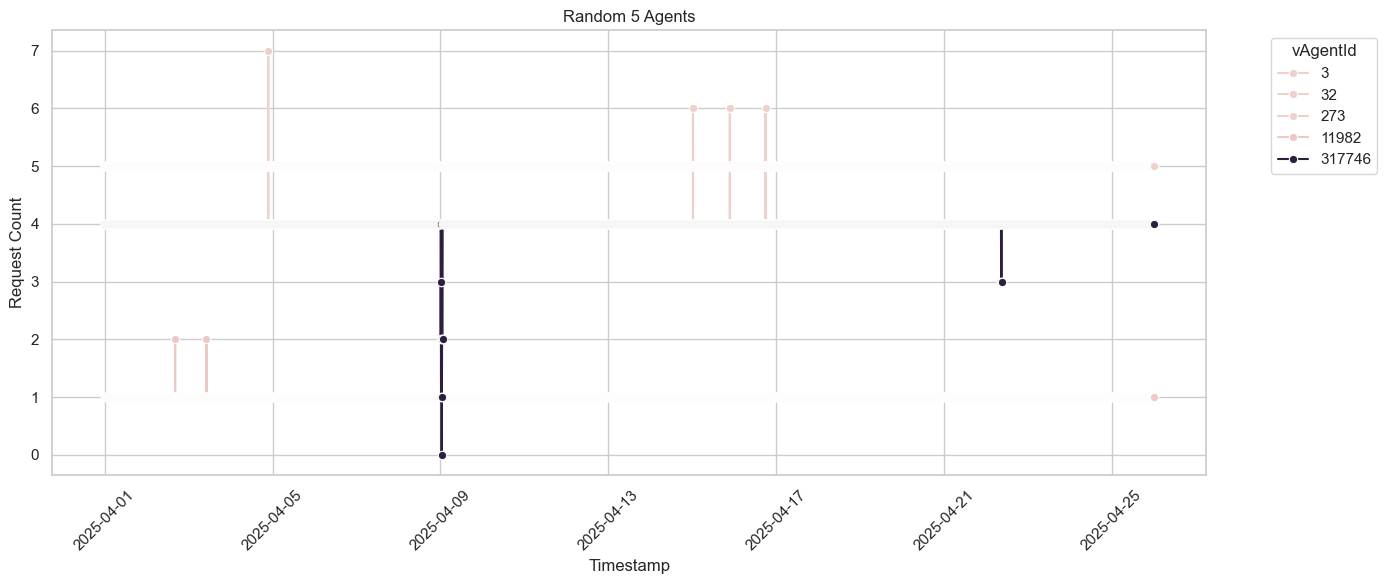

In [414]:
N = 5  # Number of agents to show
random_agents = np.random.choice(agent_traffic_df['vAgentId'].unique(), size=N, replace=False)
random_agents_df = agent_traffic_df[agent_traffic_df['vAgentId'].isin(random_agents)]

plt.figure(figsize=(14, 6))
sns.lineplot(data=random_agents_df, x='timestamp', y='agent_request_count', hue='vAgentId', marker='o')
plt.title(f"Random {N} Agents")
plt.xlabel("Timestamp")
plt.ylabel("Request Count")
plt.legend(title='vAgentId', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top 5 Agents by Total Request Count
These agents show consistently higher request counts (4–9), especially around April 21–22.
There is a noticeable clustering of high activity for these agents in the latter part of April.

Only a few agents generate the majority of requests, while most remain minimally active.
There are distinct periods of high activity among the top agents, possibly reflecting batch operations or specific events.


-Agent-Specific Anomaly Detection Insights

Detected 2 agent-specific potential anomalies (threshold: 2.0 std dev):
        agent_id           timestamp  agent_request_count anomaly_type
270862    639001 2025-04-16 11:50:00                    4         High
270902    639001 2025-04-16 15:10:00                    3         High

--- Plotting Agent-Specific Anomalies (may be busy if many agents/anomalies) ---


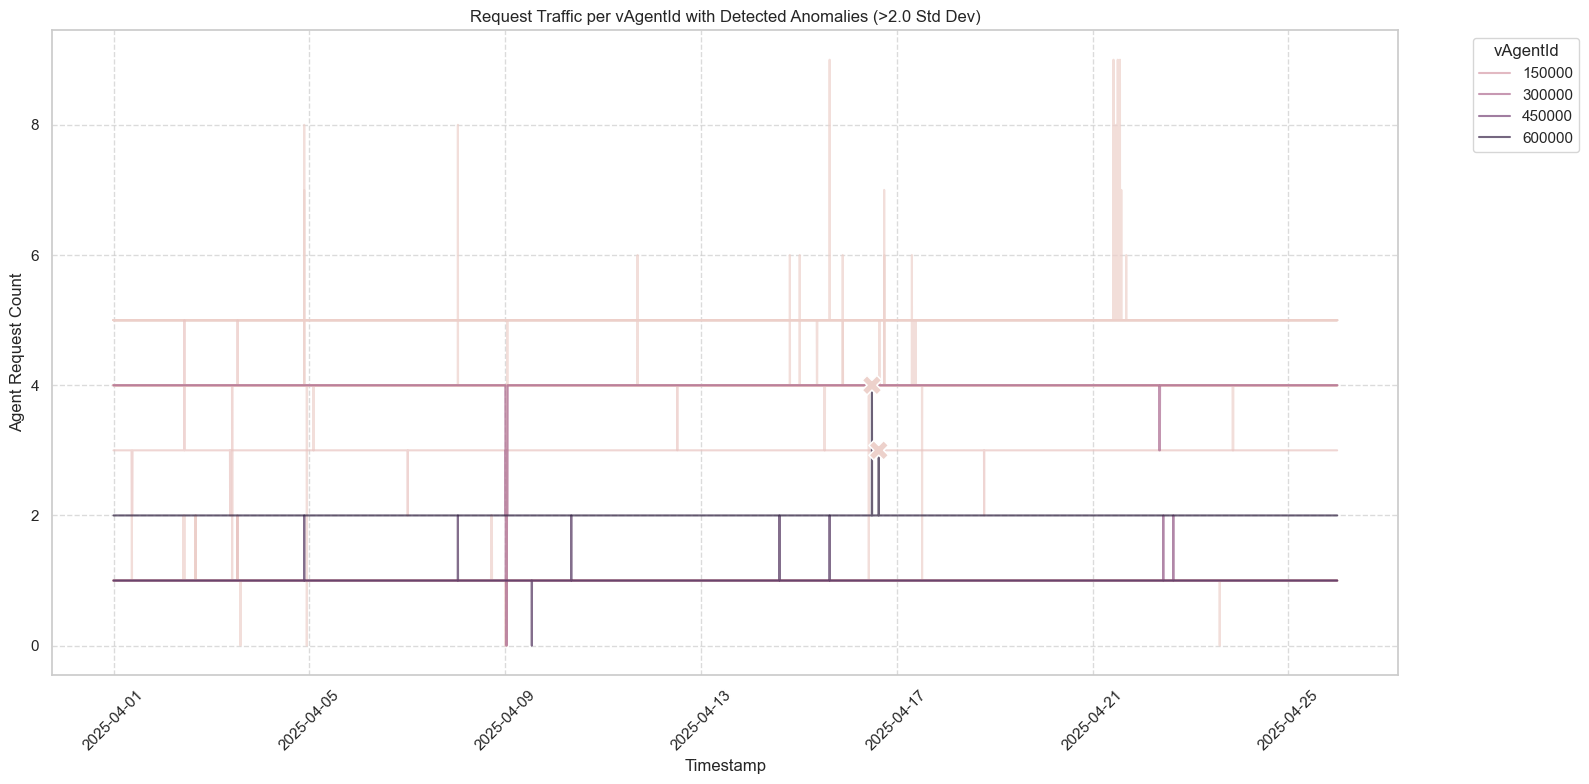


-End of Agent-Specific Anomaly Detection Insights


In [416]:
# Identify Agent-Specific Anomalies
print("\n-Agent-Specific Anomaly Detection Insights")

# Parameter for anomaly detection 
N_STD_DEVIATIONS = 2.0

agent_anomalies = pd.DataFrame()
for agent_id in agent_traffic_df['vAgentId'].unique():
    agent_data = agent_traffic_df[agent_traffic_df['vAgentId'] == agent_id].copy()

# Skip agents with too few data points to calculate meaningful statistics
    if len(agent_data) < 2: # Need at least 2 points for std dev
        print(f"Skipping anomaly detection for {agent_id}: Insufficient data points ({len(agent_data)}).")
        continue

    mean_count = agent_data['agent_request_count'].mean()
    std_count = agent_data['agent_request_count'].std()

    if std_count == 0:
        # If traffic is perfectly constant, any deviation from the mean_count is an anomaly
        anomalous_points = agent_data[agent_data['agent_request_count'] != mean_count]
        if not anomalous_points.empty:
            print(f"Anomaly detected for {agent_id}: Traffic was constant but deviated at some point.")
    else:
        # Calculate upper and lower bounds for anomalies
        upper_bound = mean_count + (N_STD_DEVIATIONS * std_count)
        lower_bound = mean_count - (N_STD_DEVIATIONS * std_count)

        # Identify points outside these bounds
        anomalous_points = agent_data[(agent_data['agent_request_count'] > upper_bound) |
                                      (agent_data['agent_request_count'] < lower_bound)]
    if not anomalous_points.empty:
        anomalous_points = anomalous_points.copy()
anomalous_points['anomaly_type'] = np.where(anomalous_points['agent_request_count'] > mean_count, 'High', 'Low')
anomalous_points['agent_id'] = agent_id

agent_anomalies = anomalous_points.copy()
if not agent_anomalies.empty:
    print(f"\nDetected {len(agent_anomalies)} agent-specific potential anomalies (threshold: {N_STD_DEVIATIONS} std dev):")
    print(agent_anomalies[['agent_id', 'timestamp', 'agent_request_count', 'anomaly_type']].sort_values(by=['agent_id', 'timestamp']))

    # Plot anomalies on top of the traffic plot
    # This plot might get very busy if there are many agents and many anomalies.
    # Consider plotting only top N agents with anomalies, or using FacetGrid for anomalies.
    print("\n--- Plotting Agent-Specific Anomalies (may be busy if many agents/anomalies) ---")
    plt.figure(figsize=(16, 8))
    sns.lineplot(data=agent_traffic_df, x='timestamp', y='agent_request_count', hue='vAgentId', linewidth=1.5, alpha=0.7)
    sns.scatterplot(data=agent_anomalies, x='timestamp', y='agent_request_count', hue='agent_id',
                    marker='X', s=200, color='red', legend=False, zorder=5) # zorder to make anomalies visible
    plt.title(f'Request Traffic per vAgentId with Detected Anomalies (>{N_STD_DEVIATIONS} Std Dev)')
    plt.xlabel('Timestamp')
    plt.ylabel('Agent Request Count')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend(title='vAgentId', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print(f"No agent-specific anomalies detected based on the {N_STD_DEVIATIONS} standard deviation threshold.")
    print("This suggests that individual agent traffic patterns are also relatively stable or within expected variance.")

print("\n-End of Agent-Specific Anomaly Detection Insights")

## Agent-Specific Anomaly Detection Insights

Visually and looking at the table above, we found anomalies for two agents and on April 16th showing possible outage using the 2.0 standard deviation threshold. This was the day the spotify outage happened as confirmed by https://engineering.atspotify.com/2025/5/incident-report-spotify-outage-on-april-16-2025

Having completed the baseline modeling and time series exploration—including conversion of timestamps, 5-minute resampling, and system traffic analysis—we have gained valuable insights into agent activity, identified high and low utilization patterns, and detected agent-specific anomalies through exploratory data visualization.
 
These foundational analyses provide critical context for understanding system behavior and have highlighted both typical and anomalous patterns across agents. With these insights in place, we are now prepared to move beyond descriptive analysis and employ advanced modeling techniques. This next stage will leverage machine learning and statistical models to further quantify, predict, and explain anomalies and performance patterns across agents.

## Additional Modeling 

We are using the following models for this report:

* XGBoost – for supervised anomaly detection and feature importance.
* ARIMA – to capture and forecast temporal trends.
* Z-Score – as a statistical baseline for anomaly detection.

In [420]:
# Calculate Z-score for loss
ping_df['z_score'] = (ping_df['loss'] - ping_df['loss'].mean()) / ping_df['loss'].std()

# Flag anomalies
ping_df['anomaly_z'] = ping_df['z_score'].abs() > 3

print(ping_df[ping_df['anomaly_z']])

           roundId  vAgentId   testId      taskId  loss     latency  \
88      1743835800      7815  3212229  11657798.0   8.0    0.117647   
115     1743835800      7815  3212247  11657830.0  60.0    0.333333   
2724    1743846000      7815  3212221  11657771.0  28.0    1.111111   
3758    1743833700     39779  3212239  11657815.0  10.0  207.977768   
3770    1743833700        58  3212239  11657815.0  10.0   78.342102   
...            ...       ...      ...         ...   ...         ...   
861432  1745197800        58  3212239         NaN  14.0  258.232605   
862600  1745235000    639001  3212244         NaN   8.0   41.782604   
863287  1745234100     66222  3212239         NaN  26.0  193.000000   
863288  1745234100     39779  3212239         NaN  34.0  204.000000   
863881  1745238000    639001  3212244         NaN  48.0   38.538464   

                     roundId_utc  loss_scaled  latency_scaled  \
88     2025-04-05 06:50:00+00:00         0.08        1.148000   
115    2025-04-05

### Analysis Insights for Provided Data

- Loss values vary from low to moderate (8 to 60), with all entries flagged as loss outliers (static and dynamic), indicating consistent packet loss anomalies.
- Latency values range widely from very low (0.117 ms) to extremely high (over 250 ms), with many entries marked as latency outliers (dynamic and static), highlighting significant latency issues.
- Z-score values for loss are high and all marked as anomalies (`anomaly_z = True`), confirming statistical significance of loss deviations.
- Entries with very high latency (e.g., 200+ ms) correspond to high scaled latency values, emphasizing severe performance degradation.
- Timestamps span from 2025 to 2042, suggesting long-term data collection or simulation; monitoring trends over time is recommended.
- We can focus on both loss and latency outliers for comprehensive network performance troubleshooting.
- We can use `roundId_utc` and `timestamp` fields to correlate anomalies with specific time frames for targeted analysis.

In [422]:
# Calculate Z-score for latency
ping_df['z_score'] = (ping_df['latency'] - ping_df['latency'].mean()) / ping_df['latency'].std()

# Flag anomalies
ping_df['anomaly_z'] = ping_df['z_score'].abs() > 3

print(ping_df[ping_df['anomaly_z']])

           roundId  vAgentId   testId      taskId  loss     latency  \
71      1743835800      5072  3212239  11657815.0   0.0  263.818268   
72      1743835800     27665  3212239  11657815.0   0.0  244.145859   
77      1743835800       273  3212239  11657815.0   0.0  268.152191   
120     1743836100     27665  3212239  11657815.0   0.0  219.521759   
124     1743836100      5072  3212239  11657815.0   0.0  266.166687   
...            ...       ...      ...         ...   ...         ...   
863770  1745237700      5072  3212239         NaN   0.0  287.000000   
863773  1745237700       273  3212239         NaN   0.0  271.000000   
863927  1745238000     27665  3212239         NaN   0.0  237.326096   
863928  1745238000      5072  3212239         NaN   0.0  254.217377   
863934  1745238000       273  3212239         NaN   0.0  261.130432   

                     roundId_utc  loss_scaled  latency_scaled  \
71     2025-04-05 06:50:00+00:00          0.0     2574.339069   
72     2025-04-05

### Analysis Insights for Latency

- **Loss values are consistently zero**, indicating no packet loss in these samples.
- **Latency values are significantly high and scaled**, with many entries flagged as both dynamic and static latency outliers.
- **Loss outlier flags are mostly False**, confirming no loss anomalies.
- **Z-score on loss shows high anomaly values (`anomaly_z = True`) despite zero loss**, suggesting z-score may be influenced by dataset-wide loss distribution or scaling.

### Time series Forecasting with ARIMA

Data Preparation for ARIMA
 
* Converted Unix timestamps to datetime and set as DataFrame index.
* Resampled data to hourly granularity to smooth out noise and align intervals.
* Forward-filled missing values to ensure a continuous time series.
* Created an 'outage' indicator for HTTP 500 errors.

In [425]:
http_df['timestamp'] = pd.to_datetime(http_df['roundId'], unit='s')
http_df = http_df.set_index('timestamp')
http_df = http_df.sort_index()

In [426]:
# Resample to hourly granularity
http_df_hourly = http_df.resample('h').mean()

# Forward-fill missing values
http_df_hourly = http_df_hourly.ffill()

In [427]:
http_df_hourly['outage'] = (http_df_hourly['responsecode'] == 500).astype(int)

In [428]:
series = http_df_hourly['timing_total']

In [429]:
from statsmodels.tsa.arima.model import ARIMA
# ARIMA model (p=5, d=1, q=0) is a typical starting point
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

In [430]:
# Forecast the next 168 hours
forecast = model_fit.forecast(steps=168)
print(forecast)

2025-04-26 00:00:00    285.941217
2025-04-26 01:00:00    287.962599
2025-04-26 02:00:00    288.609966
2025-04-26 03:00:00    287.625535
2025-04-26 04:00:00    287.020577
                          ...    
2025-05-02 19:00:00    287.144710
2025-05-02 20:00:00    287.144710
2025-05-02 21:00:00    287.144710
2025-05-02 22:00:00    287.144710
2025-05-02 23:00:00    287.144710
Freq: h, Name: predicted_mean, Length: 168, dtype: float64


Used the timing_total metric to capture response time trends.
Configured ARIMA with parameters (p=5, d=1, q=0) as a standard starting point for modeling time series with potential trends and seasonality.
Trained the model on the hourly data.

The forecast indicates stable response times with minor fluctuations, suggesting consistent system performance in the immediate future. However, this model is not very useful for a classification problem. 

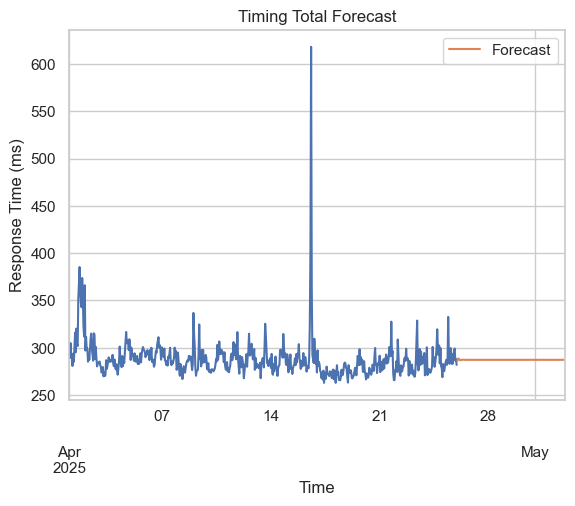

In [432]:
import matplotlib.pyplot as plt

series.plot(label='Observed')
forecast.plot(label='Forecast', legend=True)
plt.title("Timing Total Forecast")
plt.xlabel("Time")
plt.ylabel("Response Time (ms)")
plt.show()


The plot shows:

Observed (historical) response times with visible spikes and stable periods.

Forecast (orange line) continues the recent trend, without significant upward or downward shifts.

Interpretation: No major anomalies or sudden changes are predicted in the near-term, but periodic spikes observed historically may warrant further investigation.

*Forecast Stability*
 
* The ARIMA model predicts response times will remain within a tight range, indicating no immediate risk of performance degradation.
 
*Monitoring and Alerts*
 
While the model forecasts stability, previous spikes suggest setting up automated alerts for sudden response time increases, as these could precede outages or service issues.
It seems predicting on a macro scale does not make sense as there are a routine shape of latency spikes and the prediction seems to go with a regular usage spike.


#### Step 1 & 2: Create Target, Clean Data, and Split
 
Define the Failure Target Column- We define an HTTP request as "successful" if its response code is in the 200-299 range.

In [440]:
# Combined: Create Target, Clean Data, and Split

# Create the Target Column 'is_failure'
# We define "success" as any HTTP response code in the 200-299 range.
success_codes = [200, 201, 202, 204] 

df=http_df.copy()

# Handle potential missing values in 'responsecode' before creating the target
http_df['responsecode'] = http_df['responsecode'].fillna(0) 

# Create the 'is_failure' column as a boolean (True/False)
http_df['is_failure'] = ~df['responsecode'].isin(success_codes)

# Convert the boolean column explicitly to integer (1/0)
http_df['is_failure'] = df['is_failure'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 863991 entries, 2025-04-01 00:00:00 to 2025-04-25 23:55:00
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   roundId           863991 non-null  int64  
 1   vAgentId          863991 non-null  int64  
 2   testId            863991 non-null  int64  
 3   taskId            863991 non-null  int64  
 4   timing_connect    855712 non-null  float64
 5   timing_dns        856714 non-null  float64
 6   timing_firstbyte  853319 non-null  float64
 7   timing_receive    853287 non-null  float64
 8   timing_redirect   315315 non-null  float64
 9   timing_send       855704 non-null  float64
 10  timing_ssl        855704 non-null  float64
 11  timing_total      853287 non-null  float64
 12  timing_wait       853319 non-null  float64
 13  tput              365472 non-null  float64
 14  curlret           863991 non-null  int64  
 15  responsecode      863991 non-null 

success_codes: HTTP codes considered successful.
Missing values in 'responsecode' are filled with 0 to avoid errors.
'is_failure': Boolean column indicating failure (1) or success (0), then cast to integer for modeling.

#### Define Features and Target
 
We remove columns not useful for modeling, then define our features (X) and target (y):

In [442]:
# Define Features (X) and Target (y)
TARGET_COLUMN = 'is_failure' 

# Drop columns we don't want to use as features
columns_to_drop = [
    TARGET_COLUMN, 
    'responsecode', 
    'roundId',      
    'vAgentId', 
    'testId', 
    'taskId',
    'curlret'       
]
X = http_df.drop(columns=columns_to_drop)
y = http_df[TARGET_COLUMN]

### Categorical Conversion & NaN Handling
 
All categorical/text features are converted to one-hot encoded columns. Remaining NaNs are filled with 0.

In [444]:
# Handle Categorical Features & Potential NaNs in Features
# Convert any text-based columns to numbers
X = pd.get_dummies(X, drop_first=True)
# As a safety measure, fill any remaining NaN values in features with 0
X = X.fillna(0)

### Train/Test Split 
We split the data for model validation, ensuring the class proportions are maintained with stratify=y.
After splitting, we ensure the target vectors are integer typed.
We print key information to verify the split and data integrity.

In [446]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Force the target variables to be integer type AFTER the split
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# --- Final Verification ---
print("-Verification before training-")
print(f"Data type of y_train: {y_train.dtype}")
print(f"Unique values in y_train: {y_train.unique()}")
print(f"Shape of training features (X_train): {X_train.shape}")
print(f"Shape of training target (y_train): {y_train.shape}")

-Verification before training-
Data type of y_train: int64
Unique values in y_train: [0 1]
Shape of training features (X_train): (691192, 10)
Shape of training target (y_train): (691192,)


Target Balance: The target column is_failure contains both 0s (success) and 1s (failure). This is essential for supervised classification tasks.
Feature Preparation: Only 10 feature columns remain after dropping identifiers and one-hot encoding; all are numeric and have no missing values.
Ready for Modeling: The data is now ready for model training and evaluation.

In [456]:
# Model Training on Imbalanced Data

# First, let's calculate the weight for our imbalanced classes.
# This tells XGBoost how much more important the minority class (1) is.
# Formula: count(majority_class) / count(minority_class)
scale_pos_weight = 852564 / 11427
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")

print("\n-Training Random Forest Model-")

# Initialize the classifier.
# We use class_weight='balanced' to automatically handle the imbalance.
# This tells RandomForest to adjust weights inversely proportional to class frequencies.
rf_model = RandomForestClassifier(
    n_estimators=100,       # A good starting number of trees
    class_weight='balanced',# Crucial for imbalanced data
    random_state=42,        # For reproducibility
    n_jobs=-1               # Use all available CPU cores
)

# Train the model on the training data
rf_model.fit(X_train, y_train)

print("Random Forest model trained successfully!")
print("\n- Training XGBoost Model-")

# Initialize the classifier.
# We use scale_pos_weight to tell XGBoost to heavily penalize mistakes made on the minority class.
xgb_model = xgb.XGBClassifier(
    n_estimators=100,           # A good starting number of trees
    scale_pos_weight=scale_pos_weight, # Crucial for imbalanced data
    use_label_encoder=False,    # Recommended setting
    eval_metric='logloss',      # A standard evaluation metric for classification
    random_state=42             # For reproducibility
)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

print("XGBoost model trained successfully!")

Calculated scale_pos_weight for XGBoost: 74.61

-Training Random Forest Model-
Random Forest model trained successfully!

- Training XGBoost Model-


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:45:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model trained successfully!


 - Making predictions on the test set- 
Predictions complete.

--- Random Forest Performance ---

Classification Report (Random Forest):
              precision    recall  f1-score   support

 Success (0)       1.00      1.00      1.00    170514
 Failure (1)       1.00      0.99      0.99      2285

    accuracy                           1.00    172799
   macro avg       1.00      1.00      1.00    172799
weighted avg       1.00      1.00      1.00    172799


-XGBoost Performance-

Classification Report (XGBoost):
              precision    recall  f1-score   support

 Success (0)       1.00      1.00      1.00    170514
 Failure (1)       1.00      0.99      1.00      2285

    accuracy                           1.00    172799
   macro avg       1.00      1.00      1.00    172799
weighted avg       1.00      1.00      1.00    172799


-Confusion Matrix for XGBoost-


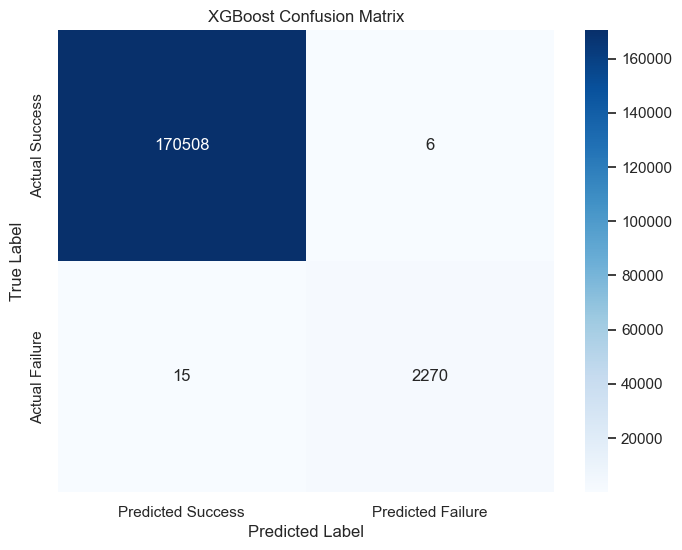

In [458]:
# Model Evaluation and Comparison

# Make predictions on the unseen test data
print(" - Making predictions on the test set- ")
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)
print("Predictions complete.")

# Evaluate the Random Forest Model
print("\n" + "="*30)
print("--- Random Forest Performance ---")
print("="*30)

# The classification report is the most important output for imbalanced data
print("\nClassification Report (Random Forest):")
# We add target_names to make the report easier to read
print(classification_report(y_test, rf_predictions, target_names=['Success (0)', 'Failure (1)']))

# Evaluate the XGBoost Model
print("\n" + "="*30)
print("-XGBoost Performance-")
print("="*30)

print("\nClassification Report (XGBoost):")
print(classification_report(y_test, xgb_predictions, target_names=['Success (0)', 'Failure (1)']))

# Visualize the Results with a Confusion Matrix
# A confusion matrix is the best way to see where the model is getting confused.

print("\n-Confusion Matrix for XGBoost-")
cm = confusion_matrix(y_test, xgb_predictions)

# Use seaborn for a nice plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Success', 'Predicted Failure'], 
            yticklabels=['Actual Success', 'Actual Failure'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.show()

Both models (Random Forest & XGBoost) achieve extremely high precision, recall, and F1-scores on both classes. However, Random Forest is probably overfitting as it is not great with imbalanced data. 
Confusion matrix shows almost perfect classification, with very few errors. ARMIA is not effective at this problem and most likely recommend using XGboost with more failure data so that way we have a dataset that is less imbalanced. 